# Run with sklearn

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import glob
import os
import subprocess
import time
import pandas as pd
import pickle
import math
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, SVR, LinearSVC
from sklearn.metrics import accuracy_score, silhouette_score, adjusted_rand_score, silhouette_samples
from sklearn.cluster import AgglomerativeClustering, SpectralClustering, KMeans
from sklearn.model_selection import KFold, LeaveOneOut, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.kernel_ridge import KernelRidge
from sklearn import linear_model
from sklearn.manifold import TSNE
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import (ModelDesc, EvalEnvironment, Term, EvalFactor, LookupFactor, dmatrices, INTERCEPT)
from statsmodels.distributions.empirical_distribution import ECDF
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.colorbar as colorbar
from matplotlib.lines import Line2D
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import MaxNLocator
import sys
import re
from concurrent.futures import ProcessPoolExecutor

ModuleNotFoundError: No module named 'sklearn'

In [6]:
import re

base_dir = "./Data" 
nex_dir = "./Nex"
# allen_data_dir = "/scratch/09656/dhh3/deeplabcut_data/"
allen_data_dir = "/scratch/09117/xz6783/Xu/Spectrum_cat_odor/deeplabcut_data/"


databin = 0.01
BinSize = 0.3 
TimeRange_before = 6 
TimeRange_after = 6.3 
Bins = int((TimeRange_before+TimeRange_after)/BinSize) 
Bins_before = int(TimeRange_before/BinSize)

## New data formatting

In [7]:
def parse_file(file_path):
    """Parses a text file and extracts data for each category."""
    category_data = {}
    current_category = None

    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()
            if line.endswith(':'):  # New category
                current_category = line[:-1]  # Remove the colon
            elif line:  # Cue data line
                cues = re.findall(r'\((\d+\.\d+)', line)  # Extract cue onsets
                if cues:
                    cues = [float(cue) for cue in cues]
                    category_data[current_category] = cues

    return category_data

def create_dataframes(category_data, animal_name):
    """Creates a DataFrame for each category, including MAX, MIN, and DIFF."""
    dataframes = {}

    for category, cues in category_data.items():
        df = pd.DataFrame(cues, columns=[animal_name])
        df['Cues'] = range(1, len(cues) + 1)  # Cue index
        df['MAX'] = df[animal_name].apply(max)
        df['MIN'] = df[animal_name].apply(min)
        df['DIFF'] = df['MAX'] - df['MIN']
        df = df[['Cues', animal_name, 'MAX', 'MIN', 'DIFF']]
        dataframes[category] = df

    return dataframes

def create_dataframes(all_animal_data):
    """Creates a DataFrame for each category, combining data and padding missing cues."""
    dataframes = {}

    for category, animal_data in all_animal_data.items():
        # Filter animals with more than 6 cues
#         filtered_animal_data = {animal: cues for animal, cues in animal_data.items() if len(cues) >= 6}
        
        if not animal_data:
            continue
        
        max_cues = max(len(cues) for cues in animal_data.values()) 

        padded_data = {
            animal: cues + [np.NaN] * (max_cues - len(cues)) 
            for animal, cues in animal_data.items()
        }

        df = pd.DataFrame(padded_data)
        df['Cues'] = range(1, max_cues + 1) 
        df['MAX'] = df.max(axis=1, skipna=True)
        df['MIN'] = df.min(axis=1, skipna=True)
        df['DIFF'] = df['MAX'] - df['MIN']
        df = df[['Cues'] + [col for col in df if col not in ['Cues', 'MAX', 'MIN', 'DIFF']] + ['MAX', 'MIN', 'DIFF']]

        dataframes[category] = df

    return dataframes

all_animal_data = {}  

for filename in os.listdir(allen_data_dir):
    if filename.endswith("Results.txt"):
        # Extract animal ID from filename
        pattern = r'\d{1,2}[A-Za-z]\d{1,2}'
        match = re.search(pattern, filename)
        if match and match.group():
            animal_name = match.group()
#         animal_name = os.path.splitext(filename)[0]
        file_path = os.path.join(allen_data_dir, filename)

        category_data = parse_file(file_path)

        for category, cues in category_data.items():
            if category not in all_animal_data:
                all_animal_data[category] = {}
            all_animal_data[category][animal_name] = cues 
            
# Create combined DataFrames
dataframes = create_dataframes(all_animal_data)

# Example usage (print Freezing DataFrame)
print(dataframes["Freezing"])

# Save as csv
for category, df in dataframes.items():
    csv_filename = f"allen_data_{category}.csv"
    csv_path = os.path.join(base_dir, csv_filename)
    df.to_csv(csv_path, index=False)  # Save DataFrame to CSV without row index
    

     Cues      3K3       4K3      10Z3      5A5      1P4      5A4      3P4  \
0       1  161.400   875.400   540.267  191.467  302.333   31.533  689.600   
1       2  198.000  1009.000   875.400  203.533  493.000  158.000  763.000   
2       3  444.467  1050.067   974.400  324.400  592.267  201.667  842.867   
3       4  502.800  1068.533  1156.800  348.000  606.467  224.200  870.667   
4       5  653.067  1089.933  1187.600  398.867  644.733  616.267  945.400   
..    ...      ...       ...       ...      ...      ...      ...      ...   
161   162      NaN       NaN       NaN      NaN      NaN      NaN      NaN   
162   163      NaN       NaN       NaN      NaN      NaN      NaN      NaN   
163   164      NaN       NaN       NaN      NaN      NaN      NaN      NaN   
164   165      NaN       NaN       NaN      NaN      NaN      NaN      NaN   
165   166      NaN       NaN       NaN      NaN      NaN      NaN      NaN   

          1K3      2A4  ...       2K3       3U5      9F2    5P4

## Code for calculating zscore, only run when needed (run with nex environment)

In [1]:
from nex5file.reader import Reader
from nex5file.filedata import FileData
import nex5file
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import glob
import os
import subprocess
import time
import pandas as pd
import pickle
import math
import multiprocessing
from functools import partial
import random

In [2]:
base_dir = "./Data"
nex_dir = "./Nex"
# allen_data_dir = "/scratch/09656/dhh3/deeplabcut_data/"
allen_data_dir = "/scratch/09117/xz6783/Xu/Spectrum_cat_odor/deeplabcut_data/"


databin = 0.01
BinSize = 0.3
TimeRange_before = 6
TimeRange_after = 6.3
Bins = int((TimeRange_before+TimeRange_after)/BinSize)
Bins_before = int(TimeRange_before/BinSize) 

In [3]:
Bins_before

20

In [4]:
import re


filenames = os.listdir(nex_dir)

# Regular expression pattern to match number+letter+number before an underscore
pattern = r'\d{1,2}[A-Za-z]\d{1,2}'

# Extract and store animal IDs
animal_ids = [re.search(pattern, filename.split('_')[0]).group() for filename in filenames if re.search(pattern, filename)]

len(animal_ids)

30

In [5]:
# Load the csv file with cross timepoints
# interval_data = pd.read_csv(os.path.join(base_dir,"Trial by Trial Cues.csv"), header = 1)
# animal_ids = [os.path.splitext(filename)[0][:3] for filename in os.listdir(allen_data_dir)]
interval_data = pd.read_csv(os.path.join(base_dir,"allen_data_Freezing.csv"))
photoid = pd.read_csv(os.path.join(base_dir,"PhotoTags.csv"), index_col =0)

In [6]:
interval_data

Cues      3K3       4K3      10Z3      5A5      1P4      5A4      3P4  \
0       1  161.400   875.400   540.267  191.467  302.333   31.533  689.600   
1       2  198.000  1009.000   875.400  203.533  493.000  158.000  763.000   
2       3  444.467  1050.067   974.400  324.400  592.267  201.667  842.867   
3       4  502.800  1068.533  1156.800  348.000  606.467  224.200  870.667   
4       5  653.067  1089.933  1187.600  398.867  644.733  616.267  945.400   
..    ...      ...       ...       ...      ...      ...      ...      ...   
161   162      NaN       NaN       NaN      NaN      NaN      NaN      NaN   
162   163      NaN       NaN       NaN      NaN      NaN      NaN      NaN   
163   164      NaN       NaN       NaN      NaN      NaN      NaN      NaN   
164   165      NaN       NaN       NaN      NaN      NaN      NaN      NaN   
165   166      NaN       NaN       NaN      NaN      NaN      NaN      NaN   

          1K3      2A4  ...       2K3       3U5      9F2    5P4      4P4  \
0    1590.800    0.000  ...   766.467    19.600  114.733   62.2   25.533   
1    1602.133   32.333  ...  1694.067    32.000  216.667   75.0   76.133   
2    1647.533  150.533  ...  1860.333    83.200  227.267  103.6   89.667   
3    1659.067  366.267  ...  2088.067    96.200  264.867  165.6  215.133   
4    1705.667  412.267  ...  2095.933   146.200  313.533  236.0  231.867   
..        ...      ...  ...       ...       ...      ...    ...      ...   
161       NaN      NaN  ...       NaN  3668.800      NaN    NaN      NaN   
162       NaN      NaN  ...       NaN  3683.800      NaN    NaN      NaN   
163       NaN      NaN  ...       NaN  3694.933      NaN    NaN      NaN   
164       NaN      NaN  ...       NaN  3709.267      NaN    NaN      NaN   
165       NaN      NaN  ...       NaN  3719.933      NaN    NaN      NaN   

         6P4      1D6       MAX    MIN      DIFF  
0    319.267  147.400  1590.800    0.0  1590.800  
1    345.467  164.533  1694.067    2.0  1692.067  
2    583.667  714.000  1860.333    3.0  1857.333  
3    690.133  763.667  2088.067    4.0  2084.067  
4    753.933  791.733  2095.933    5.0  2090.933  
..       ...      ...       ...    ...       ...  
161      NaN      NaN  3668.800  162.0  3506.800  
162      NaN      NaN  3683.800  163.0  3520.800  
163      NaN      NaN  3694.933  164.0  3530.933  
164      NaN      NaN  3709.267  165.0  3544.267  
165      NaN      NaN  3719.933  166.0  3553.933  

[166 rows x 34 columns]

In [7]:
def read_nex_files(nex_dir):
    neuron_data = {}
    nex_files = [file for file in os.listdir(nex_dir) if file.endswith('.nex')]
    reader = Reader()
    
    # Get columns of allen_animal_ids to use for matching
    allen_animal_ids = interval_data.columns.drop(['Cues', 'MAX', 'MIN', 'DIFF']).tolist()

    for nex_file in nex_files:
        file_path = os.path.join(nex_dir, nex_file)
        
        # Extract animal ID from filename
        pattern = r'\d{1,2}[A-Za-z]\d{1,2}'
        match = re.search(pattern, nex_file.split('_')[0])
        if match and match.group() in allen_animal_ids:
            animal_id = match.group()

            # Read only headers first to get neuron names
            variabelnames = reader.ReadNexHeadersOnly(file_path)

            # Filter neuron names based on photoid DataFrame
            spk_names = photoid[photoid['Animal_ID'] == animal_id]['Unit_id'].tolist()
            neuron_names = [name for name in variabelnames.NeuronNames() if name in spk_names]

            # Read only the relevant neuron variables
            fileData = reader.ReadNexFileVariables(file_path, neuron_names)

            # Get timestamps for each relevant neuron and store them
            for variable in fileData.variables:
                timestamps = variable.timestamps
                neuron_data[(animal_id, variable.metadata['name'])] = timestamps
        else:
            print(f"Pattern not found in {nex_file}")

    return neuron_data




In [8]:
neuron_data = read_nex_files(nex_dir)
neuron_data

{('1U1',
  'SPK01a'): array([1.57800000e-01, 5.98200000e-01, 6.78200000e-01, ...,
        3.35959312e+03, 3.35962195e+03, 3.35997590e+03]),
 ('1U1',
  'SPK02a'): array([2.98150000e-01, 6.36075000e-01, 7.84200000e-01, ...,
        3.35928670e+03, 3.35937010e+03, 3.35944758e+03]),
 ('1U1',
  'SPK08a'): array([1.30575000e-01, 1.53975000e-01, 5.89225000e-01, ...,
        3.35843408e+03, 3.35878010e+03, 3.35933395e+03]),
 ('1U1',
  'SPK09a'): array([8.37500000e-03, 2.22395000e+00, 2.56545000e+00, ...,
        3.35415430e+03, 3.35720718e+03, 3.35749190e+03]),
 ('1U1',
  'SPK12a'): array([1.24250000e-02, 4.94750000e-02, 1.52250000e-01, ...,
        3.35908957e+03, 3.35960280e+03, 3.35999008e+03]),
 ('1U1',
  'SPK24a'): array([6.70750000e-02, 7.72750000e-02, 1.16200000e-01, ...,
        3.35915767e+03, 3.35938360e+03, 3.35967908e+03]),
 ('1U1',
  'SPK25a'): array([2.59000000e-01, 4.04375000e-01, 5.89825000e-01, ...,
        3.35935842e+03, 3.35946823e+03, 3.35958887e+03]),
 ('1U1',
  'SPK26a')

In [18]:
def calculate_perievent_firing_rates(spike_timestamps, events_timestamps, XMin, XMax, Bin, normalization='Counts/Bin'):
         
    # Number of bins
    num_bins = int(np.ceil(round((XMax - XMin) / Bin,1)))
    bin_edges = np.linspace(XMin, XMax, num_bins + 1)
    bin_counts = np.zeros(num_bins)
    
    # Check if there are enough events
    if len(events_timestamps) <= 6:
        return np.full(num_bins, np.nan)  # Fill with nulls (NaN)

    # Iterate over each reference event
    for ref in events_timestamps:
        # Calculate distances and filter out-of-range spikes
        distances = spike_timestamps - ref
        distances = distances[(distances >= XMin) & (distances < XMax)]

        # Use numpy histogram to count spikes in bins
        counts, _ = np.histogram(distances, bins=bin_edges)
        bin_counts += counts

    # Normalize if required
    if normalization == 'Spikes/Sec':
        bin_counts = bin_counts / (len(events_timestamps) * Bin)

    return bin_counts

# Set up correct range
def calculate_neuron_firing_rates(neuron_id, neuron_data, interval_data, XMin, XMax, Bin, cue_range, normalization='Counts/Bin'):
    spike_timestamps = neuron_data[neuron_id]
    animal_id = neuron_id[0]  # Assuming the first element of the tuple is the animal ID
    if cue_range is not None:
        # Compare cue_range with interval_data -> select interval_data within the range
        # e.g. Cue range 0 = 0, cue range 1 = 600
#         events_timestamps = interval_data[animal_id][cue_range[0]:cue_range[1]].to_numpy()
        mask = (interval_data[animal_id] > cue_range[0]) & (interval_data[animal_id] < cue_range[1])
        events_timestamps = interval_data[animal_id][mask].to_numpy()
        print(events_timestamps)
    else:
        events_timestamps = interval_data[animal_id].to_numpy()

    firing_rates = calculate_perievent_firing_rates(spike_timestamps, events_timestamps, XMin, XMax, Bin, normalization)
    return neuron_id, firing_rates

# Function to be executed in parallel
def process_neuron_data(neuron_id, neuron_data, interval_data, XMin, XMax, Bin, cue_range, normalization):
    return calculate_neuron_firing_rates(neuron_id, neuron_data, interval_data, XMin, XMax, Bin, cue_range, normalization)


def parallel_firing_rates_calculation(neuron_data, interval_data, XMin, XMax, Bin, cue_range, normalization='Spikes/Sec'):
    pool = multiprocessing.Pool(processes=multiprocessing.cpu_count())
    func = partial(process_neuron_data, neuron_data=neuron_data, interval_data=interval_data, XMin=XMin, XMax=XMax, Bin=Bin, cue_range = cue_range, normalization=normalization)
    results = pool.map(func, neuron_data.keys())
    pool.close()
    pool.join()

    # Create a DataFrame from the results
    columns = ['AnimalID', 'NeuronID'] + [f'{i}' for i in range(int(np.ceil(round((XMax - XMin) / Bin,1))))]
    data = []
    for (animal_id, neuron_id), firing_rates in results:
        row = [animal_id, neuron_id] + firing_rates.tolist()
        data.append(row)

    df = pd.DataFrame(data, columns=columns)
    return df

# Example usage
XMin = -6  # Define your XMin
XMax = 6.3   # Define your XMax
Bin = 0.3  # Define your Bin size
# reward_cue = (0,12) #for freezing etc. changed it to based on time instead. first 600s reward, last 600s conflict.
reward_cue = (0, 600)
# Add new cue range

reward_cue_firing_rates_df = parallel_firing_rates_calculation(neuron_data, interval_data, XMin, XMax, Bin, reward_cue)

# Display the DataFrame
print(reward_cue_firing_rates_df.head())



[589.]
[589.]
[589.]
[589.]
[589.]
[589.]
[589.]
[589.]
[ 81.6   181.067 204.    235.067 290.    381.8   389.6   473.067 498.8
 512.733 578.   ]
[ 81.6   181.067 204.    235.067 290.    381.8   389.6   473.067 498.8
 512.733 578.   ]
[ 81.6   181.067 204.    235.067 290.    381.8   389.6   473.067 498.8
 512.733 578.   ]
[ 81.6   181.067 204.    235.067 290.    381.8   389.6   473.067 498.8
 512.733 578.   ]
[ 81.6   181.067 204.    235.067 290.    381.8   389.6   473.067 498.8
 512.733 578.   ]
[ 81.6   181.067 204.    235.067 290.    381.8   389.6   473.067 498.8
 512.733 578.   ]
[ 81.6   181.067 204.    235.067 290.    381.8   389.6   473.067 498.8
 512.733 578.   ]
[ 81.6   181.067 204.    235.067 290.    381.8   389.6   473.067 498.8
 512.733 578.   ]
[ 81.6   181.067 204.    235.067 290.    381.8   389.6   473.067 498.8
 512.733 578.   ]
[ 81.6   181.067 204.    235.067 290.    381.8   389.6   473.067 498.8
 512.733 578.   ]
[ 81.6   181.067 204.    235.067 290.    381.8   389.6

 461.733 474.8  ]
[ 30.467  46.667  59.933  67.133  97.533 142.333 212.733 222.6   232.4
 461.733 474.8  ]
[ 30.467  46.667  59.933  67.133  97.533 142.333 212.733 222.6   232.4
 461.733 474.8  ]
[114.733 216.667 227.267 264.867 313.533 434.933 456.667]
[114.733 216.667 227.267 264.867 313.533 434.933 456.667]
[114.733 216.667 227.267 264.867 313.533 434.933 456.667]
[114.733 216.667 227.267 264.867 313.533 434.933 456.667]
[114.733 216.667 227.267 264.867 313.533 434.933 456.667]
[ 62.2    75.    103.6   165.6   236.    246.867 259.6   285.267 292.867
 309.067 354.4   378.    416.467 447.6   458.267 518.467 543.   ]
[ 62.2    75.    103.6   165.6   236.    246.867 259.6   285.267 292.867
 309.067 354.4   378.    416.467 447.6   458.267 518.467 543.   ]
[ 62.2    75.    103.6   165.6   236.    246.867 259.6   285.267 292.867
 309.067 354.4   378.    416.467 447.6   458.267 518.467 543.   ]
[ 62.2    75.    103.6   165.6   236.    246.867 259.6   285.267 292.867
 309.067 354.4   378.   

 470.8   510.6  ]
[ 19.6    32.     83.2    96.2   146.2   207.    289.733 323.    389.
 470.8   510.6  ]
[250.333 269.067 299.867]
[250.333 269.067 299.867]
[250.333 269.067 299.867]
[250.333 269.067 299.867]
[250.333 269.067 299.867]
[250.333 269.067 299.867]
[250.333 269.067 299.867]
[250.333 269.067 299.867]
[250.333 269.067 299.867]
[250.333 269.067 299.867]
[250.333 269.067 299.867]
[250.333 269.067 299.867]
[250.333 269.067 299.867]
[250.333 269.067 299.867]
[250.333 269.067 299.867]
[250.333 269.067 299.867]
[250.333 269.067 299.867]
[250.333 269.067 299.867]
  AnimalID NeuronID   0   1   2   3   4   5   6   7  ...  31  32  33  34  35  \
0      1U1   SPK01a NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN   
1      1U1   SPK02a NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN   
2      1U1   SPK08a NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN   
3      1U1   SPK09a NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN   
4      1U1   SPK12a NaN Na

In [21]:
reward_cue_firing_rates_df.iloc[9,:]

AnimalID         1A5
NeuronID      SPK02a
0            0.30303
1                0.0
2           1.212121
3           2.121212
4           0.606061
5                0.0
6           1.212121
7            0.30303
8           0.606061
9                0.0
10          0.909091
11           0.30303
12           0.30303
13           0.30303
14          0.909091
15           0.30303
16           0.30303
17               0.0
18          0.909091
19           0.30303
20          1.212121
21          2.121212
22          0.606061
23          0.606061
24          0.606061
25           0.30303
26          0.909091
27               0.0
28           0.30303
29          0.909091
30               0.0
31          0.909091
32               0.0
33           0.30303
34               0.0
35               0.0
36          0.909091
37          0.909091
38          0.606061
39          1.515152
40               0.0
Name: 9, dtype: object

In [14]:
conflict_cue = (12,36)
conflict_cue_firing_rates_df = parallel_firing_rates_calculation(neuron_data, interval_data, XMin, XMax, Bin, conflict_cue)
conflict_cue_firing_rates_df

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[25.533]
[25.533]
[25.533]
[25.533]
[25.533]
[25.533]
[25.533]
[25.533]
[25.533]
[25.533]
[25.533]
[25.533]
[25.533]
[25.533]
[25.533]
[25.533]
[25.533]
[25.533]
[25.533]
[25.533]
[25.533]
[25.533]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[35.6]
[35.6]
[35.6]
[35.6]
[35.6]
[35.6]
[35.6]
[35.6]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[31.533]
[31.533]
[31.533]
[31.533]
[31.533]
[31.533]
[31.533]
[31.533]
[31.533]
[31.533]
[31.533]
[31.533]
[31.533]
[31.533]
[31.533]
[31.533]
[31.533]
[31.533]
[31.533]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[30.467]
[30.467]
[30.467]
[30.467]
[30.467]
[30.467]
[30.467]
[]
[]
[]

Process ForkPoolWorker-87:
Process ForkPoolWorker-95:
Process ForkPoolWorker-93:
Process ForkPoolWorker-71:
Process ForkPoolWorker-88:
Process ForkPoolWorker-81:
Process ForkPoolWorker-70:
Process ForkPoolWorker-68:
Process ForkPoolWorker-67:
Process ForkPoolWorker-72:
Process ForkPoolWorker-74:
Process ForkPoolWorker-79:
Process ForkPoolWorker-65:
Process ForkPoolWorker-84:
Process ForkPoolWorker-75:
Process ForkPoolWorker-85:
Process ForkPoolWorker-66:
Process ForkPoolWorker-80:
Process ForkPoolWorker-77:
Process ForkPoolWorker-76:
Process ForkPoolWorker-73:
Process ForkPoolWorker-94:
Process ForkPoolWorker-69:
Process ForkPoolWorker-92:
Process ForkPoolWorker-82:
Process ForkPoolWorker-96:
Process ForkPoolWorker-78:
Process ForkPoolWorker-91:
Process ForkPoolWorker-83:
Process ForkPoolWorker-89:
Process ForkPoolWorker-86:
Process ForkPoolWorker-90:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call las

  File "/work/09117/xz6783/ls6/Anaconda/envs/nex/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/work/09117/xz6783/ls6/Anaconda/envs/nex/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/work/09117/xz6783/ls6/Anaconda/envs/nex/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/work/09117/xz6783/ls6/Anaconda/envs/nex/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/work/09117/xz6783/ls6/Anaconda/envs/nex/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/work/09117/xz6783/ls6/Anaconda/envs/nex/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/work/09117/xz6783/ls6/Anaconda/envs/nex/lib/python3.7/multiprocessi

  File "/work/09117/xz6783/ls6/Anaconda/envs/nex/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/work/09117/xz6783/ls6/Anaconda/envs/nex/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/work/09117/xz6783/ls6/Anaconda/envs/nex/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/work/09117/xz6783/ls6/Anaconda/envs/nex/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/work/09117/xz6783/ls6/Anaconda/envs/nex/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/work/09117/xz6783/ls6/Anaconda/envs/nex/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/work/09117/xz6783/ls6/Anaconda/envs/nex/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/work/09117/xz6783/ls6/Anaconda/envs/nex/lib/python3.7/multiprocessing/queues.py",

KeyboardInterrupt
  File "/work/09117/xz6783/ls6/Anaconda/envs/nex/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/work/09117/xz6783/ls6/Anaconda/envs/nex/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt


[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[32.]
[32.]
[32.]
[32.]
[19.6 32. ]
[19.6 32. ]
[19.6 32. ]
[19.6 32. ]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]


KeyboardInterrupt: 

In [31]:
# reward_cue_firing_rates_df.to_csv('/scratch/09117/xz6783/Xu/Spectrum_cat_odor/Data/reward_cue_firing_rates_df_6s.csv', index= None)
# conflict_cue_firing_rates_df.to_csv('/scratch/09117/xz6783/Xu/Spectrum_cat_odor/Data/conflict_cue_firing_rates_df_6s.csv', index= None)

reward_cue_firing_rates_df.to_csv('Data/reward_cue_firing_rates_df_6s.csv', index= None)
conflict_cue_firing_rates_df.to_csv('Data/conflict_cue_firing_rates_df_6s.csv', index= None)

In [32]:
conflict_cue_firing_rates_df_6s = conflict_cue_firing_rates_df.iloc[:, int((-XMin-TimeRange_before)/BinSize)+2:int((XMax+TimeRange_after)/BinSize)+2]
baseline_mean = conflict_cue_firing_rates_df_6s.iloc[:, 0:Bins_before].mean(axis = 1)
baseline_std = conflict_cue_firing_rates_df_6s.iloc[:, 0:Bins_before].std(axis = 1)

conflict_cue_zscore = conflict_cue_firing_rates_df_6s.sub(baseline_mean, axis = 0).divide(baseline_std, axis = 0)
conflict_cue_zscore.columns =  np.arange(0, conflict_cue_firing_rates_df_6s.shape[1])
conflict_cue_zscore = conflict_cue_zscore.assign(AnimalID= conflict_cue_firing_rates_df.AnimalID, NeuronID= conflict_cue_firing_rates_df.NeuronID)
columns = ['AnimalID', 'NeuronID'] + [col for col in conflict_cue_zscore.columns if col not in ['AnimalID', 'NeuronID']]
conflict_cue_zscore = conflict_cue_zscore[columns]
# conflict_cue_zscore.to_csv('/scratch/09117/xz6783/Xu/Spectrum_cat_odor/Data/Conflict_tone_responses_PL_nex_file_updated_by_code_6s.csv', index= None)
conflict_cue_zscore.to_csv('Data/Conflict_tone_responses_PL_nex_file_updated_by_code_6s.csv', index= None)

conflict_cue_zscore

AnimalID NeuronID         0         1         2         3         4  \
0        1U1   SPK01a -0.741128 -0.853420 -1.078004 -1.190296  0.494085   
1        1U1   SPK02a  1.201574  0.167962 -0.865650 -0.090441  0.684768   
2        1U1   SPK08a  0.757354  0.441790  0.441790 -0.189338  2.019610   
3        1U1   SPK09a  1.514563  1.055605 -1.239188  0.596646  0.137688   
4        1U1   SPK12a  0.052679  0.755065  0.579469 -0.825304  0.403872   
..       ...      ...       ...       ...       ...       ...       ...   
396      4U5   SPK27a  1.544090  0.844219  1.894025  0.056864 -0.118103   
397      4U5   SPK28a  1.830123 -1.220082 -0.266893  0.495658  0.686296   
398      4U5   SPK29a  2.160103  0.814244  1.890931  0.948830  0.679659   
399      4U5   SPK31a  0.730435  1.241229 -0.393311  0.730435 -0.699787   
400      4U5   SPK31b  0.107045 -0.695795  0.642273 -0.695795 -0.428182   

            5         6         7  ...        31        32        33  \
0   -1.302588  0.606377  0.044917  ... -0.404251 -0.741128  0.269501   
1    0.297163  1.330775 -0.994851  ... -1.124053 -1.382456 -0.478045   
2    0.757354 -0.504903  0.126226  ...  0.757354 -0.504903 -2.082723   
3   -0.780230 -0.321271  0.137688  ... -2.157106 -0.780230 -1.239188   
4    0.228276  2.686627  1.457451  ...  0.052679 -0.122918 -1.527690   
..        ...       ...       ...  ...       ...       ...       ...   
396 -0.293071  0.144348  0.581767  ... -2.042747 -1.605328 -1.955264   
397 -0.266893 -0.266893  0.876934  ...  2.211398  0.686296  2.783312   
398 -0.531614 -0.800786 -1.473715  ... -1.473715 -0.397028 -1.204543   
399 -0.291152  0.628276  1.036911  ... -1.925692 -2.027851 -1.721375   
400 -0.695795  1.980341  0.107045  ... -0.428182 -1.498636 -0.428182   

           34        35        36        37        38        39        40  
0    0.044917 -0.516543 -2.537800 -1.527172 -0.291959 -1.190296  0.044917  
1    0.555566  1.589178 -0.090441  0.297163  2.235186 -0.348844  1.589178  
2   -0.504903 -0.189338  0.441790 -0.189338  0.126226 -1.451595  1.072918  
3   -1.239188  0.596646 -1.239188  0.137688  0.137688 -0.780230 -1.239188  
4    0.403872 -0.122918  1.106258 -1.176497 -0.298514 -0.122918 -1.000900  
..        ...       ...       ...       ...       ...       ...       ...  
396 -1.342877 -1.430361 -1.955264 -2.655134 -2.567650 -2.305199 -1.955264  
397 -0.266893  0.686296  2.020761  1.448847  0.495658  1.830123  2.020761  
398 -1.069958 -0.262442 -2.415816  0.141315 -0.531614 -0.666200 -0.531614  
399 -0.801946 -1.312740 -0.495470 -1.414898 -1.108422 -1.517057 -1.823533  
400 -0.294375 -0.294375  1.311307 -0.026761  1.177500  1.043693  1.445113  

[401 rows x 43 columns]

In [33]:
reward_cue_firing_rates_df_6s = reward_cue_firing_rates_df.iloc[:, int((-XMin-TimeRange_before)/BinSize)+2:int((XMax+TimeRange_after)/BinSize)+2]
baseline_mean = reward_cue_firing_rates_df_6s.iloc[:, 0:Bins_before].mean(axis = 1)
baseline_std = reward_cue_firing_rates_df_6s.iloc[:, 0:Bins_before].std(axis = 1)

reward_cue_zscore = reward_cue_firing_rates_df_6s.sub(baseline_mean, axis = 0).divide(baseline_std, axis = 0)
reward_cue_zscore.columns =  np.arange(0, reward_cue_firing_rates_df_6s.shape[1])
reward_cue_zscore = reward_cue_zscore.assign(AnimalID= reward_cue_firing_rates_df.AnimalID, NeuronID= reward_cue_firing_rates_df.NeuronID)
columns = ['AnimalID', 'NeuronID'] + [col for col in reward_cue_zscore.columns if col not in ['AnimalID', 'NeuronID']]
reward_cue_zscore = reward_cue_zscore[columns]
# reward_cue_zscore.to_csv('/scratch/09117/xz6783/Xu/Spectrum_cat_odor/Data/Reward_tone_responses_PL_nex_file_updated_by_code_6s.csv', index= None)
reward_cue_zscore.to_csv('Data/Reward_tone_responses_PL_nex_file_updated_by_code_6s.csv', index= None)

reward_cue_zscore


AnimalID NeuronID         0         1         2         3         4  \
0        1U1   SPK01a -0.719492 -1.615908 -0.436413  0.365643  0.695902   
1        1U1   SPK02a  0.837318  0.005938 -0.944209 -2.013125 -0.112830   
2        1U1   SPK08a  0.076476  1.253032  0.311787  0.429443 -0.394146   
3        1U1   SPK09a -0.567224 -0.043633 -1.614408  0.305429 -0.392694   
4        1U1   SPK12a  0.160214  0.160214 -0.068663 -1.213051  0.846847   
..       ...      ...       ...       ...       ...       ...       ...   
396      4U5   SPK27a  1.268415  0.504821  1.225993  0.123024  0.844196   
397      4U5   SPK28a  0.420952 -1.390740 -0.857889 -0.111899  0.527522   
398      4U5   SPK29a  1.047298 -0.005541  0.881061 -0.227192 -0.116366   
399      4U5   SPK31a  0.985606 -0.071749  0.079302  1.665334  0.910080   
400      4U5   SPK31b  0.248874 -0.995495  0.782175 -0.165916  0.367385   

            5         6         7  ...         31         32         33  \
0   -0.389233  1.356419 -0.389233  ...   1.733857   9.282623   6.310296   
1    0.124707  0.837318 -1.062978  ...   8.557266   7.844656   0.005938   
2    1.135377  2.547244 -1.335391  ...   9.135960  16.077642   0.076476   
3   -0.043633 -0.741755 -0.567224  ...  -1.963469  11.824447  12.173508   
4    1.304602  1.190163  0.160214  ...  40.785963  33.461884  31.516426   
..        ...       ...       ...  ...        ...        ...        ...   
396  0.123024 -0.046664  0.716930  ...   1.607790  -1.998071  -1.446587   
397 -0.325039  0.420952  2.019503  ...   9.692549   7.454578  17.685306   
398 -0.338017 -1.002968 -1.224619  ...   2.210963   0.160697  -1.612507   
399  0.079302  0.003776  1.363233  ...   4.006620  -2.261984  -2.186459   
400  0.485897  1.730266 -0.047405  ...  -0.580706  -1.825075  -0.936240   

            34         35         36         37         38         39  \
0     3.573869  14.094961   2.158475  -0.577952   3.998487  -1.380009   
1     0.005938   3.568992  12.714162   0.124707  21.146721   7.844656   
2     7.018158   0.194132   8.077059  90.788967  25.960715   8.077059   
3    11.300855  -0.392694   0.654490  -0.218163  -0.741755  13.569752   
4    -1.213051   0.160214  25.222296  48.911113   7.255415  16.868269   
..         ...        ...        ...        ...        ...        ...   
396  -1.489009  -1.743540  -1.743540  -2.125337  -1.658696  -1.785962   
397  -1.497310  16.939315   0.847232   9.692549   0.420952   1.593223   
398  -2.609934  -3.441124   1.047298  -1.557095   7.031861   6.311497   
399   4.459772  -1.355680  -1.204629   4.082145  -2.186459  10.652851   
400  -0.758473  -1.469541  -0.462194   3.626448  -0.817728  -0.639961   

            40  
0     0.224104  
1    20.909184  
2     8.547682  
3     2.050734  
4    14.465055  
..         ...  
396  -1.531430  
397   1.486653  
398   1.989313  
399   4.837399  
400  -0.580706  

[401 rows x 43 columns]

## Responsive cells (with sklearn)

In [25]:
# reward_cue_zscore = pd.read_csv('/scratch/09117/xz6783/Xu/Spectrum_cat_odor/Data/Reward_tone_responses_PL_nex_file_updated_by_code_6s.csv')
# conflict_cue_zscore = pd.read_csv('/scratch/09117/xz6783/Xu/Spectrum_cat_odor/Data/Conflict_tone_responses_PL_nex_file_updated_by_code_6s.csv') 

reward_cue_zscore = pd.read_csv('Data/Reward_tone_responses_PL_nex_file_updated_by_code_6s.csv')
conflict_cue_zscore = pd.read_csv('Data/Conflict_tone_responses_PL_nex_file_updated_by_code_6s.csv') 

reward_cue_zscore = reward_cue_zscore.replace([np.inf, -np.inf], np.nan)
conflict_cue_zscore = conflict_cue_zscore.replace([np.inf, -np.inf], np.nan)

In [5]:
reward_cue_zscore

AnimalID NeuronID         0         1         2         3         4  \
0        1U1   SPK01a -0.719492 -1.615908 -0.436413  0.365643  0.695902   
1        1U1   SPK02a  0.837318  0.005938 -0.944209 -2.013125 -0.112830   
2        1U1   SPK08a  0.076476  1.253032  0.311787  0.429443 -0.394146   
3        1U1   SPK09a -0.567224 -0.043633 -1.614408  0.305429 -0.392694   
4        1U1   SPK12a  0.160214  0.160214 -0.068663 -1.213051  0.846847   
..       ...      ...       ...       ...       ...       ...       ...   
396      4U5   SPK27a  1.268415  0.504821  1.225993  0.123024  0.844196   
397      4U5   SPK28a  0.420952 -1.390740 -0.857889 -0.111899  0.527522   
398      4U5   SPK29a  1.047298 -0.005541  0.881061 -0.227192 -0.116366   
399      4U5   SPK31a  0.985606 -0.071749  0.079302  1.665334  0.910080   
400      4U5   SPK31b  0.248874 -0.995495  0.782175 -0.165916  0.367385   

            5         6         7  ...         31         32         33  \
0   -0.389233  1.356419 -0.389233  ...   1.733857   9.282623   6.310296   
1    0.124707  0.837318 -1.062978  ...   8.557266   7.844656   0.005938   
2    1.135377  2.547244 -1.335391  ...   9.135960  16.077642   0.076476   
3   -0.043633 -0.741755 -0.567224  ...  -1.963469  11.824447  12.173508   
4    1.304602  1.190163  0.160214  ...  40.785963  33.461884  31.516426   
..        ...       ...       ...  ...        ...        ...        ...   
396  0.123024 -0.046664  0.716930  ...   1.607790  -1.998071  -1.446587   
397 -0.325039  0.420952  2.019503  ...   9.692549   7.454578  17.685306   
398 -0.338017 -1.002968 -1.224619  ...   2.210963   0.160697  -1.612507   
399  0.079302  0.003776  1.363233  ...   4.006620  -2.261984  -2.186459   
400  0.485897  1.730266 -0.047405  ...  -0.580706  -1.825075  -0.936240   

            34         35         36         37         38         39  \
0     3.573869  14.094961   2.158475  -0.577952   3.998487  -1.380009   
1     0.005938   3.568992  12.714162   0.124707  21.146721   7.844656   
2     7.018158   0.194132   8.077059  90.788967  25.960715   8.077059   
3    11.300855  -0.392694   0.654490  -0.218163  -0.741755  13.569752   
4    -1.213051   0.160214  25.222296  48.911113   7.255415  16.868269   
..         ...        ...        ...        ...        ...        ...   
396  -1.489009  -1.743540  -1.743540  -2.125337  -1.658696  -1.785962   
397  -1.497310  16.939315   0.847232   9.692549   0.420952   1.593223   
398  -2.609934  -3.441124   1.047298  -1.557095   7.031861   6.311497   
399   4.459772  -1.355680  -1.204629   4.082145  -2.186459  10.652851   
400  -0.758473  -1.469541  -0.462194   3.626448  -0.817728  -0.639961   

            40  
0     0.224104  
1    20.909184  
2     8.547682  
3     2.050734  
4    14.465055  
..         ...  
396  -1.531430  
397   1.486653  
398   1.989313  
399   4.837399  
400  -0.580706  

[401 rows x 43 columns]

In [6]:
reward_cue_zscore.iloc[:,2+Bins_before:]

20         21         22         23         24         25  \
0     4.045667   1.120520   7.442611   1.262059   2.960532   6.829274   
1     9.507414  -2.369430  12.714162  11.645246   4.994213  13.545541   
2    15.607019   6.900503  -3.453193   6.312225   0.429443  15.842331   
3    13.744283   1.876204   0.130898   0.130898   2.225265   1.003551   
4    48.796674  49.826623  39.984892  31.630865  32.660813   7.140977   
..         ...        ...        ...        ...        ...        ...   
396  -2.040493  -2.719244  -2.931353  -2.676822   0.759352  -2.040493   
397  -0.538179  24.292651  33.244539  16.086755   1.699793  16.299895   
398  25.539675   3.374628  -5.048089  -4.715614   0.770235   7.364337   
399  12.087832  -0.827003   0.230352  -0.524901   5.441601  -2.186459   
400  -2.358376  -3.069444  -2.950933   1.374732  -2.299120  -3.010189   

            26         27         28         29  ...         31         32  \
0     8.574926   3.621048   1.356419  17.303186  ...   1.733857   9.282623   
1     8.082193   3.093918  17.464900  16.633520  ...   8.557266   7.844656   
2     0.429443  -0.276491   8.194715   0.194132  ...   9.135960  16.077642   
3    -0.741755  11.649916  14.093344  11.998977  ...  -1.963469  11.824447   
4    32.889691   6.683222   8.514241  64.932535  ...  40.785963  33.461884   
..         ...        ...        ...        ...  ...        ...        ...   
396  -2.040493  -1.785962  -1.404165  -1.828384  ...   1.607790  -1.998071   
397  42.942417  34.203669  17.685306  17.578736  ...   9.692549   7.454578   
398  -1.612507  -0.393430  15.232929   2.155551  ...   2.210963   0.160697   
399  -1.129104  -1.129104  -0.524901  -2.110934  ...   4.006620  -2.261984   
400  -1.884331  -1.232518  -2.062098  -0.521450  ...  -0.580706  -1.825075   

            33         34         35         36         37         38  \
0     6.310296   3.573869  14.094961   2.158475  -0.577952   3.998487   
1     0.005938   0.005938   3.568992  12.714162   0.124707  21.146721   
2     0.076476   7.018158   0.194132   8.077059  90.788967  25.960715   
3    12.173508  11.300855  -0.392694   0.654490  -0.218163  -0.741755   
4    31.516426  -1.213051   0.160214  25.222296  48.911113   7.255415   
..         ...        ...        ...        ...        ...        ...   
396  -1.446587  -1.489009  -1.743540  -1.743540  -2.125337  -1.658696   
397  17.685306  -1.497310  16.939315   0.847232   9.692549   0.420952   
398  -1.612507  -2.609934  -3.441124   1.047298  -1.557095   7.031861   
399  -2.186459   4.459772  -1.355680  -1.204629   4.082145  -2.186459   
400  -0.936240  -0.758473  -1.469541  -0.462194   3.626448  -0.817728   

            39         40  
0    -1.380009   0.224104  
1     7.844656  20.909184  
2     8.077059   8.547682  
3    13.569752   2.050734  
4    16.868269  14.465055  
..         ...        ...  
396  -1.785962  -1.531430  
397   1.593223   1.486653  
398   6.311497   1.989313  
399  10.652851   4.837399  
400  -0.639961  -0.580706  

[401 rows x 21 columns]

In [7]:
XMin = -6 
XMax = 6.3
Bin = 0.3
reward_cue_zscore.iloc[:,2+Bins_before:2+Bins_before+int((0.6)/BinSize)]

20         21
0     4.045667   1.120520
1     9.507414  -2.369430
2    15.607019   6.900503
3    13.744283   1.876204
4    48.796674  49.826623
..         ...        ...
396  -2.040493  -2.719244
397  -0.538179  24.292651
398  25.539675   3.374628
399  12.087832  -0.827003
400  -2.358376  -3.069444

[401 rows x 2 columns]

In [28]:
XMin = -6 
XMax = 6.3
Bin = 0.3
excited_reward = reward_cue_zscore[(reward_cue_zscore.iloc[:,2+Bins_before:2+Bins_before+int((0.6)/BinSize)]>1.96).any(axis =1) | ((reward_cue_zscore.iloc[:,2+Bins_before-int((0.6)/BinSize):2+Bins_before]>1.96).any(axis =1))].iloc[:,2:]
inhibited_reward = reward_cue_zscore[(reward_cue_zscore.iloc[:,2+Bins_before:2+Bins_before+int((0.6)/BinSize)]<-1.65).any(axis =1)].iloc[:,2:]

In [29]:
excited_reward_indices = excited_reward.index.values
inhibited_reward_indices = inhibited_reward.index.values
excited_reward_mean = excited_reward.mean(axis=0).astype('float')
excited_reward_sem = excited_reward.sem(axis=0).astype('float')
inhibited_reward_mean = inhibited_reward.mean(axis=0).astype('float')
inhibited_reward_sem = inhibited_reward.sem(axis=0).astype('float')

In [10]:
reward_cue_zscore

AnimalID NeuronID         0         1         2         3         4  \
0        1U1   SPK01a -0.719492 -1.615908 -0.436413  0.365643  0.695902   
1        1U1   SPK02a  0.837318  0.005938 -0.944209 -2.013125 -0.112830   
2        1U1   SPK08a  0.076476  1.253032  0.311787  0.429443 -0.394146   
3        1U1   SPK09a -0.567224 -0.043633 -1.614408  0.305429 -0.392694   
4        1U1   SPK12a  0.160214  0.160214 -0.068663 -1.213051  0.846847   
..       ...      ...       ...       ...       ...       ...       ...   
396      4U5   SPK27a  1.268415  0.504821  1.225993  0.123024  0.844196   
397      4U5   SPK28a  0.420952 -1.390740 -0.857889 -0.111899  0.527522   
398      4U5   SPK29a  1.047298 -0.005541  0.881061 -0.227192 -0.116366   
399      4U5   SPK31a  0.985606 -0.071749  0.079302  1.665334  0.910080   
400      4U5   SPK31b  0.248874 -0.995495  0.782175 -0.165916  0.367385   

            5         6         7  ...         31         32         33  \
0   -0.389233  1.356419 -0.389233  ...   1.733857   9.282623   6.310296   
1    0.124707  0.837318 -1.062978  ...   8.557266   7.844656   0.005938   
2    1.135377  2.547244 -1.335391  ...   9.135960  16.077642   0.076476   
3   -0.043633 -0.741755 -0.567224  ...  -1.963469  11.824447  12.173508   
4    1.304602  1.190163  0.160214  ...  40.785963  33.461884  31.516426   
..        ...       ...       ...  ...        ...        ...        ...   
396  0.123024 -0.046664  0.716930  ...   1.607790  -1.998071  -1.446587   
397 -0.325039  0.420952  2.019503  ...   9.692549   7.454578  17.685306   
398 -0.338017 -1.002968 -1.224619  ...   2.210963   0.160697  -1.612507   
399  0.079302  0.003776  1.363233  ...   4.006620  -2.261984  -2.186459   
400  0.485897  1.730266 -0.047405  ...  -0.580706  -1.825075  -0.936240   

            34         35         36         37         38         39  \
0     3.573869  14.094961   2.158475  -0.577952   3.998487  -1.380009   
1     0.005938   3.568992  12.714162   0.124707  21.146721   7.844656   
2     7.018158   0.194132   8.077059  90.788967  25.960715   8.077059   
3    11.300855  -0.392694   0.654490  -0.218163  -0.741755  13.569752   
4    -1.213051   0.160214  25.222296  48.911113   7.255415  16.868269   
..         ...        ...        ...        ...        ...        ...   
396  -1.489009  -1.743540  -1.743540  -2.125337  -1.658696  -1.785962   
397  -1.497310  16.939315   0.847232   9.692549   0.420952   1.593223   
398  -2.609934  -3.441124   1.047298  -1.557095   7.031861   6.311497   
399   4.459772  -1.355680  -1.204629   4.082145  -2.186459  10.652851   
400  -0.758473  -1.469541  -0.462194   3.626448  -0.817728  -0.639961   

            40  
0     0.224104  
1    20.909184  
2     8.547682  
3     2.050734  
4    14.465055  
..         ...  
396  -1.531430  
397   1.486653  
398   1.989313  
399   4.837399  
400  -0.580706  

[401 rows x 43 columns]

279

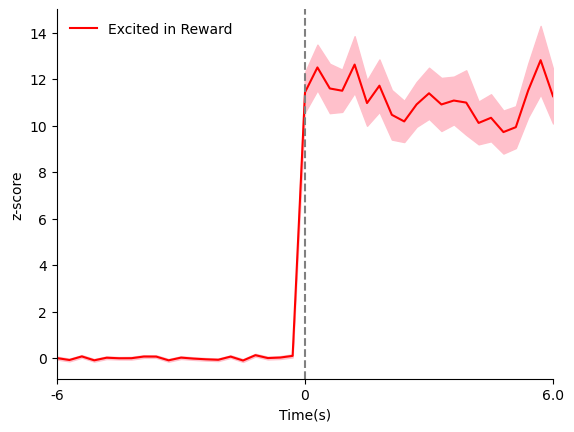

In [11]:
x=np.arange(Bins)
y=excited_reward_mean
err = excited_reward_sem
fig, ax = plt.subplots()
ax.plot(x, y, label = 'Excited in Reward', color = 'red')
ax.fill_between(x, y-err, y+err, color='pink')
ax.set_xlabel('Time(s)')
ax.set_ylabel('z-score')
ax.set_xticks([0,Bins_before,Bins-1])
ax.set_xticklabels([-TimeRange_before,'0',TimeRange_after-0.3])
ax.set_xlim(0, Bins-1)
ax.axvline(Bins_before, color = 'grey', ls = '--')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(loc = 2, framealpha = 0)
len(excited_reward)

43

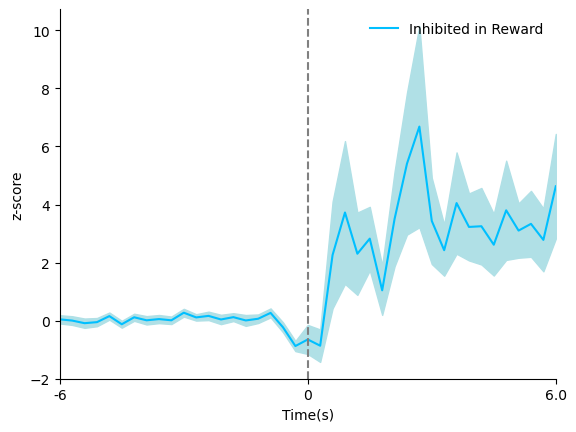

In [12]:
x=np.arange(Bins)
y=inhibited_reward_mean
err = inhibited_reward_sem
fig, ax = plt.subplots()
ax.plot(x, y, label = 'Inhibited in Reward', color = 'deepskyblue', linestyle = '-')
ax.fill_between(x, y-err, y+err, color='powderblue')
ax.set_xlabel('Time(s)')
ax.set_ylabel('z-score')
ax.set_xticks([0,Bins_before,Bins-1])
ax.set_xticklabels([-TimeRange_before,'0',TimeRange_after-0.3])
ax.set_xlim(0, Bins-1)
# ax.set_ylim(-,1)
ax.axvline(Bins_before, color = 'grey', ls = '--')
ax.legend(loc = 0, framealpha = 0)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
len(inhibited_reward)

In [13]:
excited_conflict = conflict_cue_zscore[(conflict_cue_zscore.iloc[:,2+Bins_before:2+Bins_before+int((0.6)/BinSize)]>1.96).any(axis =1)].iloc[:,2:]
inhibited_conflict = conflict_cue_zscore[(conflict_cue_zscore.iloc[:,2+Bins_before:2+Bins_before+int((0.6)/BinSize)]<-1.65).any(axis =1)].iloc[:,2:]

In [14]:
excited_conflict_indices = excited_conflict.index.values
inhibited_conflict_indices = inhibited_conflict.index.values
excited_conflict_mean = excited_conflict.mean(axis=0).astype('float')
excited_conflict_sem = excited_conflict.sem(axis=0).astype('float')
inhibited_conflict_mean = inhibited_conflict.mean(axis=0).astype('float')
inhibited_conflict_sem = inhibited_conflict.sem(axis=0).astype('float')

39

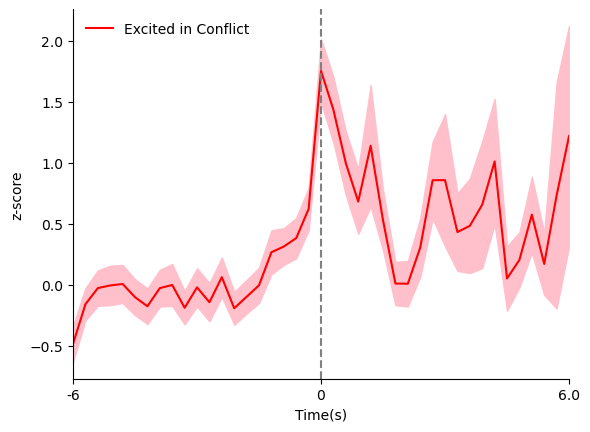

In [15]:
x=np.arange(Bins)
y=excited_conflict_mean
err = excited_conflict_sem
fig, ax = plt.subplots()
ax.plot(x, y, label = 'Excited in Conflict', color = 'red')
ax.fill_between(x, y-err, y+err, color='pink')
ax.set_xlabel('Time(s)')
ax.set_ylabel('z-score')
ax.set_xticks([0,Bins_before,Bins-1])
ax.set_xticklabels([-TimeRange_before,'0',TimeRange_after-0.3])
ax.set_xlim(0, Bins-1)
ax.axvline(Bins_before, color = 'grey', ls = '--')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(loc = 2, framealpha = 0)
len(excited_conflict)

72

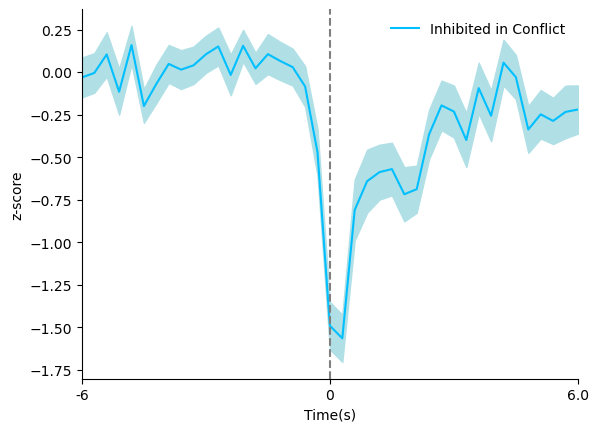

In [16]:
x=np.arange(Bins)
y=inhibited_conflict_mean
err = inhibited_conflict_sem
fig, ax = plt.subplots()
ax.plot(x, y, label = 'Inhibited in Conflict', color = 'deepskyblue', linestyle = '-')
ax.fill_between(x, y-err, y+err, color='powderblue')
ax.set_xlabel('Time(s)')
ax.set_ylabel('z-score')
ax.set_xticks([0,Bins_before,Bins-1])
ax.set_xticklabels([-TimeRange_before,'0',TimeRange_after-0.3])
ax.set_xlim(0, Bins-1)
# ax.set_ylim(-,1)
ax.axvline(Bins_before, color = 'grey', ls = '--')
ax.legend(loc = 0, framealpha = 0)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
len(inhibited_conflict)

279

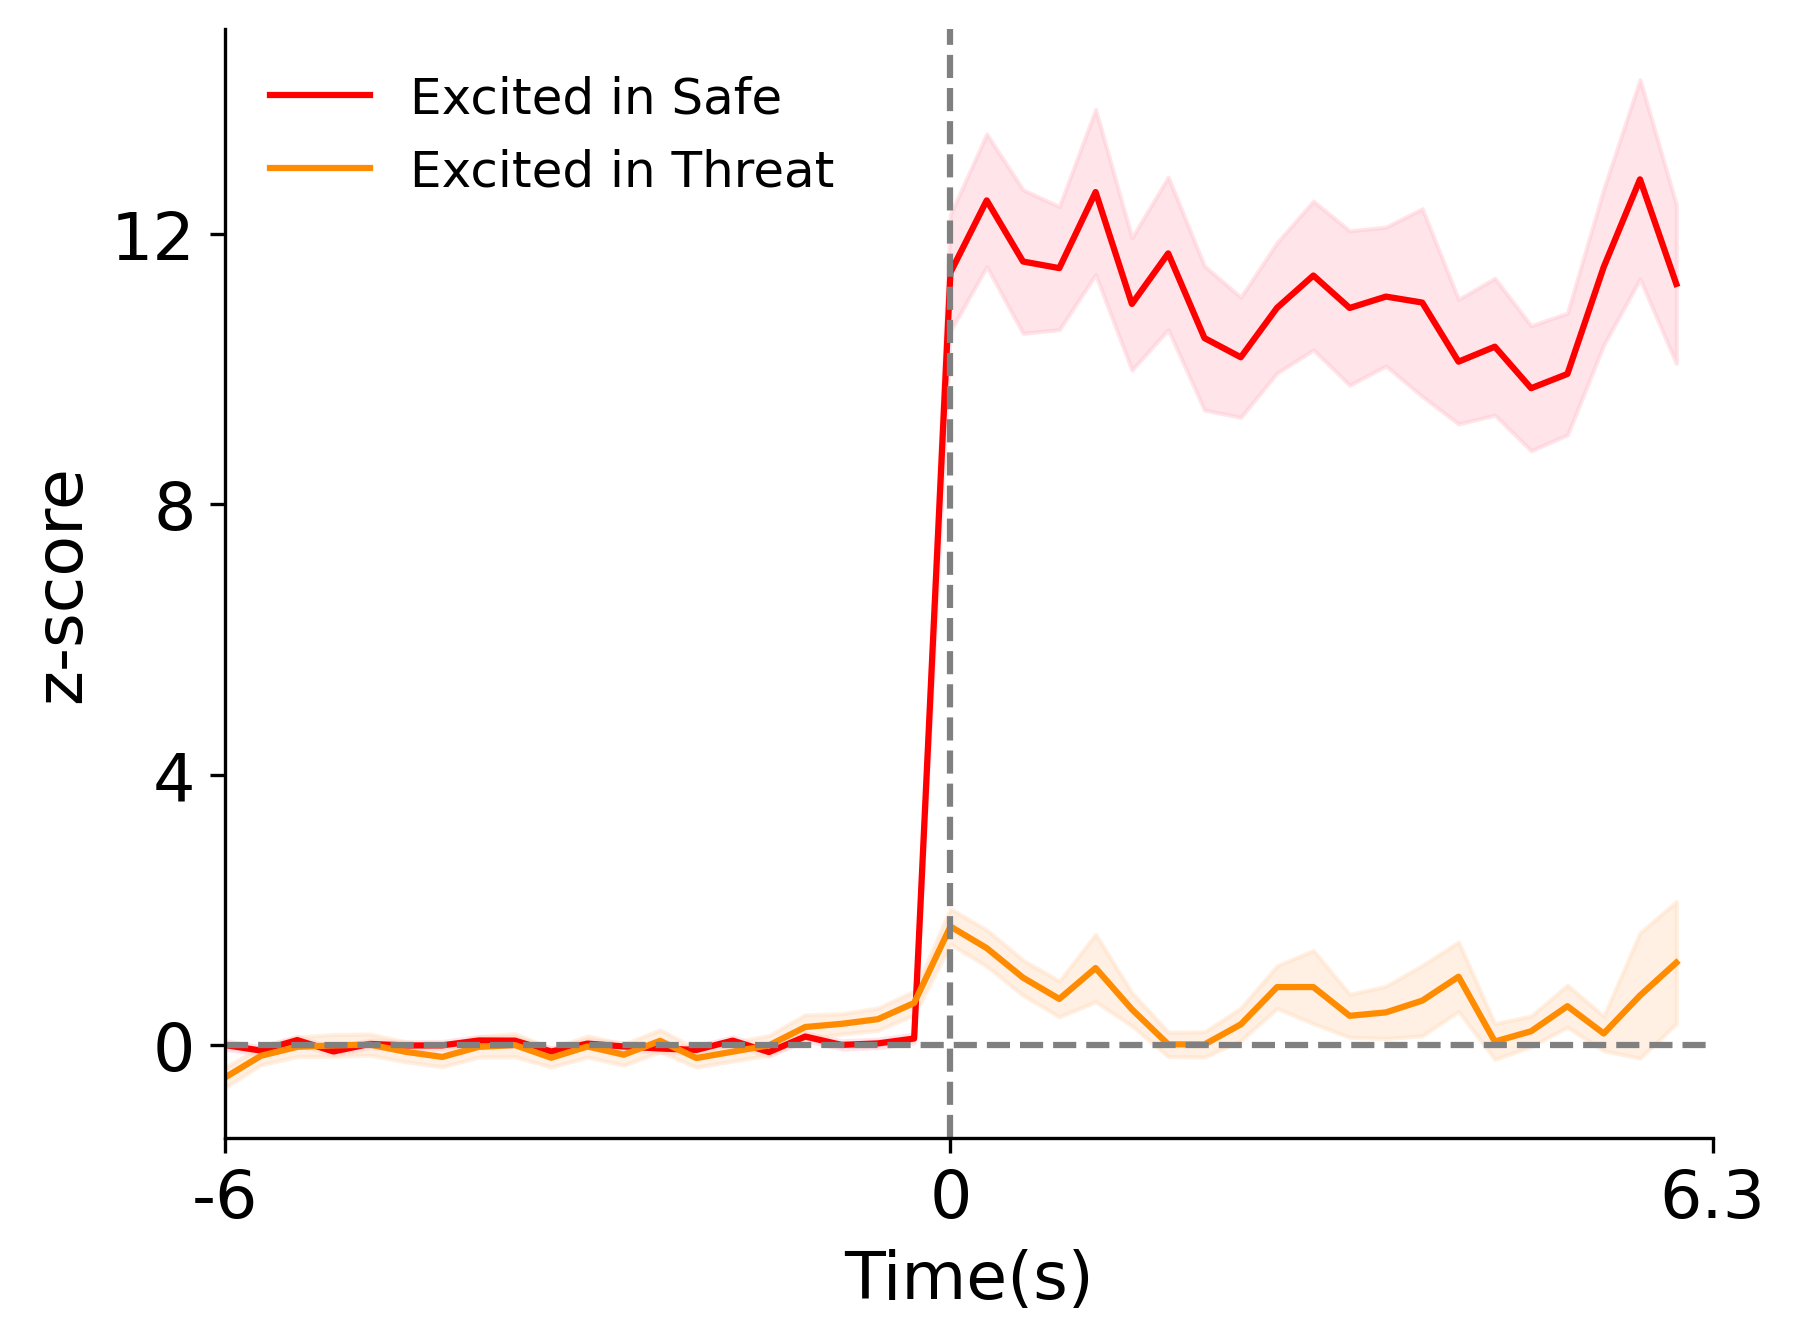

In [17]:
x=np.arange(Bins)
y=excited_reward_mean
z=excited_conflict_mean
erry = excited_reward_sem
errz = excited_conflict_sem
fig, ax = plt.subplots(dpi =300)
ax.tick_params(labelsize = 16)
ax.yaxis.set_major_locator(MaxNLocator(5,integer=True))
ax.plot(x, y, label = 'Excited in Safe', color = 'red')
ax.plot(x, z, label = 'Excited in Threat', color = 'darkorange')
ax.fill_between(x, y-erry, y+erry, color='pink', alpha = 0.4)
ax.fill_between(x, z-errz, z+errz, color='peachpuff', alpha = 0.4)
ax.set_xlabel('Time(s)', fontsize = 16)
ax.set_ylabel('z-score', fontsize = 16)
ax.set_xticks([0,int((Bins/2)),Bins])
ax.set_xticklabels([-TimeRange_before,'0',TimeRange_after])
ax.set_xlim(0, Bins)
# ax.set_ylim(-2, 12)
#ax.set_ylim(0, Bins)
ax.axvline(int((Bins/2)), color = 'grey', ls = '--')
ax.axhline(0, color = 'grey', ls = '--')
ax.legend(loc = 2, framealpha = 0, fontsize = 12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
len(excited_reward)

43

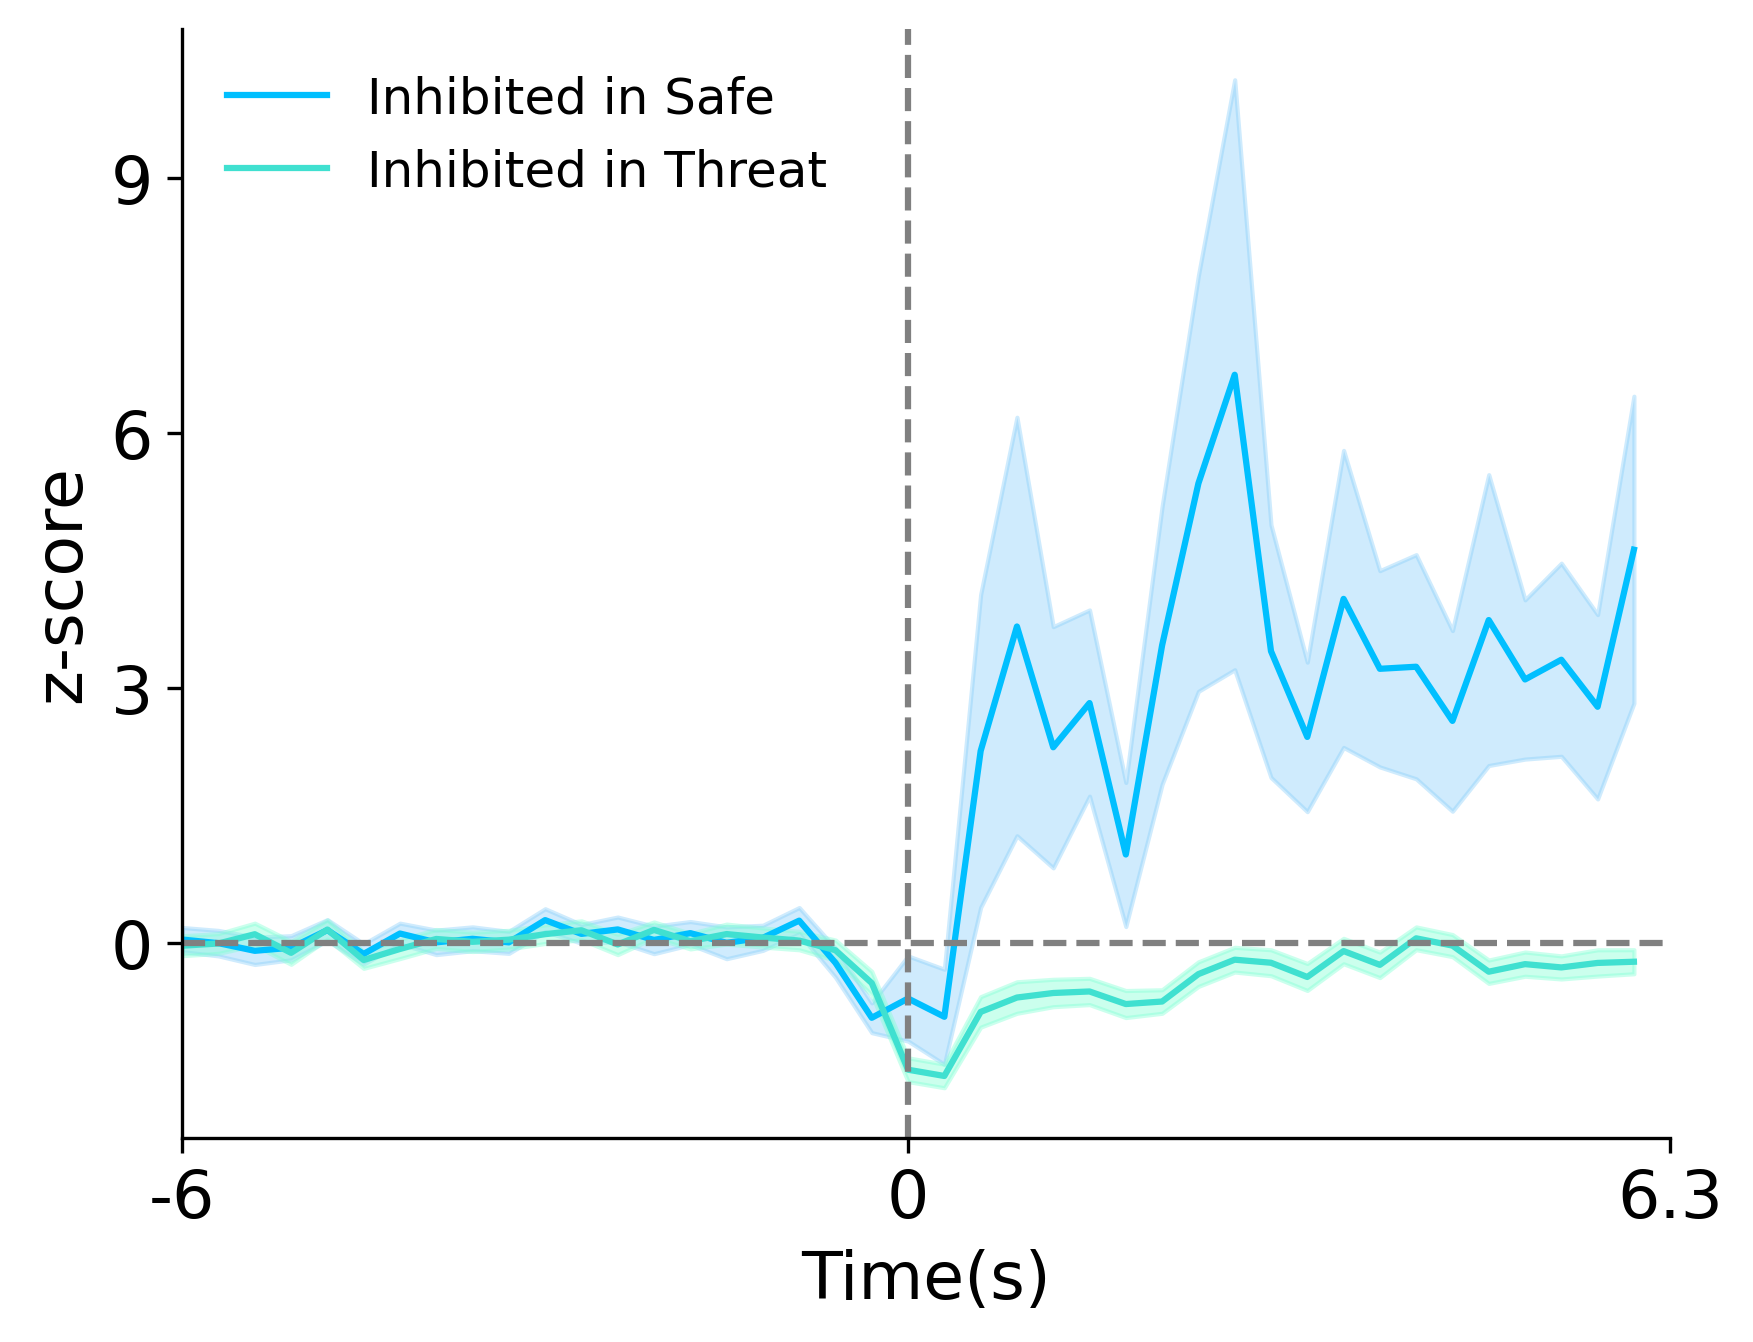

In [18]:
x=np.arange(Bins)
y=inhibited_reward_mean
z=inhibited_conflict_mean
erry = inhibited_reward_sem
errz = inhibited_conflict_sem
fig, ax = plt.subplots(dpi =300)
ax.tick_params(labelsize = 16)
ax.yaxis.set_major_locator(MaxNLocator(5,integer=True))
ax.plot(x, y, label = 'Inhibited in Safe', color = 'deepskyblue')
ax.plot(x, z, label = 'Inhibited in Threat', color = 'turquoise')
ax.fill_between(x, y-erry, y+erry, color='lightskyblue', alpha = 0.4)
ax.fill_between(x, z-errz, z+errz, color='aquamarine', alpha = 0.4)
ax.set_xlabel('Time(s)', fontsize = 16)
ax.set_ylabel('z-score', fontsize = 16)
ax.set_xticks([0,int((Bins/2)),Bins])
ax.set_xticklabels([-TimeRange_before,'0',TimeRange_after])
ax.set_xlim(0, Bins)
# ax.set_ylim(-4, 2)
ax.axvline(int((Bins/2)), color = 'grey', ls = '--')
ax.axhline(0, color = 'grey', ls = '--')
ax.legend(loc = 2, framealpha = 0, fontsize= 12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
len(inhibited_reward)

In [19]:
excited_safe_inthreat_mean = conflict_cue_zscore.iloc[excited_reward_indices, 2:].mean(axis=0)
excited_safe_inthreat_sem =  conflict_cue_zscore.iloc[excited_reward_indices, 2:].sem(axis=0)
inhibited_safe_inthreat_mean = conflict_cue_zscore.iloc[inhibited_reward_indices, 2:].mean(axis=0)
inhibited_safe_inthreat_sem =  conflict_cue_zscore.iloc[inhibited_reward_indices, 2:].sem(axis=0)
excited_threat_insafe_mean = reward_cue_zscore.iloc[excited_conflict_indices, 2:].mean(axis=0)
excited_threat_insafe_sem =  reward_cue_zscore.iloc[excited_conflict_indices, 2:].sem(axis=0)
inhibited_threat_insafe_mean = reward_cue_zscore.iloc[inhibited_conflict_indices, 2:].mean(axis=0)
inhibited_threat_insafe_sem =  reward_cue_zscore.iloc[inhibited_conflict_indices, 2:].sem(axis=0)

279

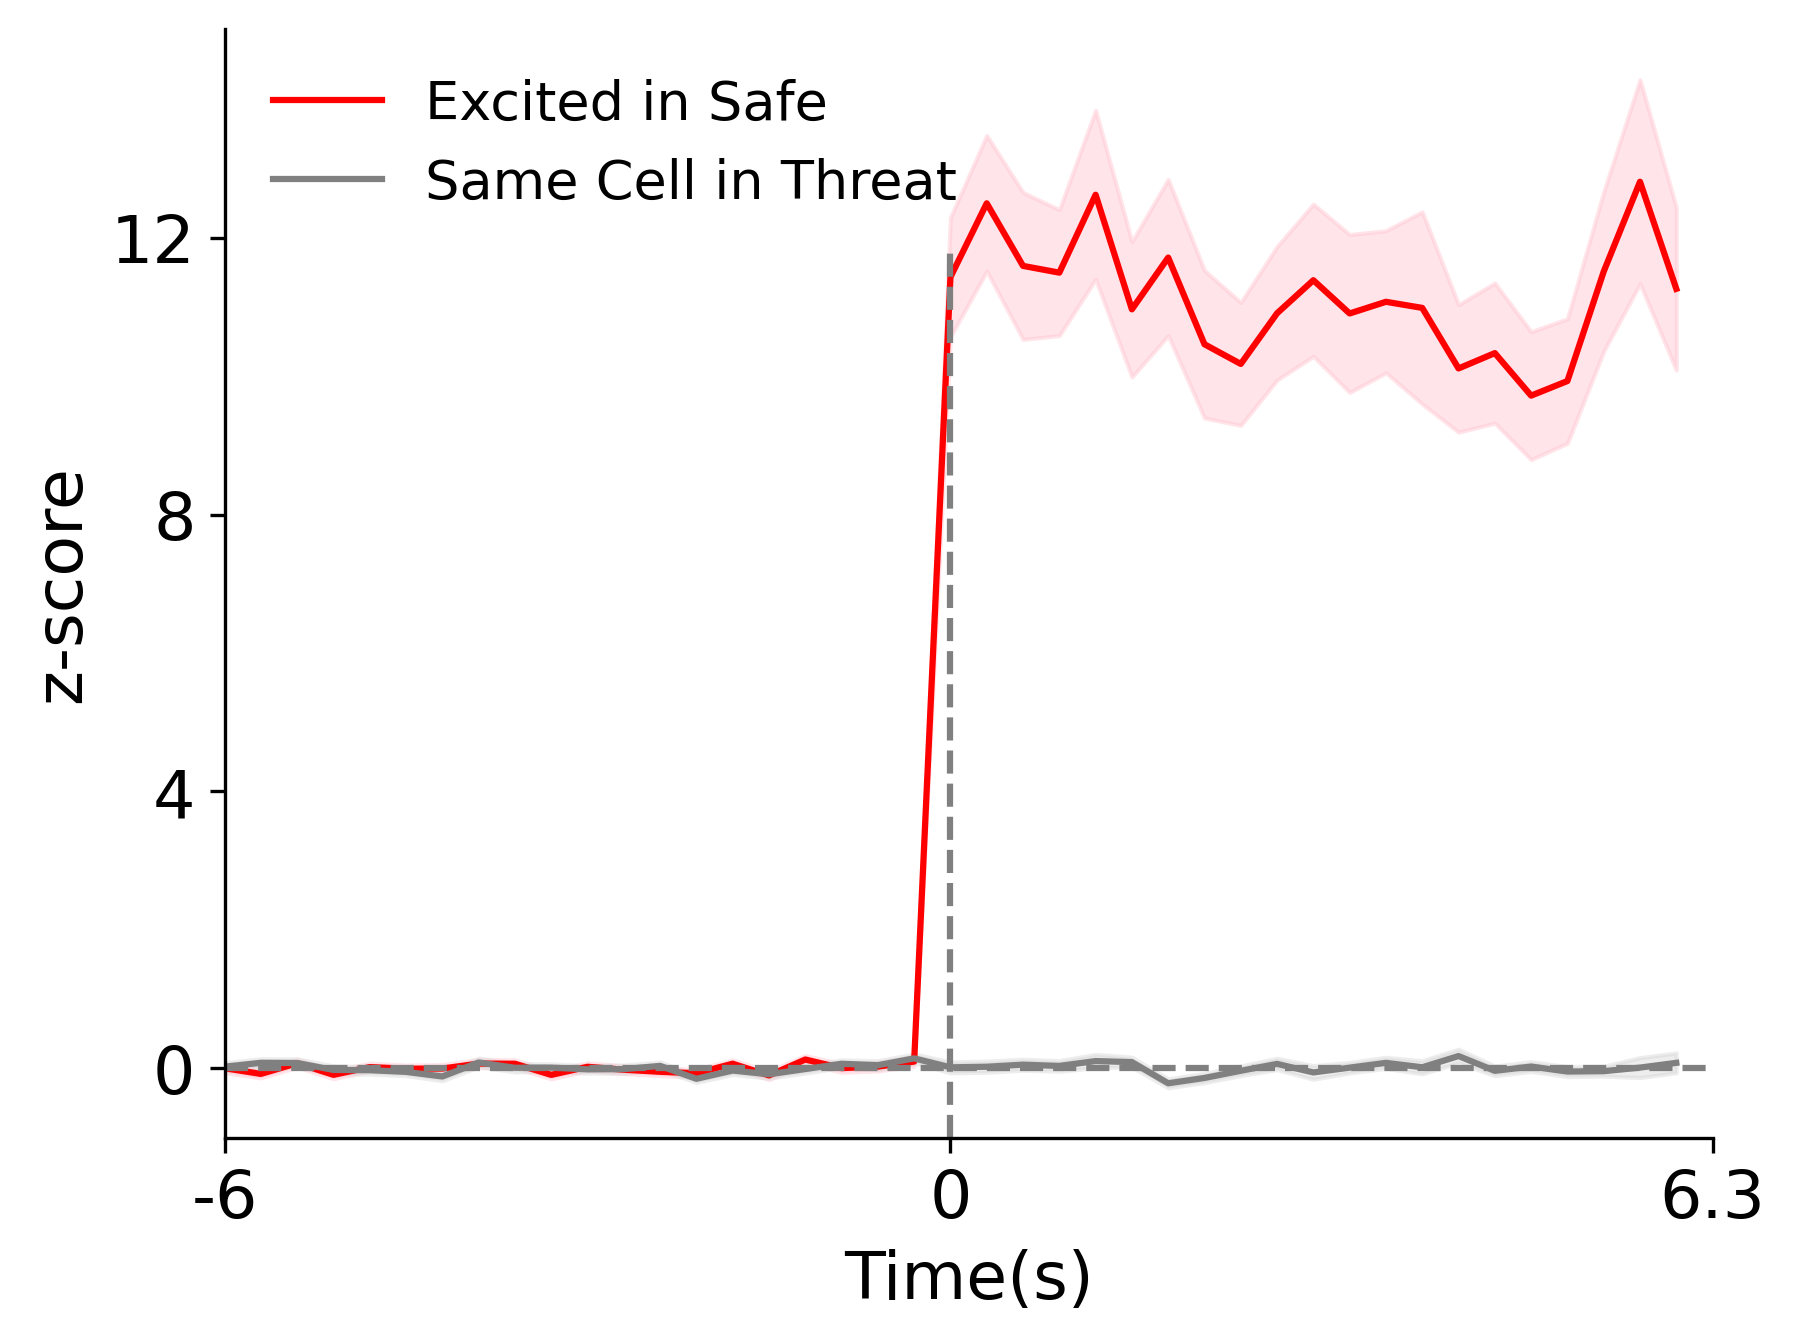

In [20]:
x=np.arange(Bins)
y=excited_reward_mean
z=excited_safe_inthreat_mean
erry = excited_reward_sem
errz = excited_safe_inthreat_sem
fig, ax = plt.subplots(dpi =300)
ax.tick_params(labelsize = 16)
ax.yaxis.set_major_locator(MaxNLocator(5,integer=True))
ax.set_xlabel('Time(s)', fontsize = 16)
ax.set_ylabel('z-score', fontsize = 16)
ax.plot(x, y, label = 'Excited in Safe', color = 'red')
ax.plot(x, z, label = 'Same Cell in Threat', color = 'grey')
ax.fill_between(x, y-erry, y+erry, color='pink', alpha = 0.4)
ax.fill_between(x, z-errz, z+errz, color='lightgrey', alpha = 0.4)
ax.set_xticks([0,int((Bins/2)),Bins])
ax.set_xticklabels([-TimeRange_before,'0',TimeRange_after])
ax.set_xlim(0, Bins)
# ax.set_ylim(-2, 12)
ax.axvline(int((Bins/2)), ymax=0.8, color = 'grey', ls = '--')
ax.axhline(0, color = 'grey', ls = '--')
ax.legend(loc = 2, framealpha = 0, fontsize = 13)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
len(excited_reward)

43

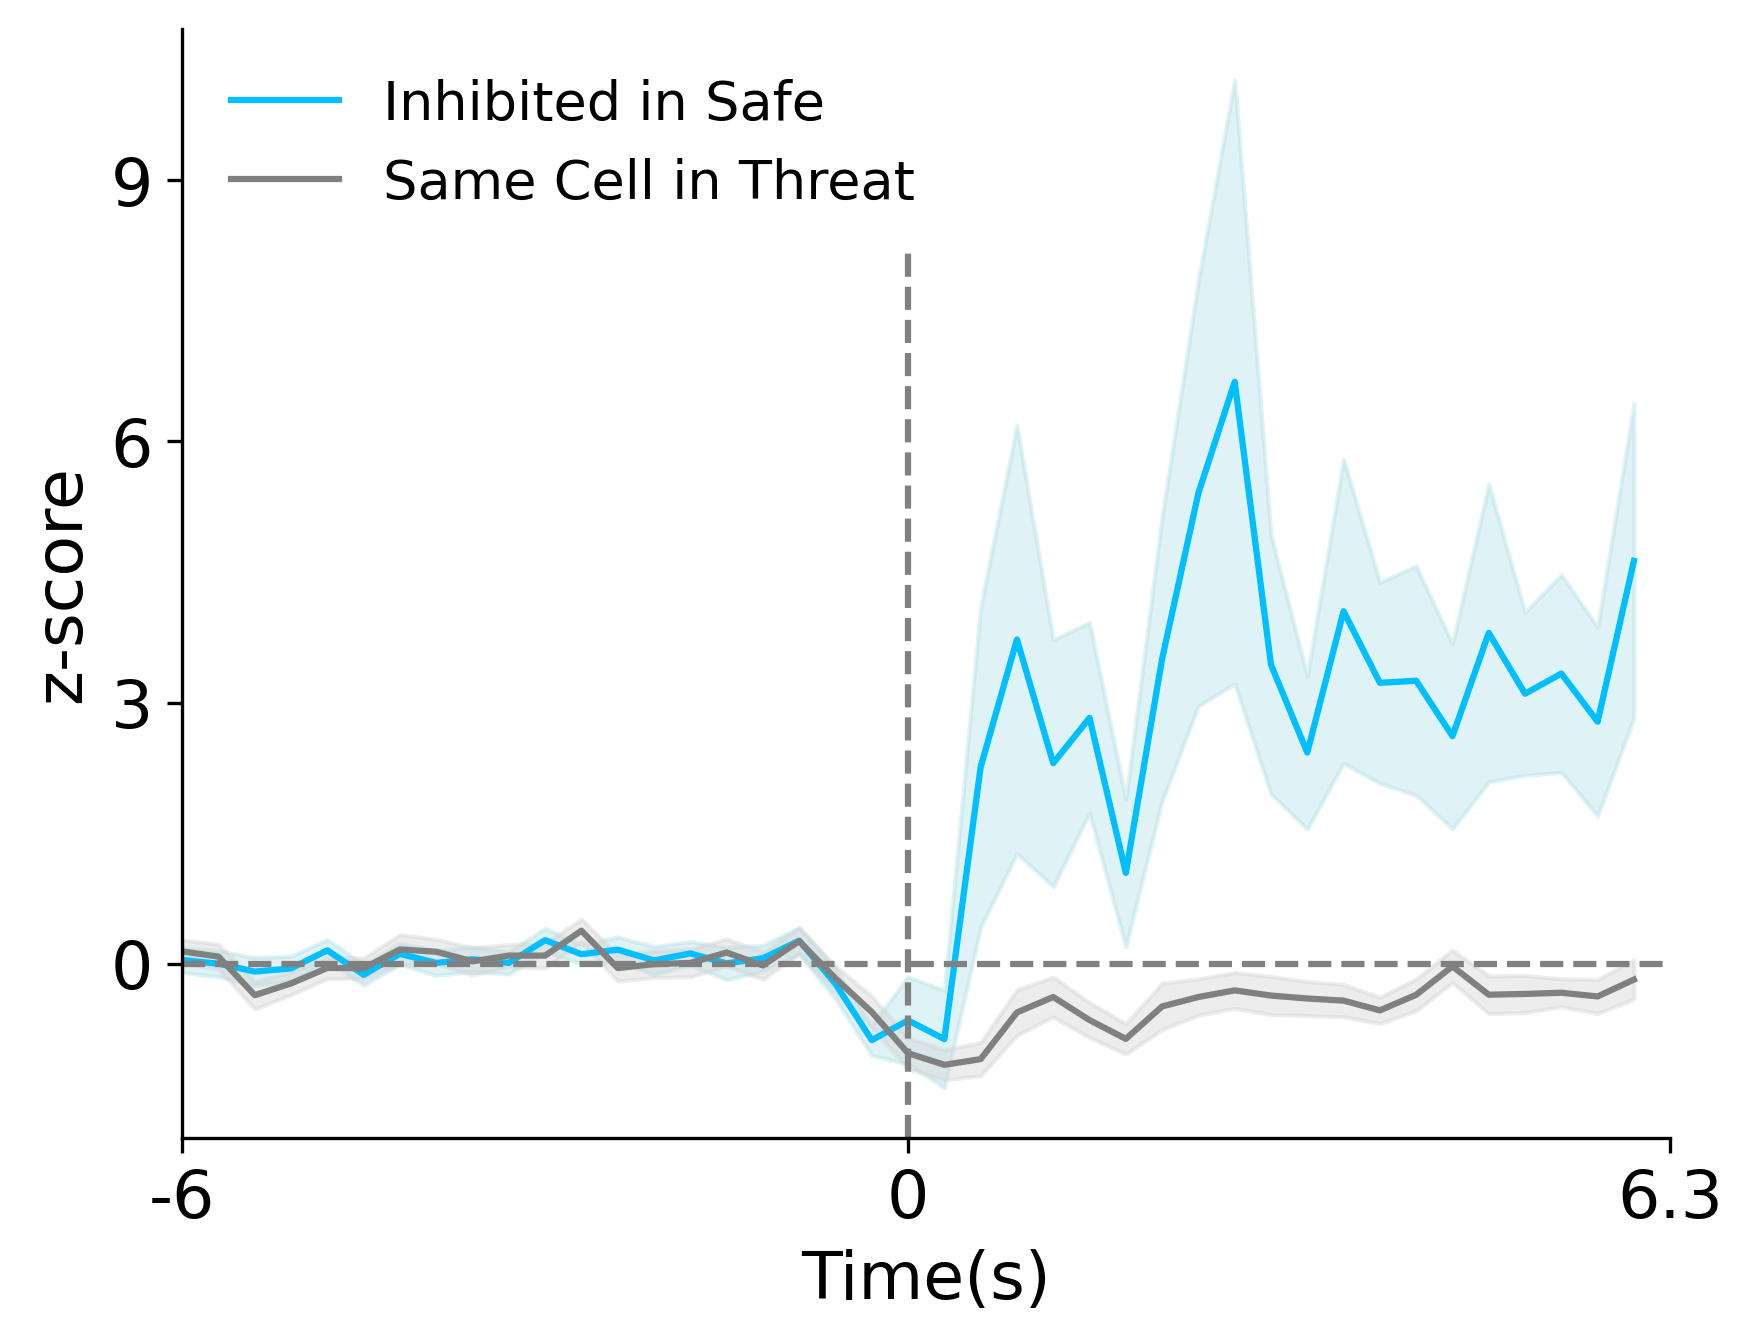

In [21]:
x=np.arange(Bins)
y=inhibited_reward_mean
z=inhibited_safe_inthreat_mean
erry = inhibited_reward_sem
errz = inhibited_safe_inthreat_sem
fig, ax = plt.subplots(dpi =300)
ax.tick_params(labelsize = 16)
ax.yaxis.set_major_locator(MaxNLocator(5,integer=True))
ax.set_xlabel('Time(s)', fontsize = 16)
ax.set_ylabel('z-score', fontsize = 16)
ax.plot(x, y, label = 'Inhibited in Safe', color='deepskyblue')
ax.plot(x, z, label = 'Same Cell in Threat', color='grey')
ax.fill_between(x, y-erry, y+erry, color = 'powderblue', alpha = 0.4)
ax.fill_between(x, z-errz, z+errz, color = 'lightgrey', alpha = 0.4)
ax.set_xlabel('Time(s)')
ax.set_ylabel('z-score')
ax.set_xticks([0,int((Bins/2)),Bins])
ax.set_xticklabels([-TimeRange_before,'0',TimeRange_after])
ax.set_xlim(0, Bins)
# ax.set_ylim(-4, 3)
ax.axvline(int((Bins/2)), ymax=0.8,color = 'grey', ls = '--')
ax.axhline(0, color = 'grey', ls = '--')
ax.legend(loc = 2, framealpha = 0, fontsize = 13)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
len(inhibited_reward)

39

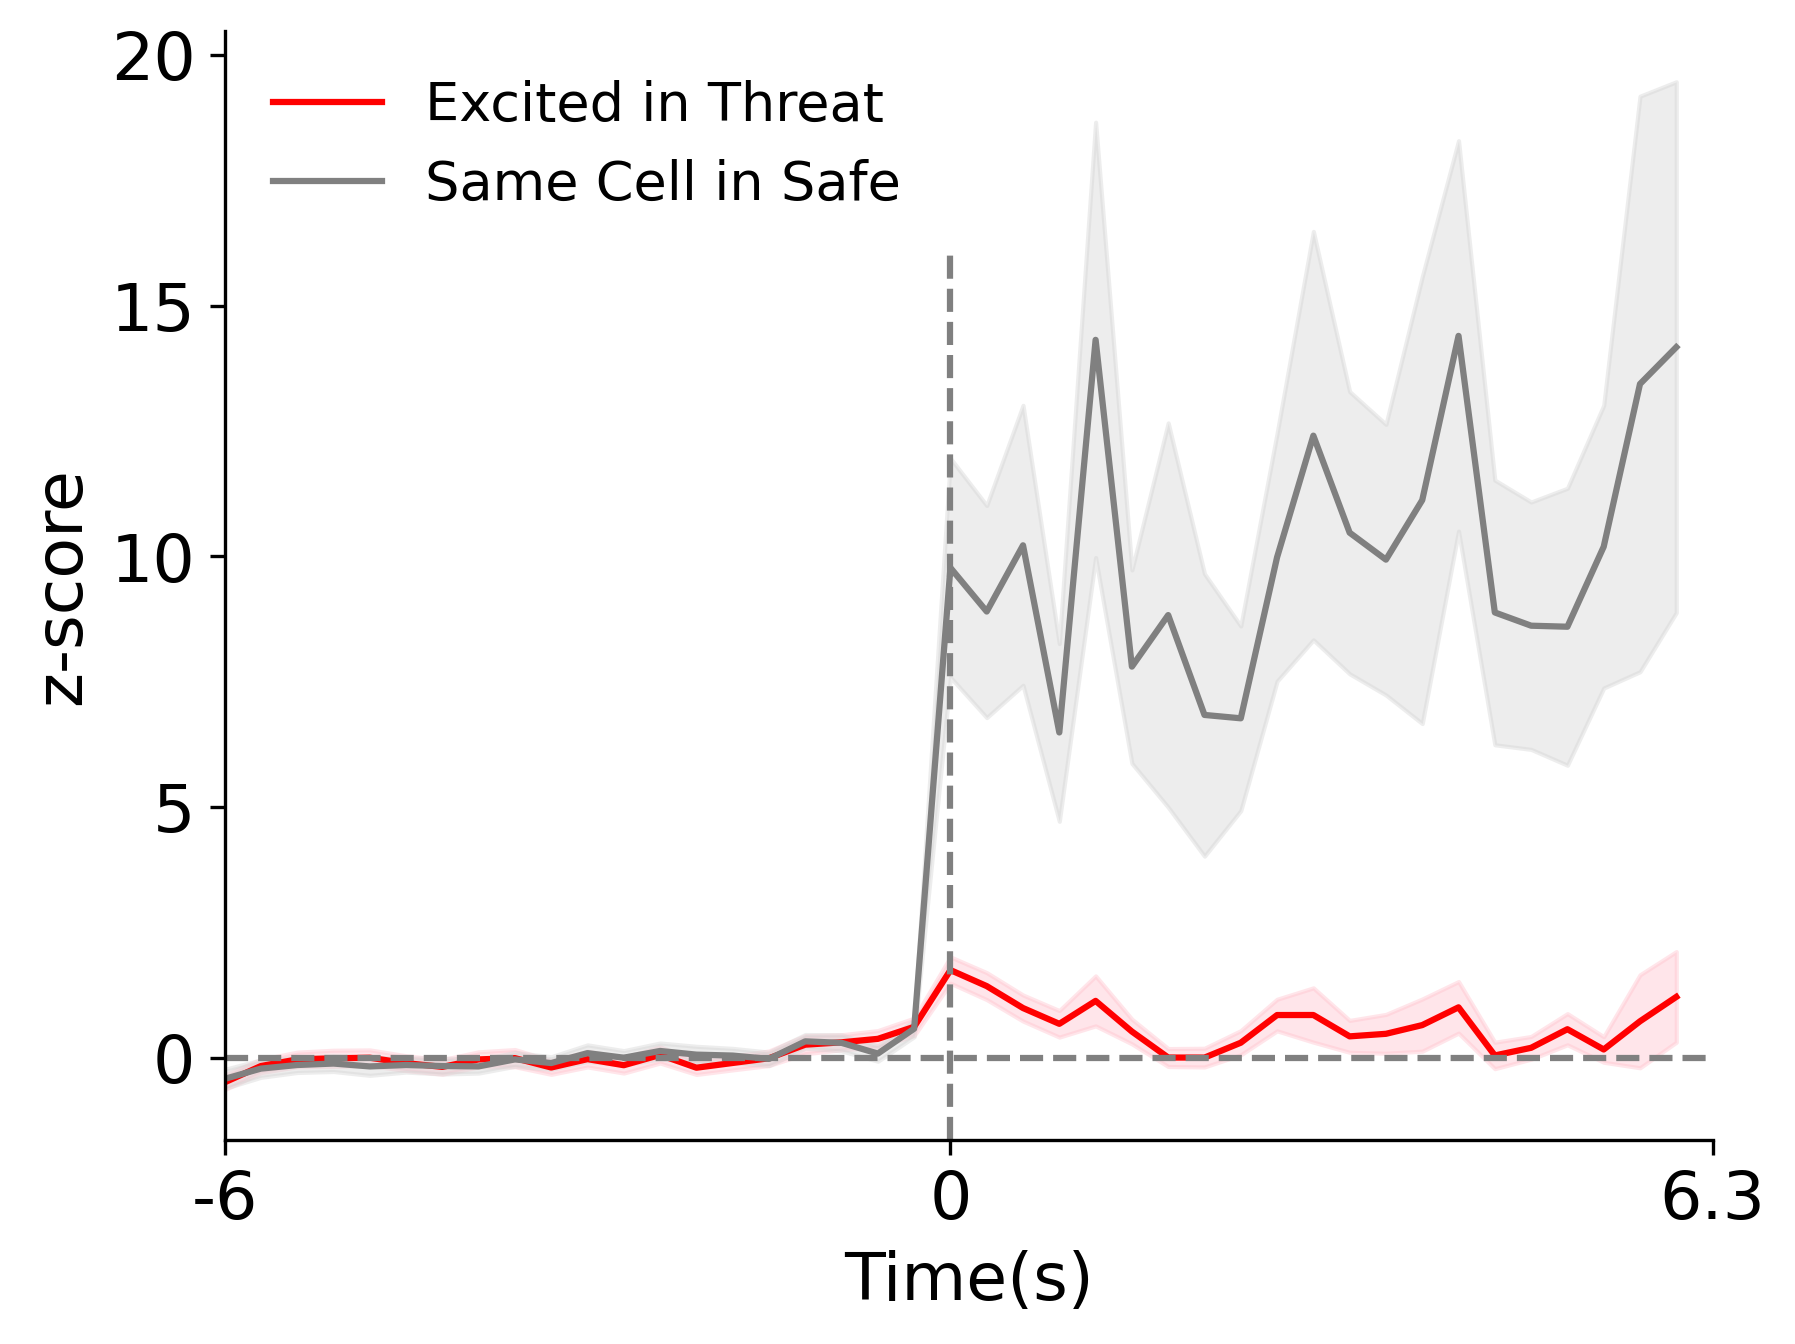

In [22]:
x=np.arange(Bins)
y=excited_conflict_mean
z=excited_threat_insafe_mean
erry = excited_conflict_sem
errz = excited_threat_insafe_sem
fig, ax = plt.subplots(dpi =300)
ax.tick_params(labelsize = 16)
ax.yaxis.set_major_locator(MaxNLocator(5,integer=True))
ax.set_xlabel('Time(s)', fontsize = 16)
ax.set_ylabel('z-score', fontsize = 16)
ax.plot(x, y, label = 'Excited in Threat',color='red')
ax.plot(x, z, label = 'Same Cell in Safe',color='grey')
ax.fill_between(x, y-erry, y+erry, color = 'pink', alpha = 0.4)
ax.fill_between(x, z-errz, z+errz, color = 'lightgrey', alpha = 0.4)
ax.set_xticks([0,int((Bins/2)),Bins])
ax.set_xticklabels([-TimeRange_before,'0',TimeRange_after])
ax.set_xlim(0, Bins)
# ax.set_ylim(-3, 12)
ax.axvline(int((Bins/2)), ymax = 0.8,color = 'grey', ls = '--')
ax.axhline(0, color = 'grey', ls = '--')
ax.legend(loc = 2, framealpha = 0, fontsize = 13)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
len(excited_conflict)

72

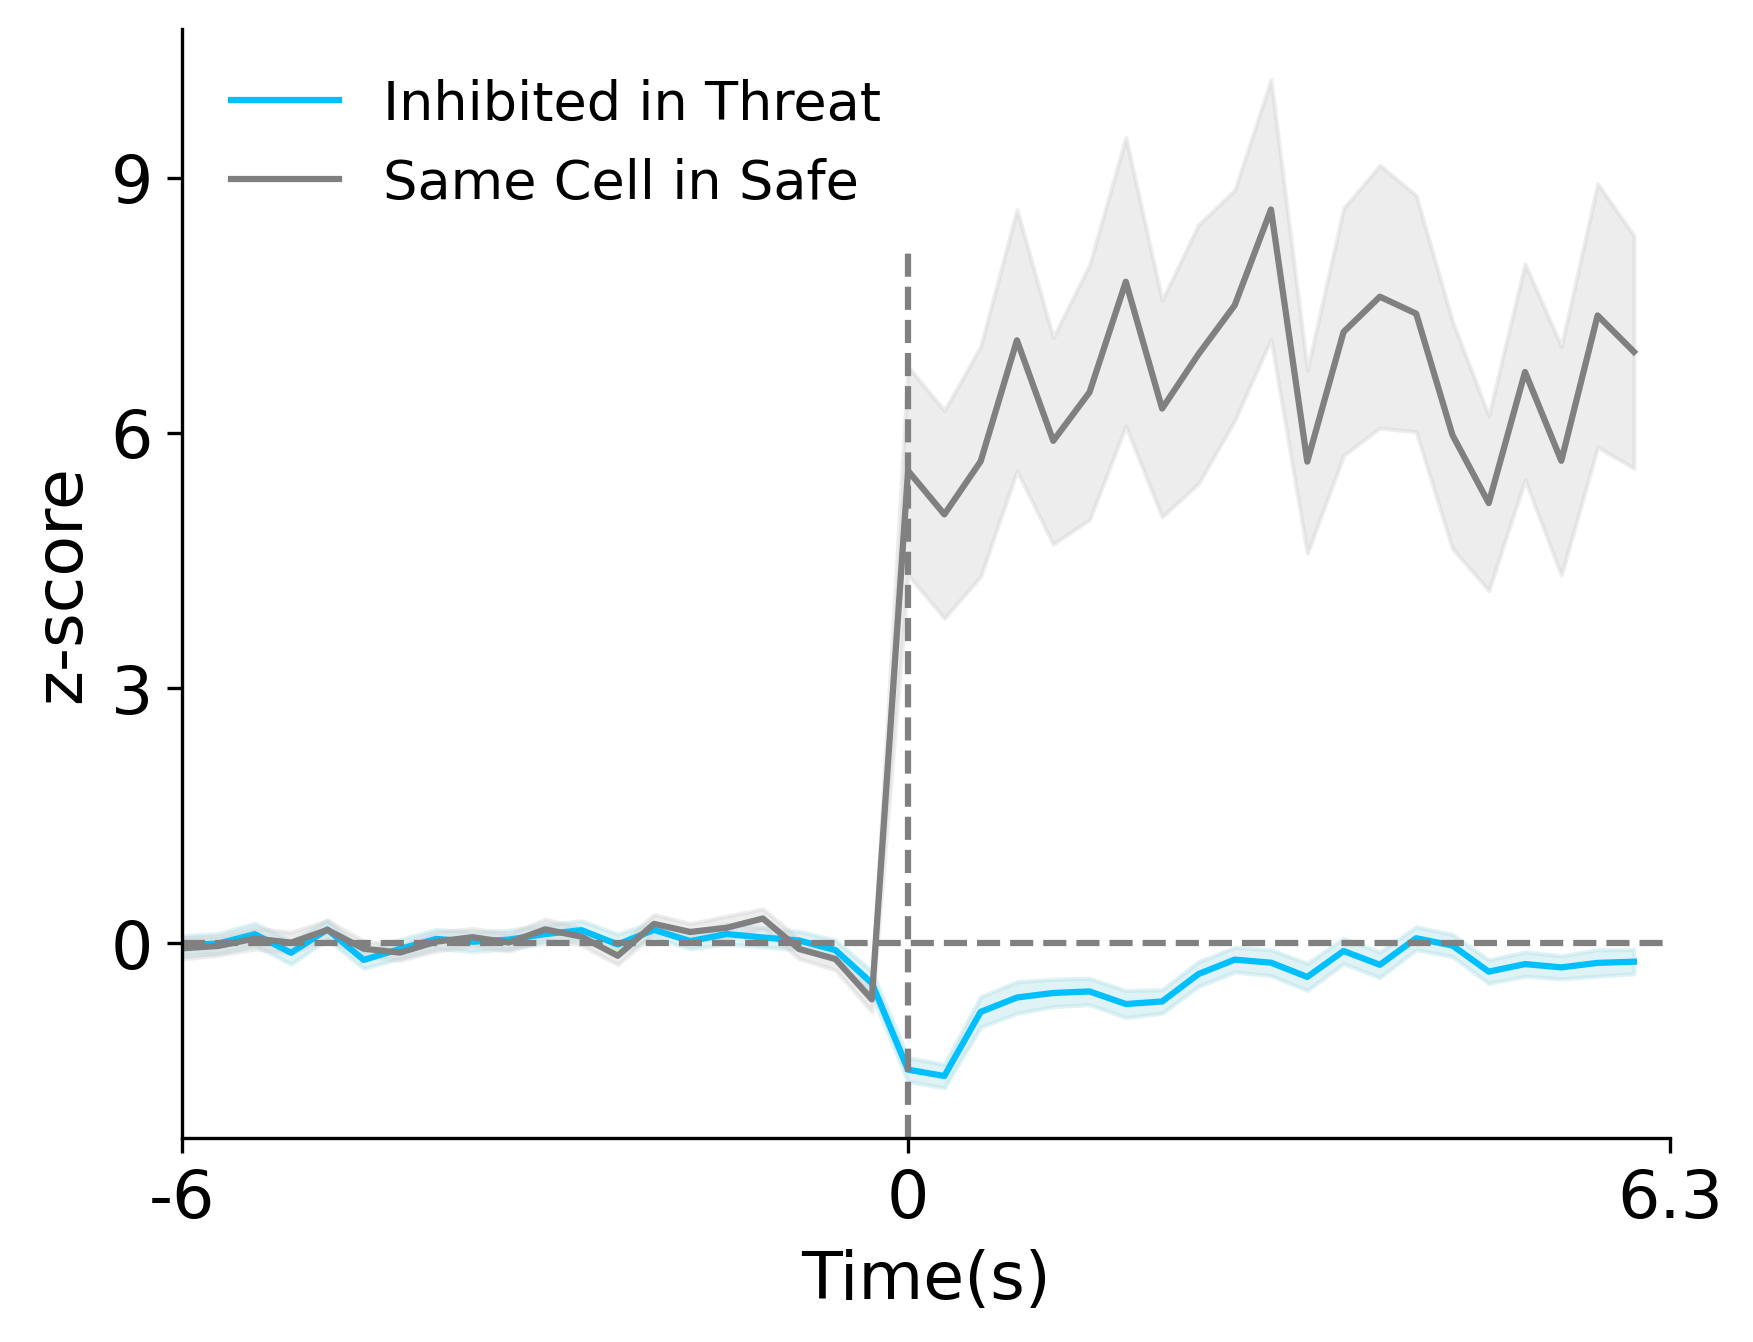

In [23]:
x=np.arange(Bins)
y=inhibited_conflict_mean
z=inhibited_threat_insafe_mean
erry = inhibited_conflict_sem
errz = inhibited_threat_insafe_sem
fig, ax = plt.subplots(dpi =300)
ax.tick_params(labelsize = 16)
ax.yaxis.set_major_locator(MaxNLocator(5,integer=True))
ax.set_xlabel('Time(s)', fontsize = 16)
ax.set_ylabel('z-score', fontsize = 16)
ax.plot(x, y, label = 'Inhibited in Threat',color='deepskyblue')
ax.plot(x, z, label = 'Same Cell in Safe',color='grey')
ax.fill_between(x, y-erry, y+erry, color = 'powderblue', alpha = 0.4)
ax.fill_between(x, z-errz, z+errz, color = 'lightgrey', alpha = 0.4)
ax.set_xticks([0,int((Bins/2)),Bins])
ax.set_xticklabels([-TimeRange_before,'0',TimeRange_after])
ax.set_xlim(0, Bins)
ax.axvline(int((Bins/2)), ymax = 0.8, color = 'grey', ls = '--')
ax.axhline(0, color = 'grey', ls = '--')
ax.legend(loc = 2, framealpha = 0, fontsize = 13)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
len(inhibited_conflict)

In [24]:
tracethreat_mean = conflict_cue_zscore.iloc[:,2:].mean(axis=0)#.dropna(axis=0))
tracethreat_sem = conflict_cue_zscore.iloc[:,2:].sem(axis=0)#.dropna(axis=0))
tracesafe_mean = reward_cue_zscore.iloc[:,2:].mean(axis=0)#.dropna(axis=0)
tracesafe_sem = reward_cue_zscore.iloc[:,2:].sem(axis=0)#.dropna(axis=0)

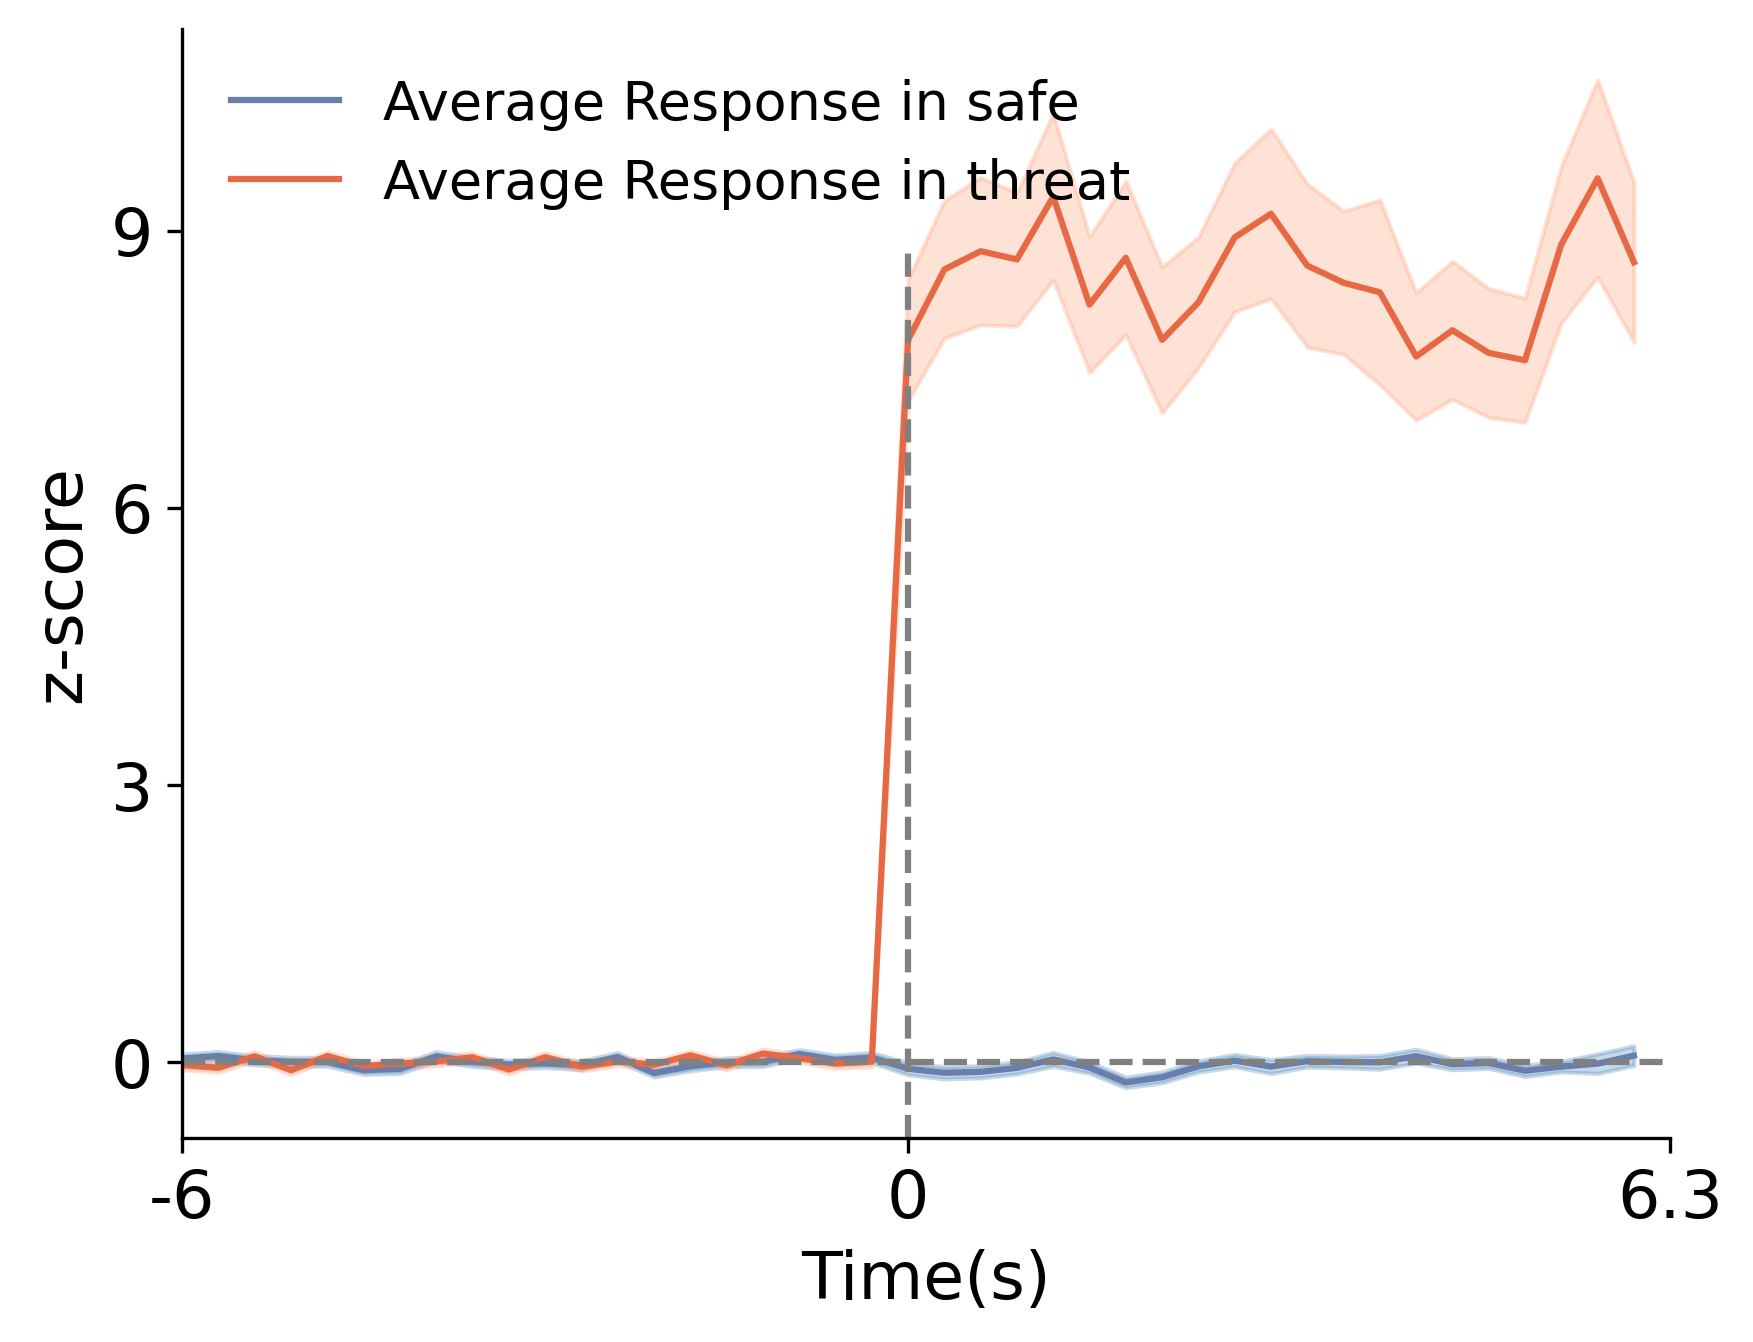

In [25]:
x=np.arange(Bins)
y=tracethreat_mean
z=tracesafe_mean
erry = tracethreat_sem
errz = tracesafe_sem
fig, ax = plt.subplots(dpi =300)
ax.tick_params(labelsize = 16)
ax.yaxis.set_major_locator(MaxNLocator(5,integer=True))
ax.set_xlabel('Time(s)', fontsize = 16)
ax.set_ylabel('z-score', fontsize = 16)
ax.plot(x, y, label = 'Average Response in safe', color = '#687eac')
ax.plot(x, z, label = 'Average Response in threat', color = '#e66943')
ax.fill_between(x, y-erry, y+erry, color='steelblue', alpha = 0.3)
ax.fill_between(x, z-errz, z+errz, color='lightsalmon', alpha = 0.3)
ax.set_xticks([0,int((Bins/2)),Bins])
ax.set_xticklabels([-TimeRange_before,'0',TimeRange_after])
ax.set_xlim(0, Bins)
# ax.set_ylim(-2,2)
ax.tick_params(labelsize = 16)
ax.axvline(int((Bins/2)), color = 'grey', ls = '--', ymax = 0.8)
ax.axhline(0, color = 'grey', ls = '--')
ax.legend(loc = 2, framealpha = 0, fontsize = 13)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#len(excited_safe)

## Phototagged

In [26]:
photoid = pd.read_csv(os.path.join(base_dir,"Phototag ID's updated by code.csv"), index_col =0)
photoid.index = ["Unit", "PL GABA", "PL-PVT", "PL-NAc"]

In [27]:
PhotoTag = pd.DataFrame(columns=['AnimalID', 'NeuronID', 'Unit_Type'])

photoid = photoid.reset_index()
# Iterate over the columns in the input DataFrame
current_animal_id = None
for col in photoid.columns[1:]:
    if 'Unnamed' not in col:
        current_animal_id = col
    for row_idx in range(1, photoid.shape[0]):
        unit_id = photoid.loc[0, col]
        unit_type = photoid.loc[row_idx, 'index']
        value = photoid.loc[row_idx, col]

        if value == "1":
            new_row = pd.DataFrame({'AnimalID': [current_animal_id], 'NeuronID': [unit_id], 'Unit_Type': [unit_type]})
            PhotoTag = pd.concat([PhotoTag, new_row], ignore_index=True)

    # Check if the current column has all 0s
    if pd.to_numeric(photoid.loc[1:, col], errors='coerce').sum() == 0:
        new_row = pd.DataFrame({'AnimalID': [current_animal_id], 'NeuronID': [unit_id], 'Unit_Type': ['Unidentified']})
        PhotoTag = pd.concat([PhotoTag, new_row], ignore_index=True)


In [28]:
PhotoTag

AnimalID NeuronID     Unit_Type
0        1U1   SPK01a  Unidentified
1        1U1   SPK02a  Unidentified
2        1U1   SPK08a  Unidentified
3        1U1   SPK09a  Unidentified
4        1U1   SPK12a  Unidentified
..       ...      ...           ...
408      1D6   SPK14a  Unidentified
409      1D6   SPK16a        PL-NAc
410      1D6   SPK21a  Unidentified
411      1D6   SPK29a        PL-NAc
412      1D6   SPK30a        PL-NAc

[413 rows x 3 columns]

In [29]:
reward_cue_zscore.merge(PhotoTag, on=['AnimalID', 'NeuronID'], how = 'inner', indicator=True)

AnimalID NeuronID         0         1         2         3         4  \
0        1U1   SPK01a -0.719492 -1.615908 -0.436413  0.365643  0.695902   
1        1U1   SPK02a  0.837318  0.005938 -0.944209 -2.013125 -0.112830   
2        1U1   SPK08a  0.076476  1.253032  0.311787  0.429443 -0.394146   
3        1U1   SPK09a -0.567224 -0.043633 -1.614408  0.305429 -0.392694   
4        1U1   SPK12a  0.160214  0.160214 -0.068663 -1.213051  0.846847   
..       ...      ...       ...       ...       ...       ...       ...   
396      4U5   SPK27a  1.268415  0.504821  1.225993  0.123024  0.844196   
397      4U5   SPK28a  0.420952 -1.390740 -0.857889 -0.111899  0.527522   
398      4U5   SPK29a  1.047298 -0.005541  0.881061 -0.227192 -0.116366   
399      4U5   SPK31a  0.985606 -0.071749  0.079302  1.665334  0.910080   
400      4U5   SPK31b  0.248874 -0.995495  0.782175 -0.165916  0.367385   

            5         6         7  ...         33         34         35  \
0   -0.389233  1.356419 -0.389233  ...   6.310296   3.573869  14.094961   
1    0.124707  0.837318 -1.062978  ...   0.005938   0.005938   3.568992   
2    1.135377  2.547244 -1.335391  ...   0.076476   7.018158   0.194132   
3   -0.043633 -0.741755 -0.567224  ...  12.173508  11.300855  -0.392694   
4    1.304602  1.190163  0.160214  ...  31.516426  -1.213051   0.160214   
..        ...       ...       ...  ...        ...        ...        ...   
396  0.123024 -0.046664  0.716930  ...  -1.446587  -1.489009  -1.743540   
397 -0.325039  0.420952  2.019503  ...  17.685306  -1.497310  16.939315   
398 -0.338017 -1.002968 -1.224619  ...  -1.612507  -2.609934  -3.441124   
399  0.079302  0.003776  1.363233  ...  -2.186459   4.459772  -1.355680   
400  0.485897  1.730266 -0.047405  ...  -0.936240  -0.758473  -1.469541   

            36         37         38         39         40     Unit_Type  \
0     2.158475  -0.577952   3.998487  -1.380009   0.224104  Unidentified   
1    12.714162   0.124707  21.146721   7.844656  20.909184  Unidentified   
2     8.077059  90.788967  25.960715   8.077059   8.547682  Unidentified   
3     0.654490  -0.218163  -0.741755  13.569752   2.050734  Unidentified   
4    25.222296  48.911113   7.255415  16.868269  14.465055  Unidentified   
..         ...        ...        ...        ...        ...           ...   
396  -1.743540  -2.125337  -1.658696  -1.785962  -1.531430        PL-PVT   
397   0.847232   9.692549   0.420952   1.593223   1.486653  Unidentified   
398   1.047298  -1.557095   7.031861   6.311497   1.989313        PL-PVT   
399  -1.204629   4.082145  -2.186459  10.652851   4.837399        PL-PVT   
400  -0.462194   3.626448  -0.817728  -0.639961  -0.580706  Unidentified   

     _merge  
0      both  
1      both  
2      both  
3      both  
4      both  
..      ...  
396    both  
397    both  
398    both  
399    both  
400    both  

[401 rows x 45 columns]

In [30]:
reward_cue_zscore_tagged =  reward_cue_zscore.merge(PhotoTag, on=['AnimalID', 'NeuronID'], how = 'inner', indicator=True)
columns = ['AnimalID', 'NeuronID', 'Unit_Type', '_merge'] + [col for col in reward_cue_zscore_tagged.columns if col not in ['AnimalID', 'NeuronID', 'Unit_Type', '_merge']]
reward_cue_zscore_tagged = reward_cue_zscore_tagged[columns]
reward_cue_zscore_tagged

AnimalID NeuronID     Unit_Type _merge         0         1         2  \
0        1U1   SPK01a  Unidentified   both -0.719492 -1.615908 -0.436413   
1        1U1   SPK02a  Unidentified   both  0.837318  0.005938 -0.944209   
2        1U1   SPK08a  Unidentified   both  0.076476  1.253032  0.311787   
3        1U1   SPK09a  Unidentified   both -0.567224 -0.043633 -1.614408   
4        1U1   SPK12a  Unidentified   both  0.160214  0.160214 -0.068663   
..       ...      ...           ...    ...       ...       ...       ...   
396      4U5   SPK27a        PL-PVT   both  1.268415  0.504821  1.225993   
397      4U5   SPK28a  Unidentified   both  0.420952 -1.390740 -0.857889   
398      4U5   SPK29a        PL-PVT   both  1.047298 -0.005541  0.881061   
399      4U5   SPK31a        PL-PVT   both  0.985606 -0.071749  0.079302   
400      4U5   SPK31b  Unidentified   both  0.248874 -0.995495  0.782175   

            3         4         5  ...         31         32         33  \
0    0.365643  0.695902 -0.389233  ...   1.733857   9.282623   6.310296   
1   -2.013125 -0.112830  0.124707  ...   8.557266   7.844656   0.005938   
2    0.429443 -0.394146  1.135377  ...   9.135960  16.077642   0.076476   
3    0.305429 -0.392694 -0.043633  ...  -1.963469  11.824447  12.173508   
4   -1.213051  0.846847  1.304602  ...  40.785963  33.461884  31.516426   
..        ...       ...       ...  ...        ...        ...        ...   
396  0.123024  0.844196  0.123024  ...   1.607790  -1.998071  -1.446587   
397 -0.111899  0.527522 -0.325039  ...   9.692549   7.454578  17.685306   
398 -0.227192 -0.116366 -0.338017  ...   2.210963   0.160697  -1.612507   
399  1.665334  0.910080  0.079302  ...   4.006620  -2.261984  -2.186459   
400 -0.165916  0.367385  0.485897  ...  -0.580706  -1.825075  -0.936240   

            34         35         36         37         38         39  \
0     3.573869  14.094961   2.158475  -0.577952   3.998487  -1.380009   
1     0.005938   3.568992  12.714162   0.124707  21.146721   7.844656   
2     7.018158   0.194132   8.077059  90.788967  25.960715   8.077059   
3    11.300855  -0.392694   0.654490  -0.218163  -0.741755  13.569752   
4    -1.213051   0.160214  25.222296  48.911113   7.255415  16.868269   
..         ...        ...        ...        ...        ...        ...   
396  -1.489009  -1.743540  -1.743540  -2.125337  -1.658696  -1.785962   
397  -1.497310  16.939315   0.847232   9.692549   0.420952   1.593223   
398  -2.609934  -3.441124   1.047298  -1.557095   7.031861   6.311497   
399   4.459772  -1.355680  -1.204629   4.082145  -2.186459  10.652851   
400  -0.758473  -1.469541  -0.462194   3.626448  -0.817728  -0.639961   

            40  
0     0.224104  
1    20.909184  
2     8.547682  
3     2.050734  
4    14.465055  
..         ...  
396  -1.531430  
397   1.486653  
398   1.989313  
399   4.837399  
400  -0.580706  

[401 rows x 45 columns]

In [31]:
(reward_cue_zscore_tagged._merge != 'both').any()

False

In [32]:
conflict_cue_zscore_tagged = conflict_cue_zscore.merge(PhotoTag, on=['AnimalID', 'NeuronID'], how = 'inner', indicator=True)
columns = ['AnimalID', 'NeuronID', 'Unit_Type', '_merge'] + [col for col in conflict_cue_zscore_tagged.columns if col not in ['AnimalID', 'NeuronID', 'Unit_Type', '_merge']]
conflict_cue_zscore_tagged = conflict_cue_zscore_tagged[columns]
conflict_cue_zscore_tagged

AnimalID NeuronID     Unit_Type _merge         0         1         2  \
0        1U1   SPK01a  Unidentified   both -0.741128 -0.853420 -1.078004   
1        1U1   SPK02a  Unidentified   both  1.201574  0.167962 -0.865650   
2        1U1   SPK08a  Unidentified   both  0.757354  0.441790  0.441790   
3        1U1   SPK09a  Unidentified   both  1.514563  1.055605 -1.239188   
4        1U1   SPK12a  Unidentified   both  0.052679  0.755065  0.579469   
..       ...      ...           ...    ...       ...       ...       ...   
396      4U5   SPK27a        PL-PVT   both  1.544090  0.844219  1.894025   
397      4U5   SPK28a  Unidentified   both  1.830123 -1.220082 -0.266893   
398      4U5   SPK29a        PL-PVT   both  2.160103  0.814244  1.890931   
399      4U5   SPK31a        PL-PVT   both  0.730435  1.241229 -0.393311   
400      4U5   SPK31b  Unidentified   both  0.107045 -0.695795  0.642273   

            3         4         5  ...        31        32        33  \
0   -1.190296  0.494085 -1.302588  ... -0.404251 -0.741128  0.269501   
1   -0.090441  0.684768  0.297163  ... -1.124053 -1.382456 -0.478045   
2   -0.189338  2.019610  0.757354  ...  0.757354 -0.504903 -2.082723   
3    0.596646  0.137688 -0.780230  ... -2.157106 -0.780230 -1.239188   
4   -0.825304  0.403872  0.228276  ...  0.052679 -0.122918 -1.527690   
..        ...       ...       ...  ...       ...       ...       ...   
396  0.056864 -0.118103 -0.293071  ... -2.042747 -1.605328 -1.955264   
397  0.495658  0.686296 -0.266893  ...  2.211398  0.686296  2.783312   
398  0.948830  0.679659 -0.531614  ... -1.473715 -0.397028 -1.204543   
399  0.730435 -0.699787 -0.291152  ... -1.925692 -2.027851 -1.721375   
400 -0.695795 -0.428182 -0.695795  ... -0.428182 -1.498636 -0.428182   

           34        35        36        37        38        39        40  
0    0.044917 -0.516543 -2.537800 -1.527172 -0.291959 -1.190296  0.044917  
1    0.555566  1.589178 -0.090441  0.297163  2.235186 -0.348844  1.589178  
2   -0.504903 -0.189338  0.441790 -0.189338  0.126226 -1.451595  1.072918  
3   -1.239188  0.596646 -1.239188  0.137688  0.137688 -0.780230 -1.239188  
4    0.403872 -0.122918  1.106258 -1.176497 -0.298514 -0.122918 -1.000900  
..        ...       ...       ...       ...       ...       ...       ...  
396 -1.342877 -1.430361 -1.955264 -2.655134 -2.567650 -2.305199 -1.955264  
397 -0.266893  0.686296  2.020761  1.448847  0.495658  1.830123  2.020761  
398 -1.069958 -0.262442 -2.415816  0.141315 -0.531614 -0.666200 -0.531614  
399 -0.801946 -1.312740 -0.495470 -1.414898 -1.108422 -1.517057 -1.823533  
400 -0.294375 -0.294375  1.311307 -0.026761  1.177500  1.043693  1.445113  

[401 rows x 45 columns]

In [33]:
(conflict_cue_zscore_tagged._merge != 'both').any()

False

In [34]:
excited_reward_tagged = reward_cue_zscore_tagged.iloc[excited_reward_indices]
inhibited_reward_tagged = reward_cue_zscore_tagged.iloc[inhibited_reward_indices]
excited_threat_tagged = conflict_cue_zscore_tagged.iloc[excited_conflict_indices]
inhibited_threat_tagged = conflict_cue_zscore_tagged.iloc[inhibited_conflict_indices]

In [35]:
pvt_excited_reward = excited_reward_tagged[excited_reward_tagged.Unit_Type=='PL-PVT']
pvt_excited_reward_indices = pvt_excited_reward.index.values
pvt_inhibited_reward = inhibited_reward_tagged[inhibited_reward_tagged.Unit_Type=='PL-PVT']
pvt_inhibited_reward_indices = pvt_inhibited_reward.index.values
pvt_excited_threat = excited_threat_tagged[excited_threat_tagged.Unit_Type=='PL-PVT']
pvt_excited_threat_indices = pvt_excited_threat.index.values
pvt_inhibited_threat = inhibited_threat_tagged[inhibited_threat_tagged.Unit_Type=='PL-PVT']
pvt_inhibited_threat_indices = pvt_inhibited_threat.index.values

In [36]:
pvt_excited_reward

AnimalID NeuronID Unit_Type _merge         0         1         2  \
8        1A5   SPK01a    PL-PVT   both -0.988639 -0.509714 -0.030788   
10       1A5   SPK02b    PL-PVT   both  0.294926 -0.438027  1.342002   
12       1A5   SPK05a    PL-PVT   both -1.066925 -0.659183 -0.863054   
19       1A5   SPK21a    PL-PVT   both  0.154656 -0.248794 -0.248794   
20       1A5   SPK23a    PL-PVT   both -0.714349  0.599396  1.092050   
21       1A5   SPK24a    PL-PVT   both -1.151535 -0.429318 -1.873752   
103      1P4   SPK22a    PL-PVT   both -1.360213 -0.496586  0.798855   
274      2A4   SPK02a    PL-PVT   both -0.616973 -2.379754 -1.322086   
275      2A4   SPK04a    PL-PVT   both -0.692086 -0.342548 -0.062917   
277      2A4   SPK04c    PL-PVT   both -1.052542 -1.846913  0.867188   
278      2A4   SPK09a    PL-PVT   both  0.710999 -1.375629 -1.298346   
279      2A4   SPK13a    PL-PVT   both  0.033268  0.449114 -1.463780   
283      2A4   SPK17a    PL-PVT   both -0.403147  0.196576 -0.069968   
284      2A4   SPK18a    PL-PVT   both  1.053657  0.131264  2.508201   
285      2A4   SPK20a    PL-PVT   both -0.975024 -0.191707 -1.346069   
286      2A4   SPK22a    PL-PVT   both  0.944976 -0.294337 -0.387285   
287      2A4   SPK22b    PL-PVT   both  0.526671 -1.188071 -0.012248   
288      2A4   SPK24a    PL-PVT   both  0.864233  0.288078 -0.110799   
289      2A4   SPK26a    PL-PVT   both  0.944518 -0.802567  0.562343   
290      2A4   SPK27a    PL-PVT   both  0.961898  0.136677  0.085101   
291      2A4   SPK28a    PL-PVT   both -0.518678 -0.788822 -0.302562   
349      2P4   SPK04b    PL-PVT   both -0.521945  0.816375  0.682543   
350      2P4   SPK04c    PL-PVT   both  1.078694 -0.614819 -1.719284   
351      2P4   SPK05a    PL-PVT   both -0.221343 -1.189719  1.577069   
352      2P4   SPK05b    PL-PVT   both  0.860414  2.151907  1.628329   
354      2P4   SPK06b    PL-PVT   both  0.107248 -1.635528  0.643487   
356      2P4   SPK07a    PL-PVT   both -1.877683 -0.450205 -0.230593   
357      2P4   SPK07b    PL-PVT   both -0.359818 -0.134932 -0.584704   
358      2P4   SPK08a    PL-PVT   both -1.186581  0.806151  2.617726   
359      2P4   SPK08b    PL-PVT   both -0.167083 -2.673335 -0.038558   
361      2P4   SPK09b    PL-PVT   both  0.080345  0.080345  0.174868   
362      2P4   SPK10a    PL-PVT   both -0.983646  0.236380 -1.974917   
363      2P4   SPK10b    PL-PVT   both  0.329746 -1.096183  0.864470   
365      2P4   SPK12b    PL-PVT   both  0.138346  0.731260 -1.903911   
366      2P4   SPK13a    PL-PVT   both  1.618210  2.031371  0.103290   
367      2P4   SPK15a    PL-PVT   both  0.705732  1.176221 -0.235244   
368      2P4   SPK16a    PL-PVT   both  0.173023  0.807441 -0.980464   
372      2P4   SPK20b    PL-PVT   both -0.648737  0.273911  0.389242   
387      4U5   SPK13a    PL-PVT   both -0.286548 -0.006989 -0.566107   
392      4U5   SPK17a    PL-PVT   both  0.249576 -0.493842  0.780589   
398      4U5   SPK29a    PL-PVT   both  1.047298 -0.005541  0.881061   
399      4U5   SPK31a    PL-PVT   both  0.985606 -0.071749  0.079302   

            3         4         5  ...         31         32         33  \
8   -0.920221  0.311302  0.037630  ...  -0.167624   0.516555   1.679660   
10   1.202392  1.865540  0.609049  ...   5.635014   0.643952   0.260024   
12   0.699957 -1.270796 -0.115527  ...   4.301677   3.078451  11.844902   
19   1.096039  1.633972 -1.324661  ...  -0.248794  10.778838   3.113289   
20  -1.207003 -1.699657 -0.714349  ...  -0.385912  -1.863875  -1.042785   
21   0.052160  1.336102 -0.509564  ...   1.175609   1.737334  -0.188579   
103  1.662482  0.983918 -1.421900  ...   1.662482   0.552104  -1.421900   
274 -0.969529 -0.852011 -0.969529  ...  -0.029380   7.491818  12.427604   
275  0.845883 -1.950424  0.356529  ...   0.496344  -1.391163  -1.181440   
277 -0.787751 -0.853949 -0.258171  ...   4.309463  12.120779   7.288355   
278 -1.375629 -0.911934 -0.680086  ...   3.106758   1.329259   5.888929   
279 -0.

In [37]:
pvt_excited_reward_in_threat = conflict_cue_zscore_tagged.iloc[pvt_excited_reward_indices]
pvt_inhibited_reward_in_threat = conflict_cue_zscore_tagged.iloc[pvt_inhibited_reward_indices]
pvt_excited_threat_in_safe = reward_cue_zscore_tagged.iloc[pvt_excited_threat_indices]
pvt_inhibited_reward_in_safe = reward_cue_zscore_tagged.iloc[pvt_inhibited_threat_indices]

In [38]:
pvt_excited_reward_mean = pvt_excited_reward.iloc[:, 4:].mean(axis=0).astype('float')
pvt_excited_reward_sem = pvt_excited_reward.iloc[:, 4:].sem(axis=0).astype('float')
pvt_inhibited_reward_mean = pvt_inhibited_reward.iloc[:, 4:].mean(axis=0).astype('float')
pvt_inhibited_reward_sem = pvt_inhibited_reward.iloc[:, 4:].sem(axis=0).astype('float')
pvt_excited_threat_mean = pvt_excited_threat.iloc[:, 4:].mean(axis=0).astype('float')
pvt_excited_threat_sem = pvt_excited_threat.iloc[:, 4:].sem(axis=0).astype('float')
pvt_inhibited_threat_mean = pvt_inhibited_threat.iloc[:, 4:].mean(axis=0).astype('float')
pvt_inhibited_threat_sem = pvt_inhibited_threat.iloc[:, 4:].sem(axis=0).astype('float')

In [39]:
pvt_excited_safe_inthreat_mean = conflict_cue_zscore_tagged.iloc[pvt_excited_reward_indices, 4:].mean(axis=0)
pvt_excited_safe_inthreat_sem =  conflict_cue_zscore_tagged.iloc[pvt_excited_reward_indices, 4:].sem(axis=0)
pvt_inhibited_safe_inthreat_mean = conflict_cue_zscore_tagged.iloc[pvt_inhibited_reward_indices, 4:].mean(axis=0)
pvt_inhibited_safe_inthreat_sem =  conflict_cue_zscore_tagged.iloc[pvt_inhibited_reward_indices, 4:].sem(axis=0)
pvt_excited_threat_insafe_mean = reward_cue_zscore_tagged.iloc[pvt_excited_threat_indices, 4:].mean(axis=0)
pvt_excited_threat_insafe_sem =  reward_cue_zscore_tagged.iloc[pvt_excited_threat_indices, 4:].sem(axis=0)
pvt_inhibited_threat_insafe_mean = reward_cue_zscore_tagged.iloc[pvt_inhibited_threat_indices, 4:].mean(axis=0)
pvt_inhibited_threat_insafe_sem =  reward_cue_zscore_tagged.iloc[pvt_inhibited_threat_indices, 4:].sem(axis=0)

42

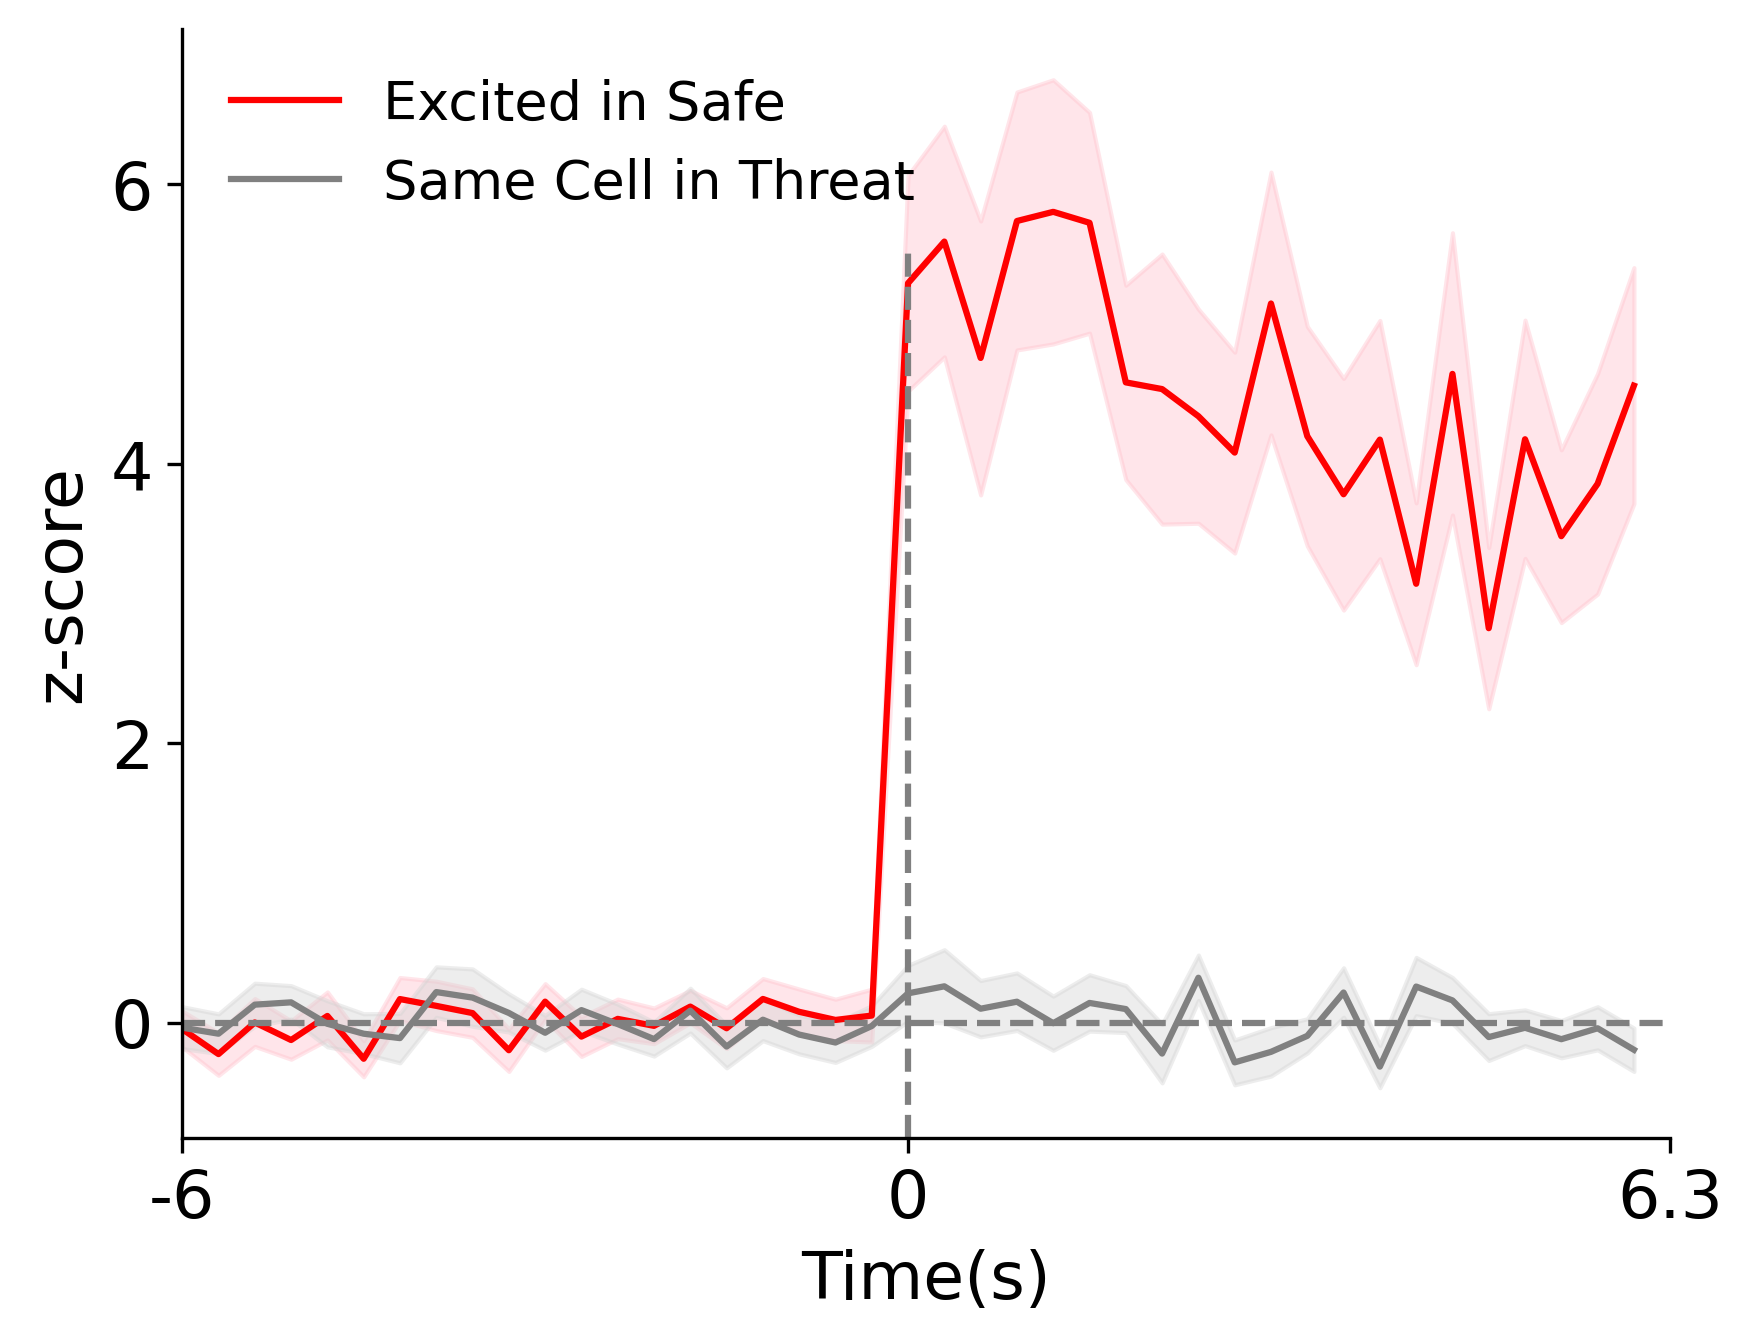

In [40]:
x=np.arange(Bins)
y=pvt_excited_reward_mean
z=pvt_excited_safe_inthreat_mean
erry = pvt_excited_reward_sem
errz = pvt_excited_safe_inthreat_sem
fig, ax = plt.subplots(dpi =300)
ax.tick_params(labelsize = 16)
ax.yaxis.set_major_locator(MaxNLocator(5,integer=True))
ax.set_xlabel('Time(s)', fontsize = 16)
ax.set_ylabel('z-score', fontsize = 16)
ax.plot(x, y, label = 'Excited in Safe', color = 'red')
ax.plot(x, z, label = 'Same Cell in Threat', color = 'grey')
ax.fill_between(x, y-erry, y+erry, color='pink', alpha = 0.4)
ax.fill_between(x, z-errz, z+errz, color='lightgrey', alpha = 0.4)
ax.set_xticks([0,int((Bins/2)),Bins])
ax.set_xticklabels([-TimeRange_before,'0',TimeRange_after])
ax.set_xlim(0, Bins)
# ax.set_ylim(-2, 12)
ax.axvline(int((Bins/2)), ymax=0.8, color = 'grey', ls = '--')
ax.axhline(0, color = 'grey', ls = '--')
ax.legend(loc = 2, framealpha = 0, fontsize = 13)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
len(pvt_excited_reward)

7

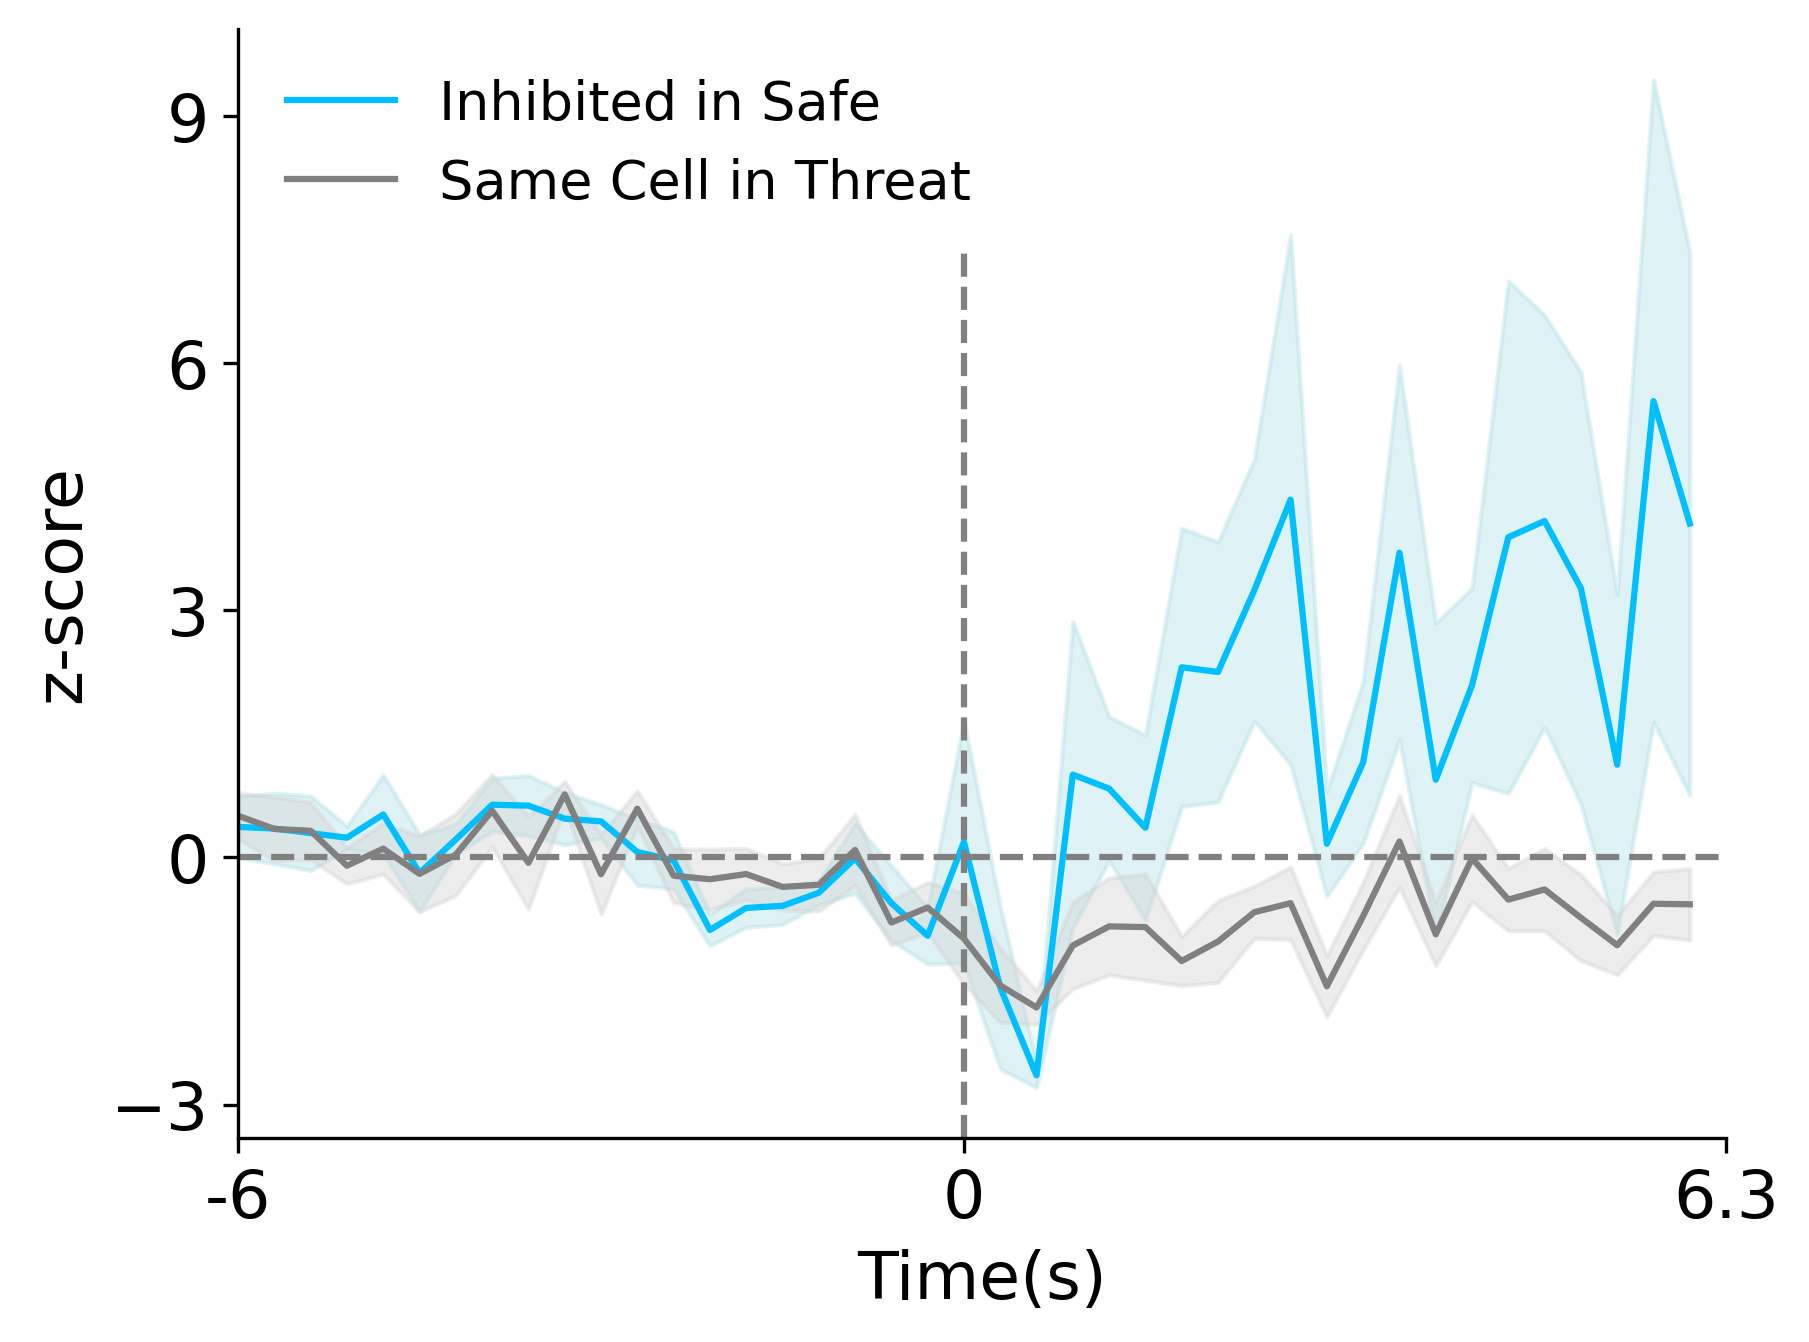

In [41]:
x=np.arange(Bins)
y=pvt_inhibited_reward_mean
z=pvt_inhibited_safe_inthreat_mean
erry = pvt_inhibited_reward_sem
errz = pvt_inhibited_safe_inthreat_sem
fig, ax = plt.subplots(dpi =300)
ax.tick_params(labelsize = 16)
ax.yaxis.set_major_locator(MaxNLocator(5,integer=True))
ax.set_xlabel('Time(s)', fontsize = 16)
ax.set_ylabel('z-score', fontsize = 16)
ax.plot(x, y, label = 'Inhibited in Safe', color='deepskyblue')
ax.plot(x, z, label = 'Same Cell in Threat', color='grey')
ax.fill_between(x, y-erry, y+erry, color = 'powderblue', alpha = 0.4)
ax.fill_between(x, z-errz, z+errz, color = 'lightgrey', alpha = 0.4)
ax.set_xlabel('Time(s)')
ax.set_ylabel('z-score')
ax.set_xticks([0,int((Bins/2)),Bins])
ax.set_xticklabels([-TimeRange_before,'0',TimeRange_after])
ax.set_xlim(0, Bins)
# ax.set_ylim(-4, 3)
ax.axvline(int((Bins/2)), ymax=0.8,color = 'grey', ls = '--')
ax.axhline(0, color = 'grey', ls = '--')
ax.legend(loc = 2, framealpha = 0, fontsize = 13)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
len(pvt_inhibited_reward)

39

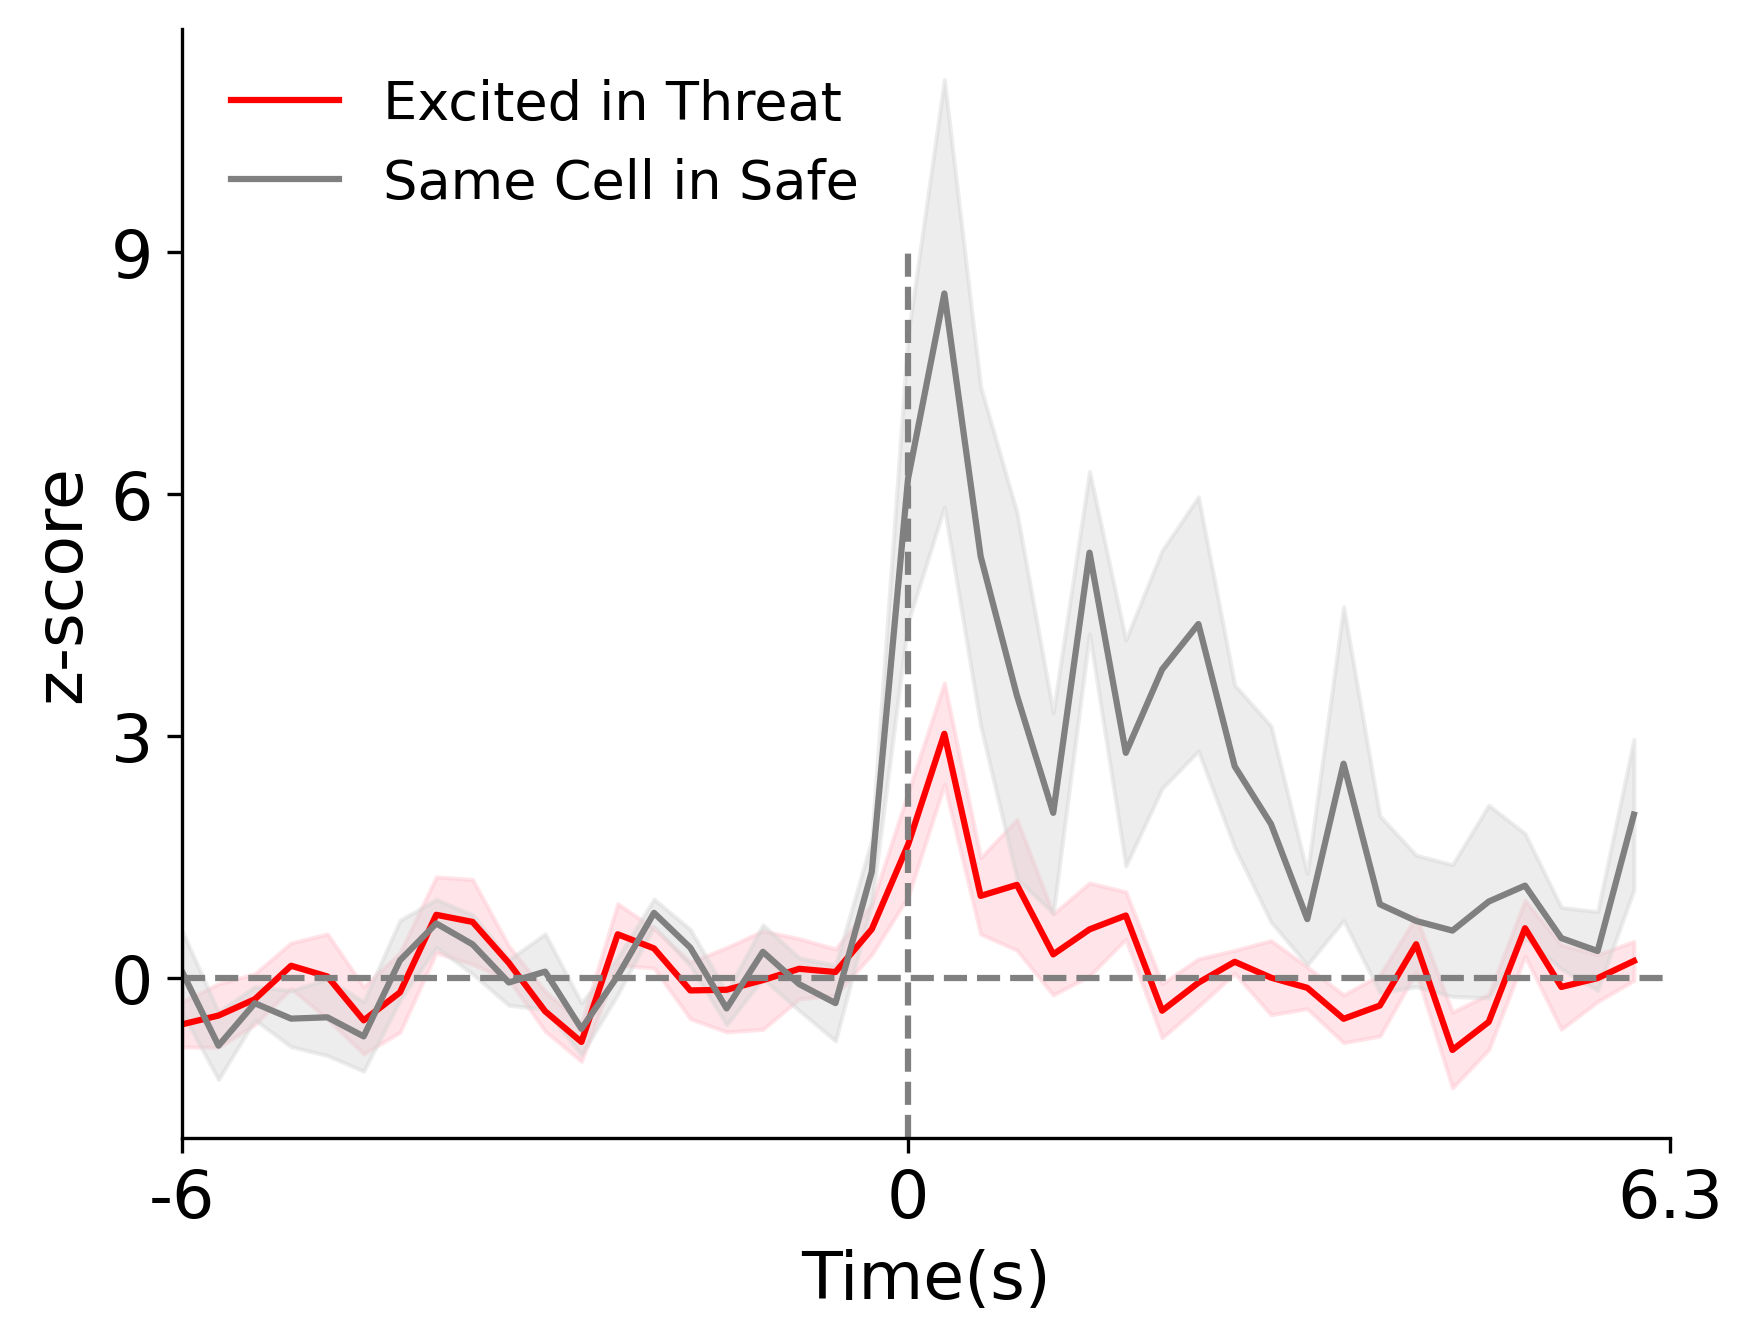

In [42]:
x=np.arange(Bins)
y=pvt_excited_threat_mean
z=pvt_excited_threat_insafe_mean
erry = pvt_excited_threat_sem
errz = pvt_excited_threat_insafe_sem
fig, ax = plt.subplots(dpi =300)
ax.tick_params(labelsize = 16)
ax.yaxis.set_major_locator(MaxNLocator(5,integer=True))
ax.set_xlabel('Time(s)', fontsize = 16)
ax.set_ylabel('z-score', fontsize = 16)
ax.plot(x, y, label = 'Excited in Threat',color='red')
ax.plot(x, z, label = 'Same Cell in Safe',color='grey')
ax.fill_between(x, y-erry, y+erry, color = 'pink', alpha = 0.4)
ax.fill_between(x, z-errz, z+errz, color = 'lightgrey', alpha = 0.4)
ax.set_xticks([0,int((Bins/2)),Bins])
ax.set_xticklabels([-TimeRange_before,'0',TimeRange_after])
ax.set_xlim(0, Bins)
# ax.set_ylim(-3, 12)
ax.axvline(int((Bins/2)), ymax = 0.8,color = 'grey', ls = '--')
ax.axhline(0, color = 'grey', ls = '--')
ax.legend(loc = 2, framealpha = 0, fontsize = 13)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
len(excited_conflict)

72

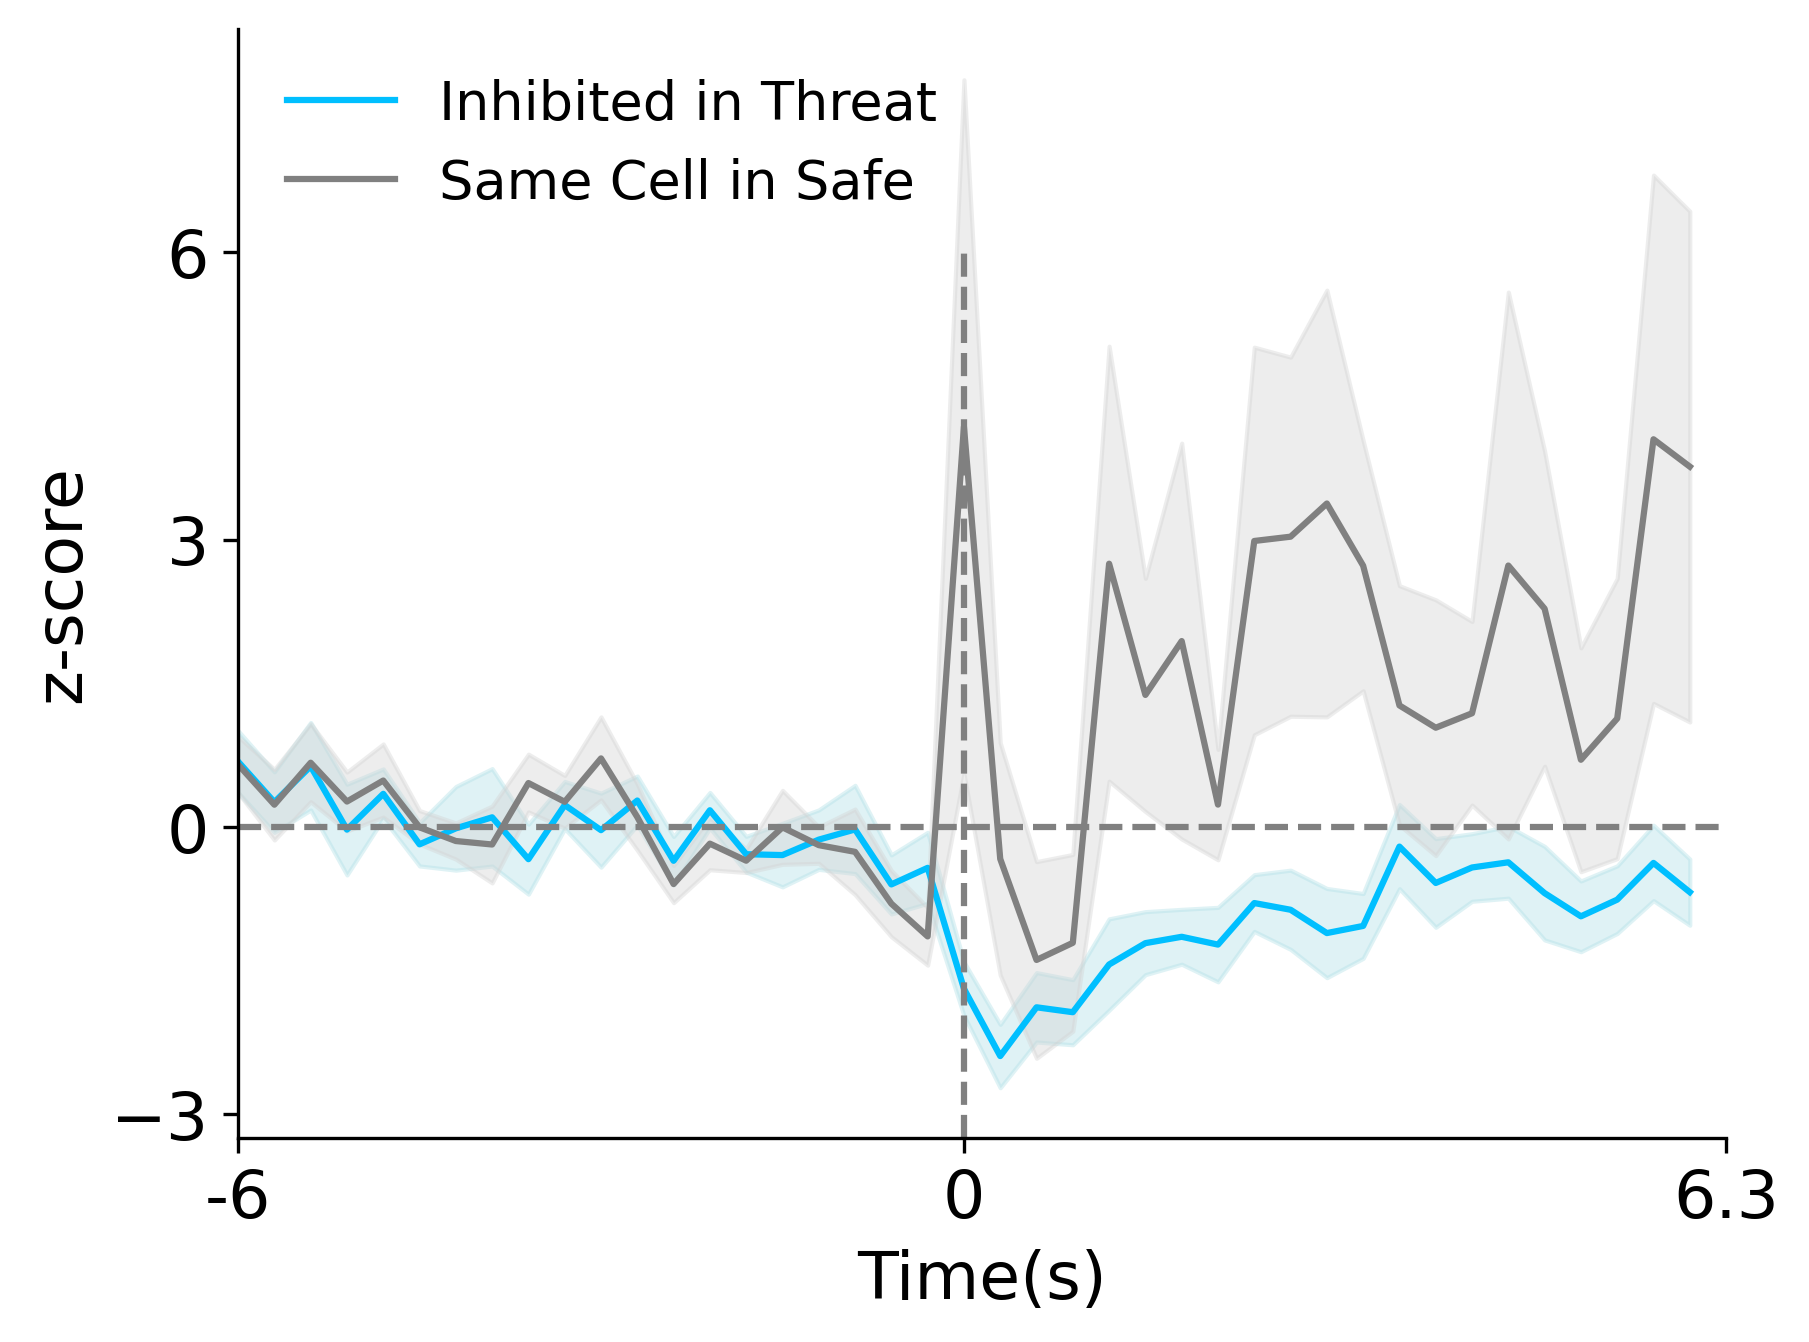

In [43]:
x=np.arange(Bins)
y=pvt_inhibited_threat_mean
z=pvt_inhibited_threat_insafe_mean
erry = pvt_inhibited_threat_sem
errz = pvt_inhibited_threat_insafe_sem
fig, ax = plt.subplots(dpi =300)
ax.tick_params(labelsize = 16)
ax.yaxis.set_major_locator(MaxNLocator(5,integer=True))
ax.set_xlabel('Time(s)', fontsize = 16)
ax.set_ylabel('z-score', fontsize = 16)
ax.plot(x, y, label = 'Inhibited in Threat',color='deepskyblue')
ax.plot(x, z, label = 'Same Cell in Safe',color='grey')
ax.fill_between(x, y-erry, y+erry, color = 'powderblue', alpha = 0.4)
ax.fill_between(x, z-errz, z+errz, color = 'lightgrey', alpha = 0.4)
ax.set_xticks([0,int((Bins/2)),Bins])
ax.set_xticklabels([-TimeRange_before,'0',TimeRange_after])
ax.set_xlim(0, Bins)
ax.axvline(int((Bins/2)), ymax = 0.8, color = 'grey', ls = '--')
ax.axhline(0, color = 'grey', ls = '--')
ax.legend(loc = 2, framealpha = 0, fontsize = 13)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
len(inhibited_conflict)

In [44]:
nac_excited_reward = excited_reward_tagged[excited_reward_tagged.Unit_Type=='PL-NAc']
nac_excited_reward_indices = nac_excited_reward.index.values
nac_inhibited_reward = inhibited_reward_tagged[inhibited_reward_tagged.Unit_Type=='PL-NAc']
nac_inhibited_reward_indices = nac_inhibited_reward.index.values
nac_excited_threat = excited_threat_tagged[excited_threat_tagged.Unit_Type=='PL-NAc']
nac_excited_threat_indices = nac_excited_threat.index.values
nac_inhibited_threat = inhibited_threat_tagged[inhibited_threat_tagged.Unit_Type=='PL-NAc']
nac_inhibited_threat_indices = nac_inhibited_threat.index.values

In [45]:
nac_excited_reward

AnimalID NeuronID Unit_Type _merge         0         1         2  \
35       3P4   SPK10b    PL-NAc   both -1.435934 -0.636607 -0.522417   
41       3P4   SPK22a    PL-NAc   both -0.004962 -0.898183 -1.394417   
58       4P4   SPK12a    PL-NAc   both  1.110514 -0.211527  1.299377   
67       4P4   SPK26a    PL-NAc   both -0.228930  0.659454  0.044419   
73       6U5   SPK25a    PL-NAc   both  0.574724 -1.095414 -1.095414   
115      5A5   SPK13a    PL-NAc   both -1.330962 -0.697170  0.781676   
116      5A5   SPK15a    PL-NAc   both -0.215704  0.347002  0.253217   
118      5A5   SPK19a    PL-NAc   both  0.073333  0.073333  0.073333   
120      5A5   SPK20b    PL-NAc   both -1.643634  0.981980 -1.433585   
229      5P4   SPK10a    PL-NAc   both -0.190678 -0.073338  0.924055   
230      5P4   SPK13a    PL-NAc   both -0.267569 -2.331676 -0.955605   
231      5P4   SPK14a    PL-NAc   both  1.762945  0.885461  0.486605   
232      5P4   SPK15a    PL-NAc   both  2.154318  0.172492  0.906502   
235      5P4   SPK27a    PL-NAc   both  1.584337  0.059889 -1.137891   
236      5P4   SPK30a    PL-NAc   both  0.464567 -0.449335 -1.363236   
294      7U5   SPK01a    PL-NAc   both -0.738433 -2.258736 -0.521247   
295      7U5   SPK01b    PL-NAc   both -0.205897 -0.767434 -0.018718   
298      7U5   SPK19b    PL-NAc   both -1.052804  1.548242  0.433508   
299      7U5   SPK21a    PL-NAc   both  0.628005  0.279113  0.744303   
300      7U5   SPK24a    PL-NAc   both -0.906496 -0.283475 -0.532683   
301      7U5   SPK29a    PL-NAc   both -1.865932 -0.628850  0.505142   
302      7U5   SPK30a    PL-NAc   both -0.481795  0.053533  1.525685   
303      6P4   SPK01a    PL-NAc   both  0.573742 -0.434789  0.327212   
309      6P4   SPK11a    PL-NAc   both -0.318434 -0.629101  1.312569   
310      6P4   SPK15a    PL-NAc   both -0.976261  0.159555 -0.056791   
311      6P4   SPK17a    PL-NAc   both  0.620729  0.970436 -2.176923   
314      6P4   SPK28a    PL-NAc   both -0.990474  0.533332 -0.337414   
346      1D6   SPK29a    PL-NAc   both -0.985032  1.095160 -0.006118   
378      2L4   SPK31a    PL-NAc   both  0.916012  0.514252 -0.289267   

            3         4         5  ...         31         32         33  \
35   1.590090  0.904953 -0.693702  ...   3.702598   0.391099   0.334005   
41   0.789012 -0.501196  0.392025  ...  12.897116  16.172259   8.530259   
58   1.299377  0.241745 -0.098209  ...  -0.249299   0.959424   3.716824   
67  -0.160592  0.317768 -0.980638  ...   6.194764   5.443055   3.597952   
73   0.672968 -0.702441  0.083507  ...  11.185016   1.458915  -1.684875   
115  0.887308  0.359148 -0.802802  ...   7.119588  13.880028   1.626731   
116  0.534570  1.097275  1.097275  ...  18.166005  22.104943  23.699275   
118 -0.008148 -1.311847  0.236295  ...   4.473315   9.851071  19.139923   
120 -0.173291 -1.013487 -0.278315  ...  11.694485   1.192029   0.141783   
229  0.454694  0.220013  1.862777  ...   9.431224   8.433832   3.857561   
230 -1.032053 -0.114673  1.949434  ...  11.429034   1.261398   3.325505   
231  0.406833  0.327062 -1.587448  ...  -0.311108   3.517912   4.395396   
232 -0.634918  0.319294 -0.634918  ...  10.522029   1.567111   5.750966   
235 -1.137891 -0.430112  0.386556  ...  11.547693   9.859911   4.796566   
236 -0.906286 -1.210919  0.312250  ...   7.471144  15.391623  -1.363236   
294  0.202707  0.130312  0.999056  ...   0.564684   2.664150   0.999056   
295  0.074872  0.542819 -0.954613  ...  -0.954613   5.409472  -0.018718   
298 -0.123859 -0.371578  0.371578  ...   0.185789   5.759460   5.697530   
299 -0.534967 -0.883859  0.511708  ...  -1.232751  15.281462  11.327355   
300  1.024870  1.460984  0.588755  ...   1.149474  -0.221172   3.579256   
301  1.329863 -0.731940  0.608232  ...  -2.175203   3.082397  -1.556662   
302 -0.080299  1.124189  0.455029  ...   7.548126  15.176551   7.681958   
303 -0.277906 -0.277906 -0.838202  ...   0.013447   4.988870   3.151101   
309 -0.590268 -0.007767  0.691234  ...   3.

In [46]:
nac_excited_reward_in_threat = conflict_cue_zscore_tagged.iloc[nac_excited_reward_indices]
nac_inhibited_reward_in_threat = conflict_cue_zscore_tagged.iloc[nac_inhibited_reward_indices]
nac_excited_threat_in_safe = reward_cue_zscore_tagged.iloc[nac_excited_threat_indices]
nac_inhibited_reward_in_safe = reward_cue_zscore_tagged.iloc[nac_inhibited_threat_indices]

In [47]:
nac_excited_reward_mean = nac_excited_reward.iloc[:, 4:].mean(axis=0).astype('float')
nac_excited_reward_sem = nac_excited_reward.iloc[:, 4:].sem(axis=0).astype('float')
nac_inhibited_reward_mean = nac_inhibited_reward.iloc[:, 4:].mean(axis=0).astype('float')
nac_inhibited_reward_sem = nac_inhibited_reward.iloc[:, 4:].sem(axis=0).astype('float')
nac_excited_threat_mean = nac_excited_threat.iloc[:, 4:].mean(axis=0).astype('float')
nac_excited_threat_sem = nac_excited_threat.iloc[:, 4:].sem(axis=0).astype('float')
nac_inhibited_threat_mean = nac_inhibited_threat.iloc[:, 4:].mean(axis=0).astype('float')
nac_inhibited_threat_sem = nac_inhibited_threat.iloc[:, 4:].sem(axis=0).astype('float')

In [48]:
nac_excited_safe_inthreat_mean = conflict_cue_zscore_tagged.iloc[nac_excited_reward_indices, 4:].mean(axis=0)
nac_excited_safe_inthreat_sem =  conflict_cue_zscore_tagged.iloc[nac_excited_reward_indices, 4:].sem(axis=0)
nac_inhibited_safe_inthreat_mean = conflict_cue_zscore_tagged.iloc[nac_inhibited_reward_indices, 4:].mean(axis=0)
nac_inhibited_safe_inthreat_sem =  conflict_cue_zscore_tagged.iloc[nac_inhibited_reward_indices, 4:].sem(axis=0)
nac_excited_threat_insafe_mean = reward_cue_zscore_tagged.iloc[nac_excited_threat_indices, 4:].mean(axis=0)
nac_excited_threat_insafe_sem =  reward_cue_zscore_tagged.iloc[nac_excited_threat_indices, 4:].sem(axis=0)
nac_inhibited_threat_insafe_mean = reward_cue_zscore_tagged.iloc[nac_inhibited_threat_indices, 4:].mean(axis=0)
nac_inhibited_threat_insafe_sem =  reward_cue_zscore_tagged.iloc[nac_inhibited_threat_indices, 4:].sem(axis=0)

29

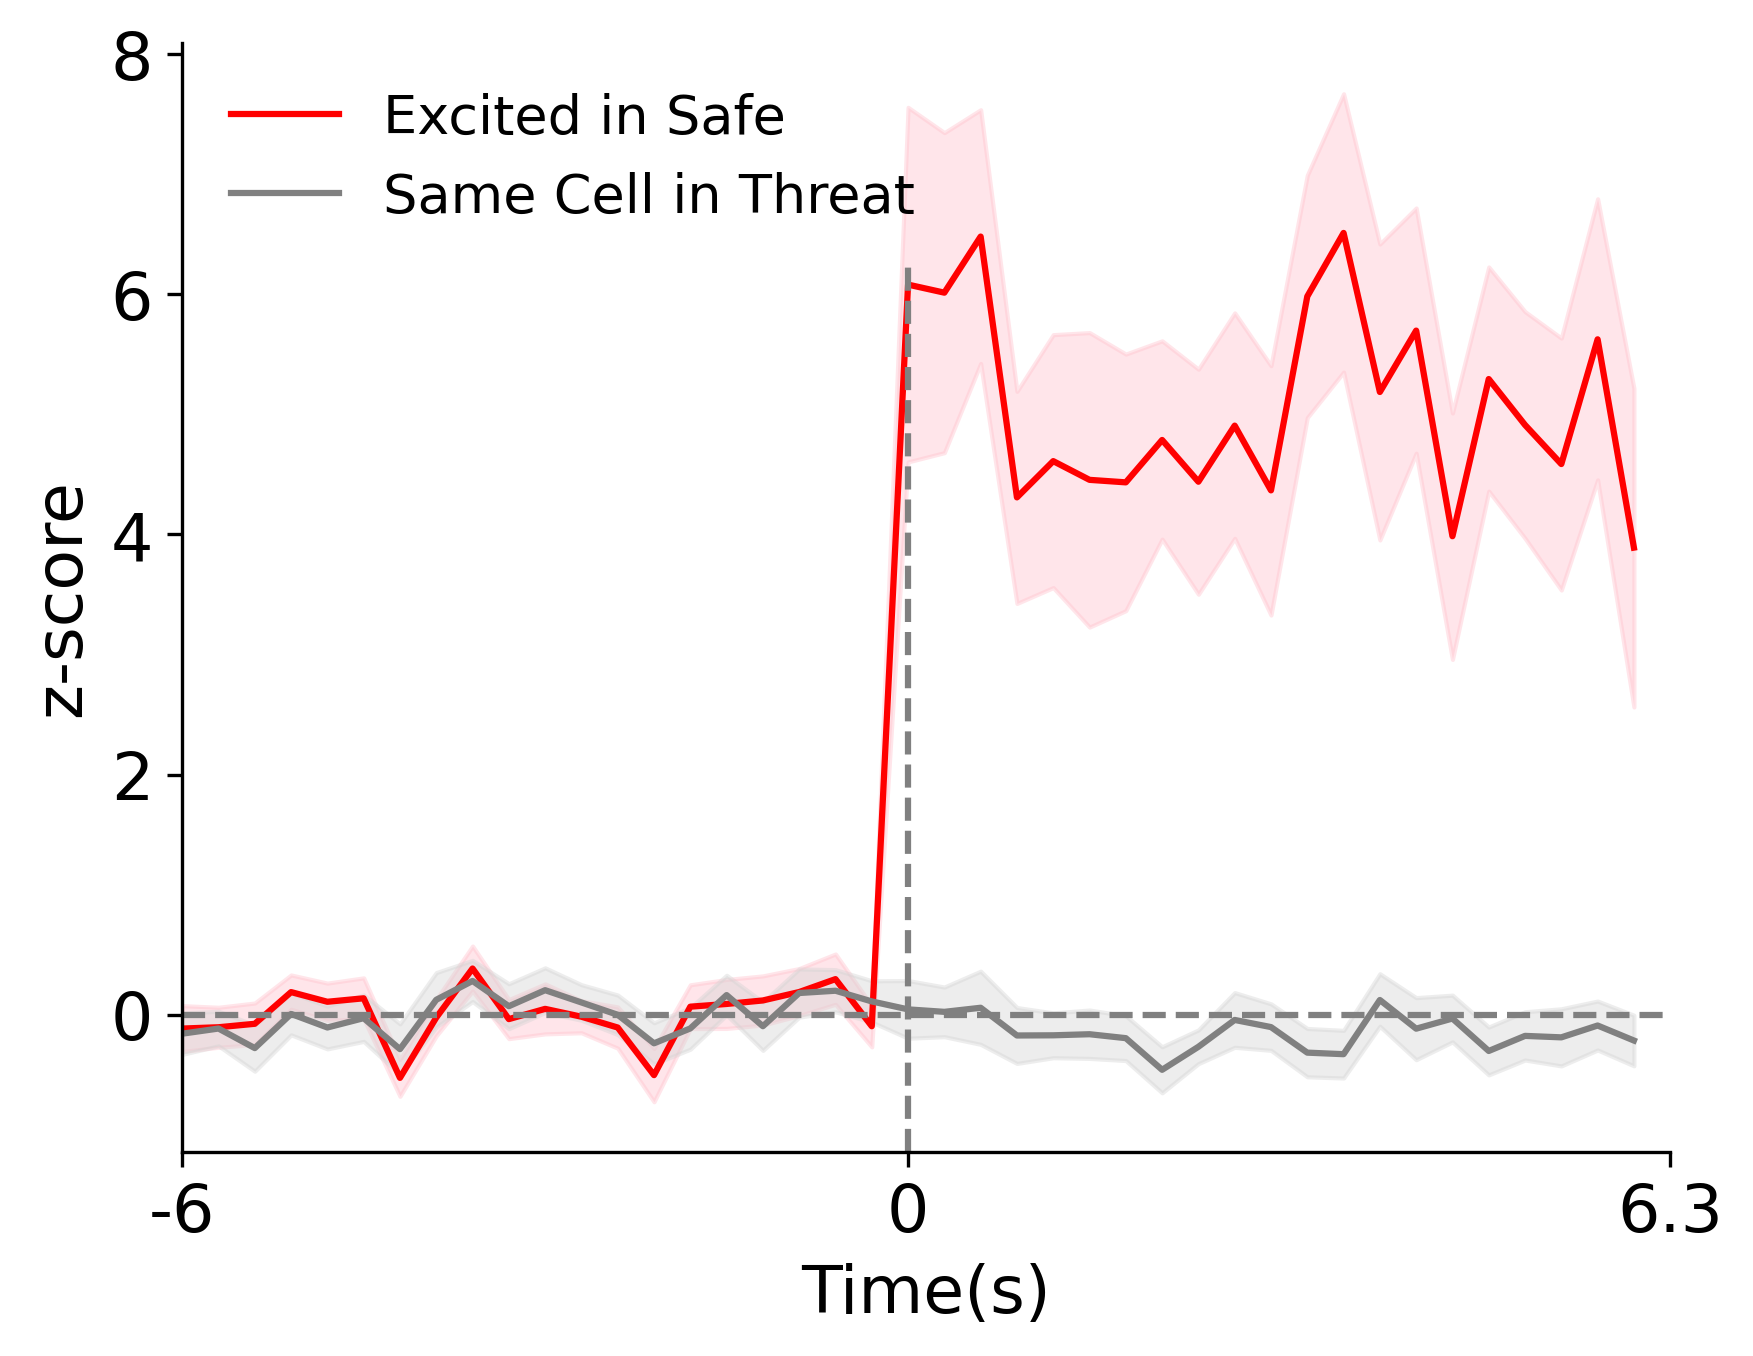

In [49]:
x=np.arange(Bins)
y=nac_excited_reward_mean
z=nac_excited_safe_inthreat_mean
erry = nac_excited_reward_sem
errz = nac_excited_safe_inthreat_sem
fig, ax = plt.subplots(dpi =300)
ax.tick_params(labelsize = 16)
ax.yaxis.set_major_locator(MaxNLocator(5,integer=True))
ax.set_xlabel('Time(s)', fontsize = 16)
ax.set_ylabel('z-score', fontsize = 16)
ax.plot(x, y, label = 'Excited in Safe', color = 'red')
ax.plot(x, z, label = 'Same Cell in Threat', color = 'grey')
ax.fill_between(x, y-erry, y+erry, color='pink', alpha = 0.4)
ax.fill_between(x, z-errz, z+errz, color='lightgrey', alpha = 0.4)
ax.set_xticks([0,int((Bins/2)),Bins])
ax.set_xticklabels([-TimeRange_before,'0',TimeRange_after])
ax.set_xlim(0, Bins)
# ax.set_ylim(-2, 12)
ax.axvline(int((Bins/2)), ymax=0.8, color = 'grey', ls = '--')
ax.axhline(0, color = 'grey', ls = '--')
ax.legend(loc = 2, framealpha = 0, fontsize = 13)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
len(nac_excited_reward)

9

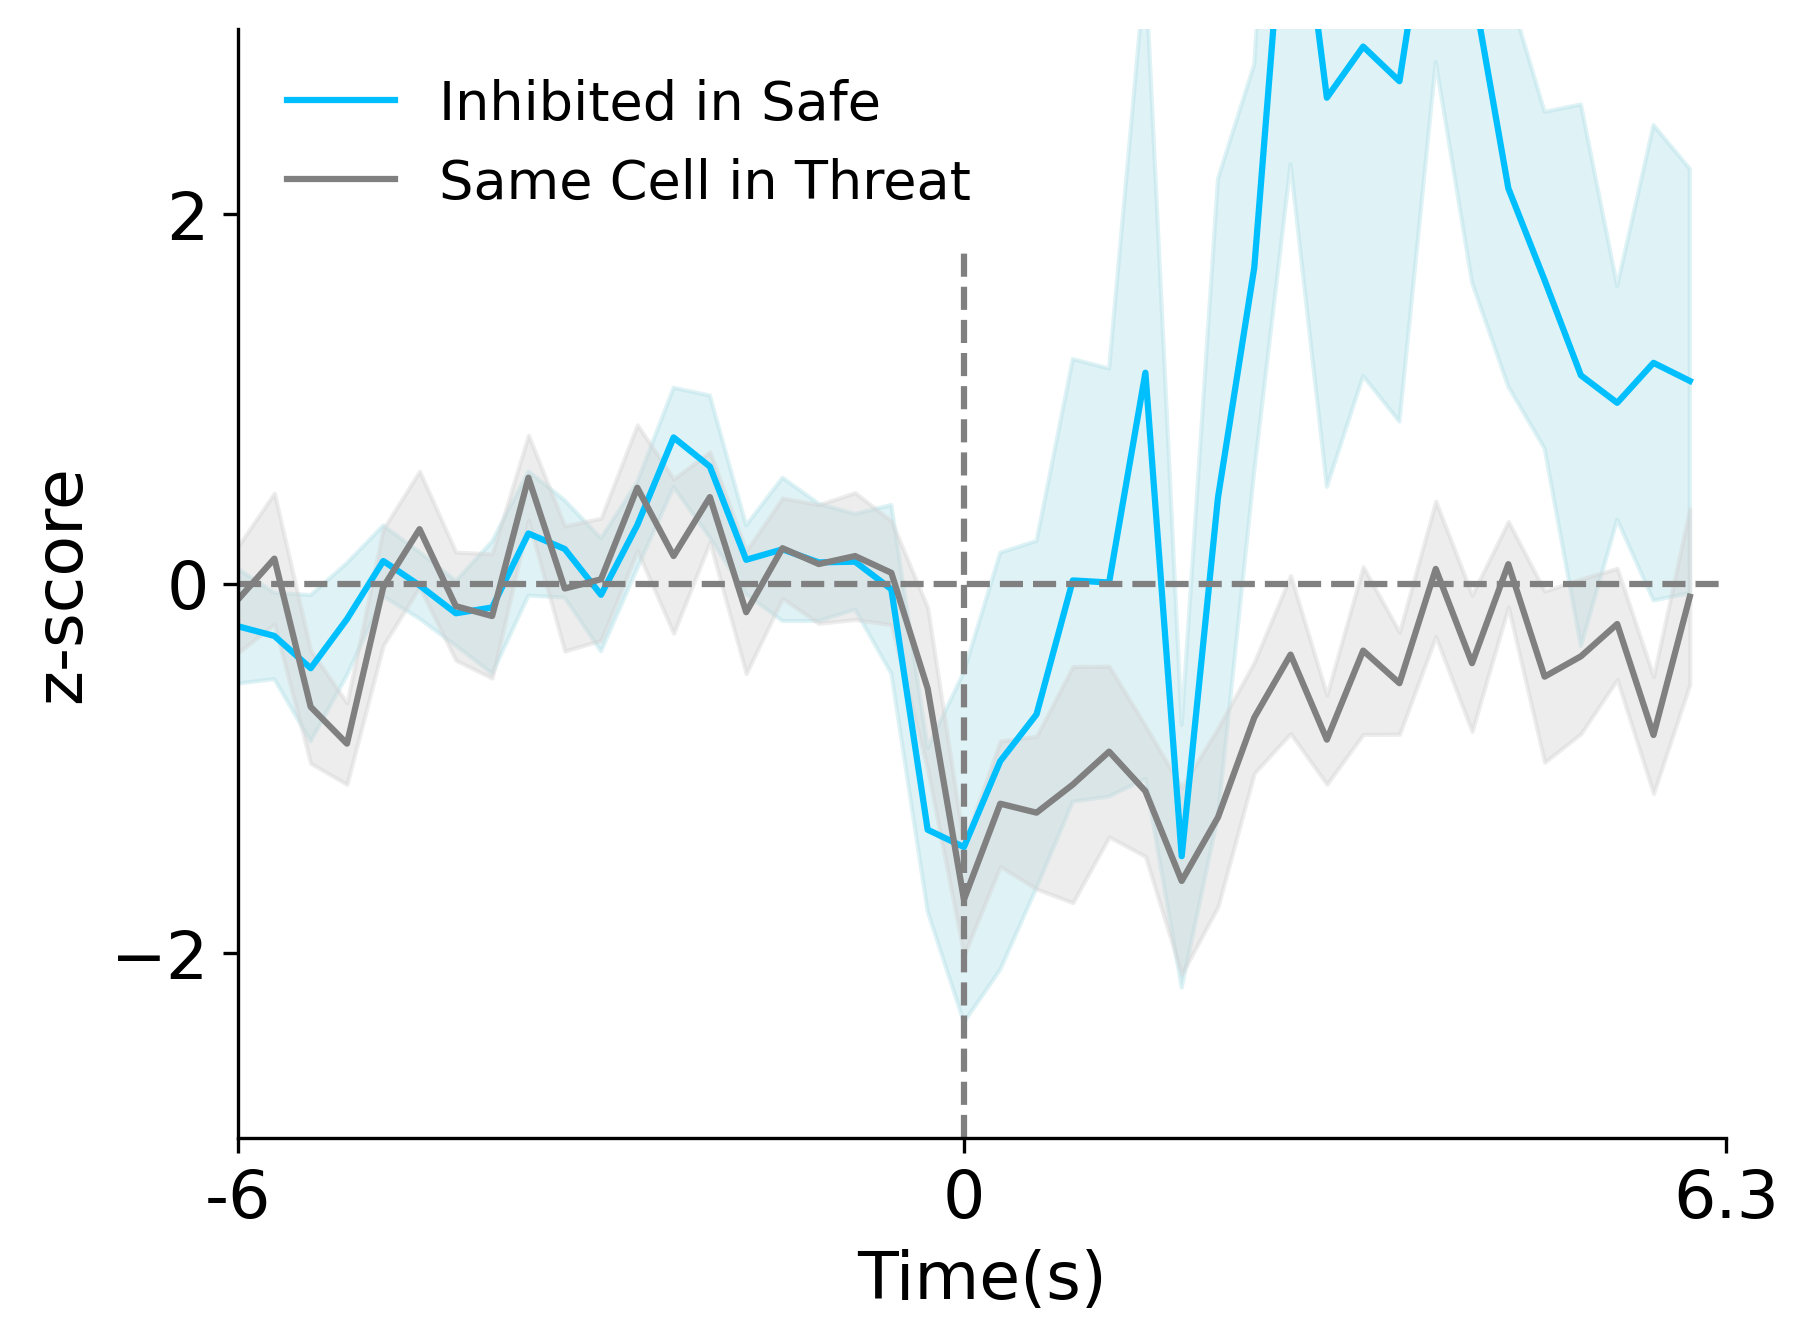

In [50]:
x=np.arange(Bins)
y=nac_inhibited_reward_mean
z=nac_inhibited_safe_inthreat_mean
erry = nac_inhibited_reward_sem
errz = nac_inhibited_safe_inthreat_sem
fig, ax = plt.subplots(dpi =300)
ax.tick_params(labelsize = 16)
ax.yaxis.set_major_locator(MaxNLocator(5,integer=True))
ax.set_xlabel('Time(s)', fontsize = 16)
ax.set_ylabel('z-score', fontsize = 16)
ax.plot(x, y, label = 'Inhibited in Safe', color='deepskyblue')
ax.plot(x, z, label = 'Same Cell in Threat', color='grey')
ax.fill_between(x, y-erry, y+erry, color = 'powderblue', alpha = 0.4)
ax.fill_between(x, z-errz, z+errz, color = 'lightgrey', alpha = 0.4)
ax.set_xlabel('Time(s)')
ax.set_ylabel('z-score')
ax.set_xticks([0,int((Bins/2)),Bins])
ax.set_xticklabels([-TimeRange_before,'0',TimeRange_after])
ax.set_xlim(0, Bins)
ax.set_ylim(-3, 3)
ax.axvline(int((Bins/2)), ymax=0.8,color = 'grey', ls = '--')
ax.axhline(0, color = 'grey', ls = '--')
ax.legend(loc = 2, framealpha = 0, fontsize = 13)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
len(nac_inhibited_reward)

3

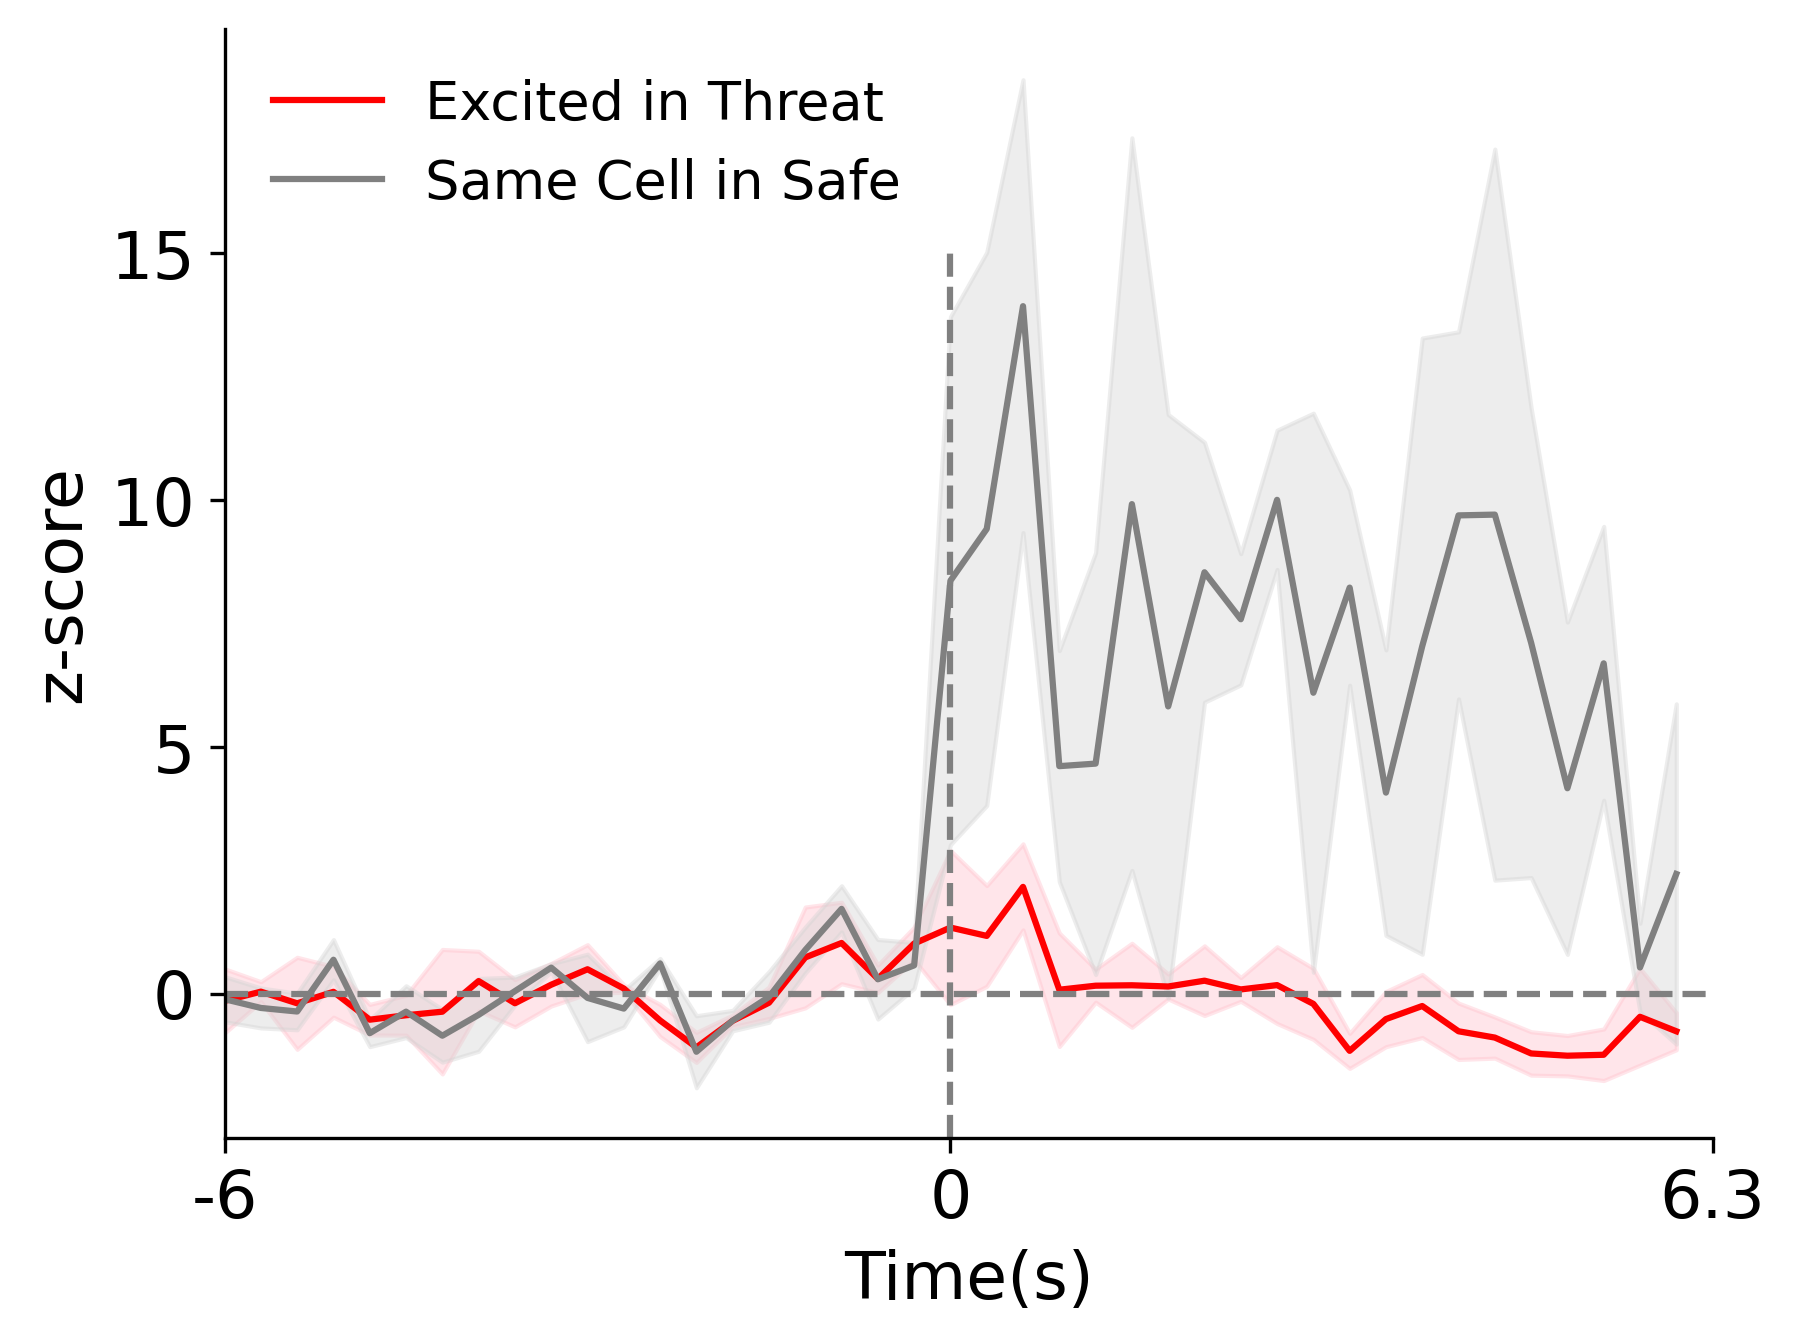

In [51]:
x=np.arange(Bins)
y=nac_excited_threat_mean
z=nac_excited_threat_insafe_mean
erry = nac_excited_threat_sem
errz = nac_excited_threat_insafe_sem
fig, ax = plt.subplots(dpi =300)
ax.tick_params(labelsize = 16)
ax.yaxis.set_major_locator(MaxNLocator(5,integer=True))
ax.set_xlabel('Time(s)', fontsize = 16)
ax.set_ylabel('z-score', fontsize = 16)
ax.plot(x, y, label = 'Excited in Threat',color='red')
ax.plot(x, z, label = 'Same Cell in Safe',color='grey')
ax.fill_between(x, y-erry, y+erry, color = 'pink', alpha = 0.4)
ax.fill_between(x, z-errz, z+errz, color = 'lightgrey', alpha = 0.4)
ax.set_xticks([0,int((Bins/2)),Bins])
ax.set_xticklabels([-TimeRange_before,'0',TimeRange_after])
ax.set_xlim(0, Bins)
# ax.set_ylim(-3, 12)
ax.axvline(int((Bins/2)), ymax = 0.8,color = 'grey', ls = '--')
ax.axhline(0, color = 'grey', ls = '--')
ax.legend(loc = 2, framealpha = 0, fontsize = 13)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
len(nac_excited_threat)

14

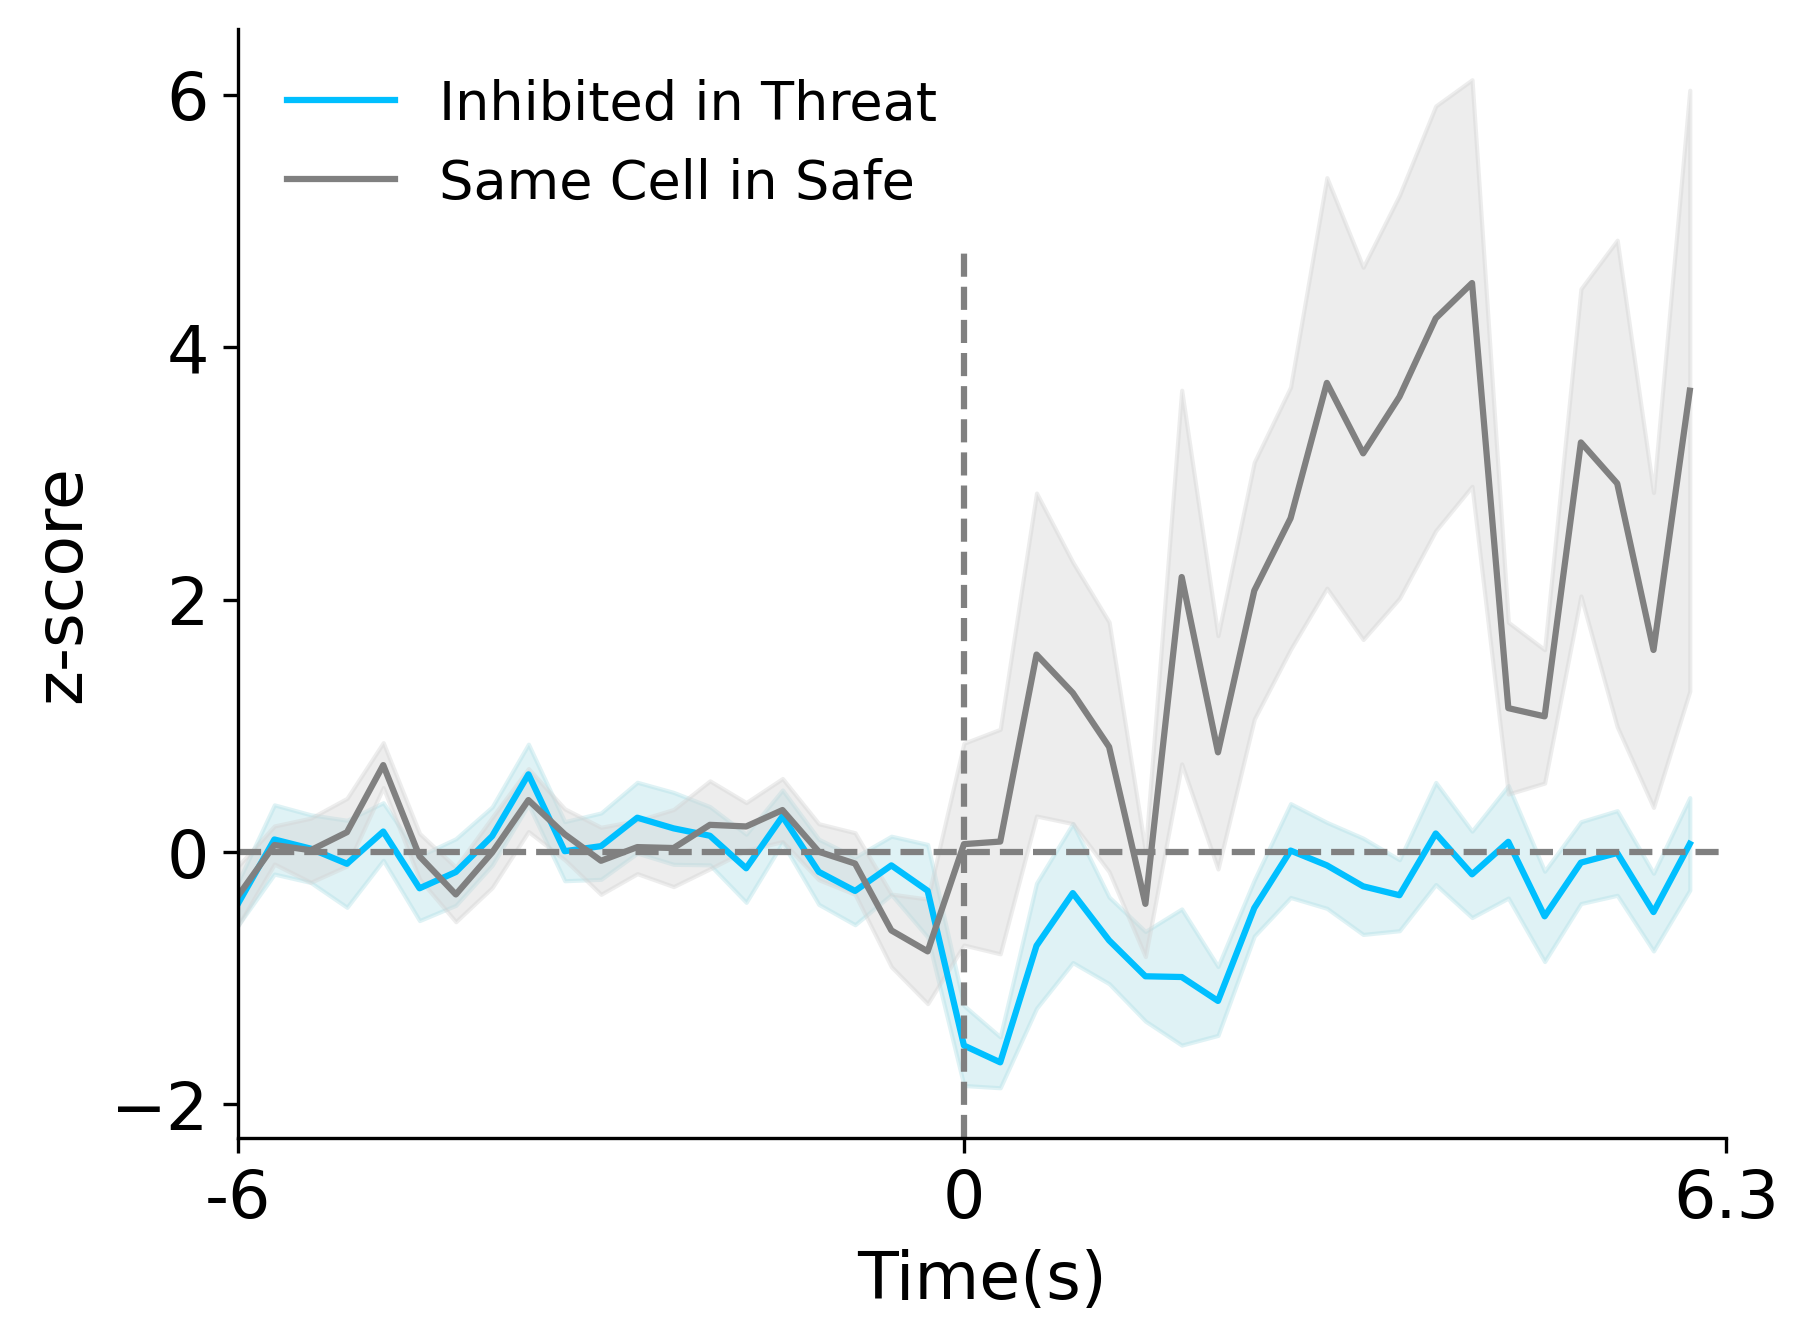

In [52]:
x=np.arange(Bins)
y=nac_inhibited_threat_mean
z=nac_inhibited_threat_insafe_mean
erry = nac_inhibited_threat_sem
errz = nac_inhibited_threat_insafe_sem
fig, ax = plt.subplots(dpi =300)
ax.tick_params(labelsize = 16)
ax.yaxis.set_major_locator(MaxNLocator(5,integer=True))
ax.set_xlabel('Time(s)', fontsize = 16)
ax.set_ylabel('z-score', fontsize = 16)
ax.plot(x, y, label = 'Inhibited in Threat',color='deepskyblue')
ax.plot(x, z, label = 'Same Cell in Safe',color='grey')
ax.fill_between(x, y-erry, y+erry, color = 'powderblue', alpha = 0.4)
ax.fill_between(x, z-errz, z+errz, color = 'lightgrey', alpha = 0.4)
ax.set_xticks([0,int((Bins/2)),Bins])
ax.set_xticklabels([-TimeRange_before,'0',TimeRange_after])
ax.set_xlim(0, Bins)
ax.axvline(int((Bins/2)), ymax = 0.8, color = 'grey', ls = '--')
ax.axhline(0, color = 'grey', ls = '--')
ax.legend(loc = 2, framealpha = 0, fontsize = 13)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
len(nac_inhibited_threat)

## random time

In [17]:
def calculate_perievent_firing_rates(spike_timestamps, events_timestamps, XMin, XMax, Bin, normalization='Counts/Bin'):
    # Number of bins
    num_bins = int(np.ceil((XMax - XMin) / Bin))
    bin_edges = np.linspace(XMin, XMax, num_bins + 1)
    bin_counts = np.zeros(num_bins)

    # Iterate over each reference event
    for ref in events_timestamps:
        # Calculate distances and filter out-of-range spikes
        distances = spike_timestamps - ref
        distances = distances[(distances >= XMin) & (distances < XMax)]

        # Use numpy histogram to count spikes in bins
        counts, _ = np.histogram(distances, bins=bin_edges)
        bin_counts += counts

    # Normalize if required
    if normalization == 'Spikes/Sec':
        bin_counts = bin_counts / (len(events_timestamps) * Bin)

    return bin_counts

def calculate_neuron_firing_rates_random(neuron_id, neuron_data, interval_data, XMin, XMax, Bin, cue_range, normalization='Counts/Bin', seed = 1989):
    random.seed(seed)
    spike_timestamps = neuron_data[neuron_id]
    animal_id = neuron_id[0]  # Assuming the first element of the tuple is the animal ID
    events_timestamps = interval_data[animal_id][cue_range[0]:cue_range[1]].to_numpy()
    potential_numbers = list(np.arange(events_timestamps[0] - 10, events_timestamps[-1] + 10, 6.3))
    events_timestamps_random = np.array(sorted(random.sample(potential_numbers, len(events_timestamps))))

    firing_rates = calculate_perievent_firing_rates(spike_timestamps, events_timestamps_random, XMin, XMax, Bin, normalization)
    return neuron_id, firing_rates

# Function to be executed in parallel
def process_neuron_data_random(neuron_id, neuron_data, interval_data, XMin, XMax, Bin, cue_range, normalization):
    return calculate_neuron_firing_rates_random(neuron_id, neuron_data, interval_data, XMin, XMax, Bin, cue_range, normalization)


def parallel_firing_rates_calculation_random(neuron_data, interval_data, XMin, XMax, Bin, cue_range, normalization='Spikes/Sec'):
    pool = multiprocessing.Pool(processes=multiprocessing.cpu_count())
    func = partial(process_neuron_data_random, neuron_data=neuron_data, interval_data=interval_data, XMin=XMin, XMax=XMax, Bin=Bin, cue_range = cue_range, normalization=normalization)
    results = pool.map(func, neuron_data.keys())
    pool.close()
    pool.join()

    # Create a DataFrame from the results
    columns = ['AnimalID', 'NeuronID'] + [f'{i}' for i in range(int(np.ceil((XMax - XMin) / Bin)))]
    data = []
    for (animal_id, neuron_id), firing_rates in results:
        row = [animal_id, neuron_id] + firing_rates.tolist()
        data.append(row)

    df = pd.DataFrame(data, columns=columns)
    return df

# Example usage
XMin = -30  # Define your XMin
XMax = 30   # Define your XMax
Bin = 0.3  # Define your Bin size
reward_cue = (0,12)

# Example call to the parallel processing function
random_firing_rates_df = parallel_firing_rates_calculation_random(neuron_data, interval_data, XMin, XMax, Bin, reward_cue)

# Display the DataFrame
print(random_firing_rates_df.head())



  AnimalID NeuronID         0         1         2         3         4  \
0      1U1   SPK01a  2.777778  3.333333  3.055556  1.388889  2.500000   
1      1U1   SPK02a  6.666667  4.444444  6.944444  7.777778  6.111111   
2      1U1   SPK08a  1.388889  2.777778  1.666667  2.777778  2.777778   
3      1U1   SPK09a  3.055556  1.666667  1.944444  1.388889  0.277778   
4      1U1   SPK12a  5.555556  5.555556  5.000000  3.888889  4.444444   

          5         6         7  ...       190       191       192       193  \
0  2.777778  1.666667  2.500000  ...  1.944444  1.944444  3.611111  2.500000   
1  6.944444  5.833333  3.611111  ...  5.555556  6.666667  5.000000  4.722222   
2  2.500000  2.500000  2.500000  ...  4.444444  5.000000  2.777778  1.388889   
3  1.388889  1.944444  1.388889  ...  1.111111  1.666667  0.555556  1.388889   
4  5.555556  4.166667  6.666667  ...  3.055556  5.277778  3.055556  3.611111   

        194       195       196       197       198       199  
0  2.777778  2.5

In [18]:
random_firing_rates_df_6s = random_firing_rates_df.iloc[:, int((-XMin-TimeRange_before)/BinSize)+2:int((XMax+TimeRange_after)/BinSize)+2]
baseline_mean = random_firing_rates_df_6s.iloc[:, 0:int(XMax/BinSize)-int((-XMin-TimeRange_before)/BinSize)].mean(axis = 1)
baseline_std = random_firing_rates_df_6s.iloc[:, 0:int(XMax/BinSize)-int((-XMin-TimeRange_before)/BinSize)].std(axis = 1)

random_zscore = random_firing_rates_df_6s.sub(baseline_mean, axis = 0).divide(baseline_std, axis = 0)

In [19]:
excited_random = random_zscore[(random_zscore.iloc[:,int(XMax/BinSize)-int((-XMin-TimeRange_before)/BinSize):int((XMax+0.6)/BinSize)-int((-XMin-TimeRange_before)/BinSize)]>1.96).any(axis =1)]
excited_random.iloc[:,20:].dropna()

100       101       102       103       104       105       106  \
5    2.264210  3.920948  1.711963  1.988087  0.331348 -0.773145  0.607471   
7    1.219606  2.041812 -0.424807  0.123331  0.123331  0.671468 -0.424807   
20   2.141762  0.164751  0.823754  0.164751  2.141762 -0.494253  0.164751   
30   2.821313  1.782793  0.051926  2.128966  2.475140 -0.294247  0.398099   
45   2.833253  2.970125  1.464532  0.369555  0.369555  0.095810 -1.272911   
50   1.171574  2.326647 -0.808551  3.976751  2.821678  0.676543 -0.643541   
51   1.766757  3.303067  1.766757  0.998602  0.998602  0.230447  0.230447   
60   1.987971 -0.462952 -1.552252  0.081697 -1.007602 -0.190627  1.987971   
92   4.097604  1.765634  0.599649 -1.066043  0.099942  0.599649  1.265927   
99  -0.215368  2.656205  0.263228  0.263228 -0.215368 -2.608345  0.263228   
118  1.156761  2.431932  0.792427  3.160600  0.974594  0.610260  0.974594   
132  0.379415  2.194010  0.214452  3.843641  2.194010  1.039268  0.544378   
133 -0.587754  3.820400  3.820400  3.820400 -0.587754  0.881631 -0.587754   
171  0.507392  2.583087 -0.876405  0.507392 -1.568303 -0.645772 -1.337670   
216  0.018658  2.071014 -1.473965  1.138125 -1.847121  0.391813  0.018658   
220  2.179881 -0.371044 -1.530555  0.092761  0.788468 -1.646506 -0.950799   
223 -1.097262  2.524768  0.181102 -1.097262  1.033344  0.820283 -0.884201   
255  3.019129  1.355042 -0.071318 -0.309045  1.355042  0.166409  1.117315   
281  2.773335 -0.381169  1.984709  1.984709 -1.432671  0.670332 -1.432671   
325  2.936542  2.321559  0.169120  0.784103 -0.138371 -0.753354  0.476611   
326  1.419520  3.394504  1.666393  0.678901 -0.061718 -0.061718  0.678901   
328  2.728898  2.582968  1.123664  0.685873  0.248082  0.831803  2.582968   
348  2.112678  7.940755 -0.801361 -0.801361  0.655659 -0.801361 -0.801361   
360  0.944720  2.398135  0.944720 -0.993167 -0.508695 -0.993167 -1.477639   
364  2.628663 -0.343677 -1.272533 -1.458304  1.699807  2.257120  0.399408   
368  0.973329  2.271100  0.162221  0.648886 -0.324443  0.648886  0.486664   
375  2.583015 -0.095667 -0.478336 -0.478336  0.669670  3.348352  1.435008   
384  2.727989  0.222693  0.779425  0.501059 -1.169138 -0.612406 -0.890772   
387 -0.407012  2.790936  0.174434 -0.697734  3.663104  2.500214  1.918769   
394  2.414549 -0.104980  0.314941 -0.104980 -0.944823 -0.104980  0.314941   
398 -1.063287  2.628681  2.037966  1.151894  0.265822  0.856536 -0.324893   

          107       108       109  ...       111       112       113  \
5    2.540333  0.607471 -1.049268  ... -2.982130 -0.773145 -2.429884   
7   -0.424807 -1.521081  1.493674  ... -2.343287 -0.972944 -1.795150   
20   0.164751 -0.494253 -0.494253  ... -1.153256 -0.494253  0.164751   
30   1.436620 -1.332768 -1.332768  ... -0.986594  1.782793  0.398099   
45   1.601404  2.559509 -0.314806  ...  0.643299  0.369555 -0.588550   
50   2.491657  2.821678  0.676543  ... -0.478530  2.326647  1.996626   
51  -0.537709  0.230447 -1.305864  ...  3.303067  2.534912  1.766757   
60   0.898672  0.626347  0.898672  ... -1.007602 -0.190627 -1.007602   
92   0.433080  0.266511 -0.233197  ... -0.566336  0.932788 -0.066628   
99   1.220419  2.177609  0.263228  ...  1.699014 -0.693963 -0.693963   
118  0.063759  0.792427  0.792427  ...  2.431932  0.610260 -0.300576   
132  0.709341 -0.610364  2.853862  ...  2.853862  0.214452  2.523936   
133  0.881631 -0.587754 -0.587754  ...  0.881631 -0.587754  0.881631   
171 -0.415139  0.046127  0.276759  ...  0.507392 -1.337670 -0.645772   
216 -0.914231  0.205236 -1.287387  ... -0.354498  0.205236  0.391813   
220 -1.066750 -0.255092 -0.602946  ... -0.950799 -0.486995 -1.414604   
223  0.607223  1.246404  1.246404  ...  1.033344  2.737829 -0.458080   
255  0.641862  1.355042  0.166409  ... -0.309045 -0.071318  0.404135   
281  0.144581 -1.695546 -2.221297  ...  1.721834 -0.644045 -0.644045   
325  4.166507  1.091594 -0.753354  ...  2.321559 -0.445862  2.936542   
326  1.419520  1.172647 -0.555464

In [20]:
inhibited_random = random_zscore[(random_zscore.iloc[:,int(XMax/BinSize)-int((-XMin-TimeRange_before)/BinSize):int((XMax+0.6)/BinSize)-int((-XMin-TimeRange_before)/BinSize)]<-1.65).any(axis =1)]
inhibited_random.iloc[:,20:].dropna()

100       101       102       103       104       105       106  \
2   -2.115979 -2.115979  2.814457  2.814457  0.760109  4.868805  1.581848   
21  -2.302860 -0.109660  1.535240 -2.302860 -0.109660 -0.657960 -0.657960   
24  -0.309631 -1.998529 -0.309631 -1.154080 -1.435563 -0.028148 -0.872597   
40  -1.951235 -0.038260 -0.038260 -1.186045 -0.420855 -1.568640 -1.951235   
59  -1.559859 -1.953101  0.275269  0.275269  0.013108 -0.904456 -1.428779   
66  -1.841483 -0.884868 -1.124022  1.506668 -0.884868  1.028361  0.071746   
71  -2.542286 -1.174797 -2.625165  0.358448  2.430401 -0.428894 -0.884724   
72  -1.848873  0.177289 -0.835792 -0.582522  0.177289 -1.089062 -0.329251   
81  -1.668549 -0.009219  0.175152 -1.668549 -1.115439 -0.193589 -0.009219   
108  0.277278 -2.332399 -0.701351 -2.006190 -1.679980 -0.375141 -0.701351   
113  1.516849 -1.853926 -0.168539  0.393257  0.393257  1.516849 -0.168539   
116 -2.730334 -0.248212 -0.248212 -0.799795 -0.524003 -1.075586 -0.248212   
153 -2.411702 -0.080689 -0.977233 -2.411702 -0.797924 -1.873776 -0.080689   
179 -1.583306 -1.929384  1.358356  1.877473 -0.718112 -0.372034 -0.545073   
190 -0.087990 -1.652255  0.498610 -0.674589 -0.087990 -0.283523 -0.283523   
195  0.045007 -1.755254 -0.405059 -0.405059 -1.755254 -1.305189 -1.305189   
196 -0.226471 -1.873530 -1.461765 -0.500981 -1.461765 -1.324510 -0.912746   
200  0.923381 -3.437027 -1.385071 -0.615587 -0.615587  0.666886  1.436370   
232 -2.631903  0.988704 -2.910411 -1.517870  0.431688 -2.074887 -1.517870   
238 -1.984808 -1.174683 -0.364557  1.255695  2.065821  1.255695 -1.984808   
239 -2.344579 -0.696632 -1.895139 -1.595512  0.651688 -1.146072  0.202248   
284 -1.775306  1.377106 -1.111640  0.049775 -0.945723  0.713441  0.049775   
288  0.334177 -2.065040 -1.036804  0.334177 -1.893667 -1.036804 -0.351314   
301 -2.128938 -1.008445  1.232543  0.485547 -0.261449 -1.381942 -0.634947   
337 -1.691580 -0.889250 -1.290415  0.180524 -0.755528  0.715411 -2.092746   
339 -1.839309 -0.996877  1.530417  1.249607  2.092038  3.215280  1.530417   
344 -0.651090 -1.679127 -1.336448 -1.336448  1.062305 -0.993769 -0.651090   
349 -0.255622 -2.922982 -0.255622 -0.922462  0.855778  0.855778  0.633498   
354 -1.724504 -0.862252 -0.287417 -1.149669 -2.586756 -1.149669 -1.724504   
363 -2.165160  1.322346  3.356725 -0.130782 -0.712033 -1.874535 -1.293284   
377 -0.398256 -1.803865 -0.398256  1.007353 -0.398256 -1.335329 -0.398256   
390 -1.674777 -0.539335 -1.674777 -1.674777 -1.107056 -1.107056  0.028386   
392  0.306323 -1.814377 -1.343110 -1.343110  0.306323 -0.164943 -0.400577   
395 -1.231928 -1.858332 -0.396722 -1.023126  0.438483  0.020880 -1.231928   
397 -1.916461 -0.403466 -0.151300 -1.159964 -0.151300  1.361696  1.109530   

          107       108       109  ...       111       112       113  \
2   -1.705109 -0.883370 -0.472500  ...  2.814457 -0.883370  3.225327   
21  -0.657960 -0.109660  0.986940  ... -1.754560 -1.206260  0.438640   
24   3.349648 -2.280013  1.942233  ...  4.194097  0.816301  0.253335   
40  -1.951235 -0.803450 -0.420855  ...  1.492121  2.639906  1.109526   
59   0.013108  0.537431 -0.773376  ... -0.511214  0.144189 -2.608504   
66  -0.406561 -0.884868  1.506668  ...  0.071746  0.310900  0.789207   
71  -0.553211 -2.169335 -2.376530  ... -2.210774 -2.832360 -1.423432   
72   0.430560  0.683830  3.216533  ...  0.937100  0.683830  0.937100   
81  -0.193589 -0.193589 -0.562329  ... -1.299809 -0.193589 -0.562329   
108 -1.679980 -1.679980 -0.701351  ... -1.353770 -1.679980 -0.701351   
113  3.764032 -0.168539  2.640441  ...  1.516849 -0.168539  2.640441   
116  0.027579  0.027579 -2.178751  ... -0.524003 -1.351377 -1.902960   
153 -0.259998  1.891707  1.533090  ...  2.071016 -1.515159 -0.439306   
179 -0.025956 -0.545073  0.666200  ... -0.025956  0.493161  0.666200   
190  2.453941  0.498610 -0.870123  ... -0.087990 -1.065656  0.107543   
195  0.045007  1.845267 -0.855124  ... -0.855124 -1.305189  5.445788   
196 -0.500981

In [21]:
cue_range= reward_cue
random.seed(1989)
events_timestamps = interval_data['1U1'][cue_range[0]:cue_range[1]].to_numpy()
# Calculate range for random number generation
start_range = events_timestamps[0] - 10
end_range = events_timestamps[-1] + 10

potential_numbers = list(np.arange(events_timestamps[0] - 10, events_timestamps[-1] + 10, 6.3))
events_timestamps_random = np.array(sorted(random.sample(potential_numbers, len(events_timestamps))))

events_timestamps_random

array([ 642. ,  667.2,  711.3,  780.6,  786.9,  805.8,  925.5,  994.8,
       1020. , 1032.6, 1146. , 1158.6])

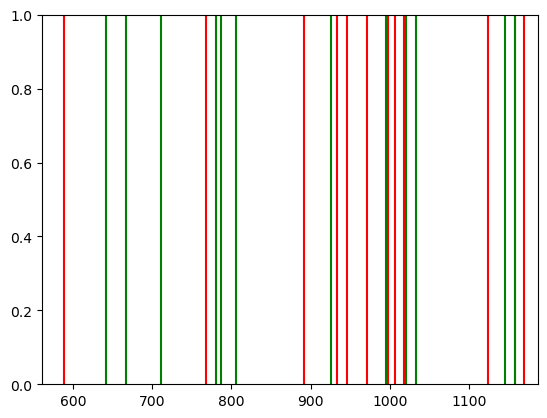

In [22]:
for i in range(len(events_timestamps)):
    plt.axvline(events_timestamps[i], c = 'r')
    plt.axvline(events_timestamps_random[i], c = 'g')

In [23]:
excited_random_indices = excited_random.index.values
inhibited_random_indices = inhibited_random.index.values
excited_random_mean = excited_random.mean(axis=0).astype('float')
excited_random_sem = excited_random.sem(axis=0).astype('float')
inhibited_random_mean = inhibited_random.mean(axis=0).astype('float')
inhibited_random_sem = inhibited_random.sem(axis=0).astype('float')

In [30]:
total_cells = len(reward_cue_zscore)

# Calculate percentages
percent_excited_random = len(excited_random_indices) / total_cells * 100
percent_inhibited_random = len(inhibited_random_indices) / total_cells * 100

# Assuming excited_indices contains the indices for excited cells from the original trace_hungry DataFrame
percent_excited = len(excited_reward_indices) / total_cells * 100
percent_inhibited = len(inhibited_reward_indices) / total_cells * 100

# Find the intersection (cells that are in both excited_indices_30s and excited_indices)
common_excited_indices = set(excited_random_indices).intersection(set(excited_reward_indices))
percent_common_excited = len(common_excited_indices) / total_cells * 100

common_inhibited_indices = set(inhibited_random_indices).intersection(set(inhibited_reward_indices))
percent_common_inhibited = len(common_inhibited_indices) / total_cells * 100

excited_inhibitedrandom_indices = set(excited_reward_indices).intersection(set(inhibited_random_indices))
percent_excited_inhibitedrandom = len(excited_inhibitedrandom_indices) / total_cells * 100

inhibited_excitedrandom_indices = set(inhibited_reward_indices).intersection(set(excited_random_indices))
percent_inhibited_excitedrandom = len(inhibited_excitedrandom_indices) / total_cells * 100

# Printing the results
print(f"Percentage of excited cells (random): {percent_excited_random:.2f}%")
print(f"Percentage of inhibited cells (random): {percent_inhibited_random:.2f}%")
print(f"Percentage of excited cells: {percent_excited:.2f}%")
print(f"Percentage of inhibited cells: {percent_inhibited:.2f}%")
print(f"Percentage of cells excited in both cases: {percent_common_excited:.2f}%")
print(f"Percentage of cells inhibited in both cases: {percent_common_inhibited:.2f}%")
print(f"Percentage of cells excited in hungry cues and inhibited random: {percent_excited_inhibitedrandom:.2f}%")
print(f"Percentage of cells inhibited in hungry cues and excited random: {percent_inhibited_excitedrandom:.2f}%")


Percentage of excited cells (random): 7.73%
Percentage of inhibited cells (random): 8.73%
Percentage of excited cells: 69.58%
Percentage of inhibited cells: 10.72%
Percentage of cells excited in both cases: 4.49%
Percentage of cells inhibited in both cases: 0.00%
Percentage of cells excited in hungry cues and inhibited random: 6.48%
Percentage of cells inhibited in hungry cues and excited random: 0.75%


ValueError: Wedge sizes 'x' must be non negative values

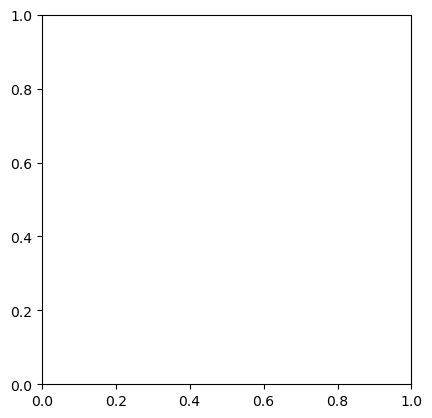

In [31]:


# Calculate the count of cells not in any of the above categories
other_percent = 100 - (percent_excited_random + percent_inhibited_random + percent_excited + percent_inhibited + percent_common_excited + percent_common_inhibited + percent_excited_inhibitedrandom + percent_inhibited_excitedrandom)

# Calculate percentages
percentages = {
    "Excited only in random":  percent_excited_random - percent_common_excited - percent_inhibited_excitedrandom,
    "Inhibited only in random": percent_inhibited_random- percent_common_inhibited - percent_excited_inhibitedrandom,
    "Excited only in Cue": percent_excited - percent_common_excited - percent_excited_inhibitedrandom,
    "Inhibited only in Cue": percent_inhibited -percent_common_inhibited- percent_inhibited_excitedrandom,
    "Common Excited": percent_common_excited,
    "Common Inhibited": percent_common_inhibited,
    "Excited but Inhibited in random": percent_excited_inhibitedrandom,
    "Inhibited but Excited in random": percent_inhibited_excitedrandom,
    "Other": other_percent
}

# Code to create a pie chart
fig, ax = plt.subplots()
wedges, texts, autotexts = ax.pie(percentages.values(), labels=percentages.keys(), autopct='%1.1f%%', startangle=140)

# Draw a legend with some space around each entry
ax.legend(wedges, percentages.keys(), loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

ax.set_title('Composition of Cell Responses')
plt.show()


In [ ]:
sns.set_style('ticks')
import matplotlib as mpl
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['legend.labelspacing'] = 0.2
mpl.rcParams['axes.labelpad'] = 2
mpl.rcParams['xtick.major.size'] = 2
mpl.rcParams['xtick.major.width'] = 0.5
mpl.rcParams['xtick.major.pad'] = 1
mpl.rcParams['ytick.major.size'] = 2
mpl.rcParams['ytick.major.width'] = 0.5
mpl.rcParams['ytick.major.pad'] = 1
mpl.rcParams['lines.scale_dashes'] = False
mpl.rcParams['lines.dashed_pattern'] = (2, 1)
mpl.rcParams['font.sans-serif'] = ['Arial']
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['text.color'] = 'k'

In [ ]:
import psutil

total_ram = psutil.virtual_memory().total
print(f"Total RAM available: {total_ram / (1024 * 1024 * 1024)} GB")
import multiprocessing
print("Number of CPU cores:", multiprocessing.cpu_count())


## General functions

In [ ]:
def standardize_plot_graphics(ax):
    [i.set_linewidth(0.5) for i in ax.spines.values()]
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    return ax

def fit_regression(x, y):
    lm = sm.OLS(y, sm.add_constant(x)).fit()
    x_range = sm.add_constant(np.array([x.min(), x.max()]))
    x_range_pred = lm.predict(x_range)
    return lm.pvalues[1], lm.params[1], x_range[:,1], x_range_pred, lm.rsquared

def CDFplot(x, ax, **kwargs):
    x = np.array(x)
    ix=np.argsort(x)
    ax.plot(x[ix], ECDF(x)(x)[ix], **kwargs)
    return ax

def fit_regression_and_plot(x, y, ax, plot_label='', color='k', linecolor='r', markersize=3,
                            show_pval=True):
    #linetype is a string like 'bo'
    pvalue, slope, temp, temppred, R2 = fit_regression(x, y)   
    if show_pval:
        plot_label = '%s p=%.2e\nr=%.3f'% (plot_label, pvalue, np.sign(slope)*np.sqrt(R2))
    else:
        plot_label = '%s r=%.3f'% (plot_label, np.sign(slope)*np.sqrt(R2))
    ax.scatter(x, y, color=color, label=plot_label, s=markersize)
    ax.plot(temp, temppred, color=linecolor)
    return ax, slope, pvalue, R2

In [ ]:
base_dir = "./Data"

databin = 0.01
BinSize = 0.3


In [ ]:
# Load the csv files for each animal into a dictionary

files = os.listdir(base_dir)

csv_files = [file for file in files if (file.endswith('.csv')) & (file[0].isdigit())]

animal_ids = []
for csv_file in csv_files:
    if csv_file[:2].isdigit():
        animal_id = csv_file[:4]
    else:
        animal_id = csv_file[:3]
    animal_ids.append(animal_id) 

In [ ]:
len(animal_ids)

# Data preprocess with Ephys data (only run this first time)

### Load the csv files for each animal into a dictionary
animal_data = {}
for xlsx_file, animal_id in zip(csv_files, animal_ids):
    filename = os.path.join(base_dir, xlsx_file)
    animal_data[animal_id] = pd.read_csv(filename)

with open('animal_data.pkl', 'wb') as f:
    pickle.dump(animal_data, f)

In [ ]:
with open('animal_data.pkl', 'rb') as f:
    animal_data = pickle.load(f)

In [ ]:
# Load the csv file with cross timepoints
interval_data = pd.read_csv(os.path.join(base_dir,"Trial by Trial Cues.csv"), header = 1)
photoid = pd.read_csv(os.path.join(base_dir,"Phototag ID's.csv"), index_col =0)

In [ ]:
total_columns = 0

for key, df in animal_data.items():
    total_columns += df.shape[1]
total_columns-len(animal_data)

In [ ]:
photo_animals = [ids for ids in photoid.columns if ids[0].isdigit()]

In [ ]:
def unmatched_elements(array1, array2):
    set1 = set(array1)
    set2 = set(array2)
    return list(set1.difference(set2)) + list(set2.difference(set1))
unmatched_elements(animal_ids, photo_animals)

In [ ]:
photoid.index = ["Unit", "PL GABA", "PL-PVT", "PL-NAc"]

In [ ]:
photoid

In [ ]:
PhotoTag = pd.DataFrame(columns=['Animal_ID', 'Unit_id', 'Unit_Type'])

photoid = photoid.reset_index()
# Iterate over the columns in the input DataFrame
current_animal_id = None
for col in photoid.columns[1:]:
    if 'Unnamed' not in col:
        current_animal_id = col
    for row_idx in range(1, photoid.shape[0]):
        unit_id = photoid.loc[0, col]
        unit_type = photoid.loc[row_idx, 'index']
        value = photoid.loc[row_idx, col]

        if value == "1":
            new_row = pd.DataFrame({'Animal_ID': [current_animal_id], 'Unit_id': [unit_id], 'Unit_Type': [unit_type]})
            PhotoTag = pd.concat([PhotoTag, new_row], ignore_index=True)

    # Check if the current column has all 0s
    if pd.to_numeric(photoid.loc[1:, col], errors='coerce').sum() == 0:
        new_row = pd.DataFrame({'Animal_ID': [current_animal_id], 'Unit_id': [unit_id], 'Unit_Type': ['Unidentified']})
        PhotoTag = pd.concat([PhotoTag, new_row], ignore_index=True)


In [ ]:
PhotoTag

In [ ]:
PhotoTag.to_csv('PhotoTags.csv')

In [ ]:
# Initialize an empty DataFrame to store the results
constructed_all_cells = pd.DataFrame(columns=['Animal_ID', 'Unit_id'])

# Loop through the animal_data_dict dictionary
for animal_id, animal_df in animal_data.items():
    
    # Get the Unit_ids from the column names (2nd to last)
    unit_ids = animal_df.columns[1:]
    
    # Create a new DataFrame with the Animal_ID and Unit_id information
    new_rows = pd.DataFrame({'Animal_ID': [animal_id] * len(unit_ids), 'Unit_id': unit_ids})
    
    # Append the new_rows to the constructed_all_cells DataFrame
    constructed_all_cells = pd.concat([constructed_all_cells, new_rows], ignore_index=True)

# Display the constructed_all_cells DataFrame
print(constructed_all_cells)


In [ ]:
constructed_all_cells

In [ ]:
PhotoTag

In [ ]:

merged_df = PhotoTag.merge(constructed_all_cells, on=['Animal_ID', 'Unit_id'], how='outer', indicator=True)
non_matching_rows = merged_df[merged_df['_merge'] != 'both']
non_matching_rows

In [ ]:
# Merge the DataFrames on 'Animal_ID' and 'Unit_id'
merged_df = PhotoTag.merge(constructed_all_cells, on=['Animal_ID', 'Unit_id'], how='outer', indicator=True)

# Find the duplicate matches
duplicate_matches = merged_df[merged_df.duplicated(['Animal_ID', 'Unit_id'], keep=False)]

# Find the missing matches
missing_matches_left = merged_df[merged_df['_merge'] == 'left_only']
missing_matches_right = merged_df[merged_df['_merge'] == 'right_only']

# Display the results
print("Duplicate matches:")
print(duplicate_matches)

print("\nMissing matches in PhotoTag:")
print(missing_matches_left)

print("\nMissing matches in all_cells:")
print(missing_matches_right)



In [ ]:
animal_data

## FR from -30s to 30s

In [ ]:
databin = 0.01
BinSize = 0.3
TimeRange_before = 30
TimeRange_after = 30
TimeRange = TimeRange_before+ TimeRange_after
CompareRange_base = 6
CompareRange_after = 6.3

FrameRange_before = int(TimeRange_before/databin)
FrameRange_after = int(TimeRange_after/databin)
TotalFrame = int(FrameRange_before+FrameRange_after)
Bins = int(TotalFrame/int(BinSize/databin))
Bins_before = int(FrameRange_before/int(BinSize/databin))
# Bins_cueend = Bins_before+int(FR*Cueduration/BinSize)
TotalBins = int(TimeRange/BinSize)

In [ ]:
# animal_id, animal_data, interval_data, TimeRange, databin, TotalBins = args

animal_dt = animal_data['1U1']

# Extract unit IDs from the first row
unit_ids = animal_dt.iloc[0].index[1:].tolist()
animalids = np.repeat(animal_id, len(unit_ids))

# Interval for each session of the current animal
re_interval = interval_data[animal_id][0:12]
cn_interval = interval_data[animal_id][12:36]


# Extract and normalize the trace 
trace = animal_dt.iloc[:,1:].T
#trace = trace.sub(trace.mean(axis=1), axis =0).divide(trace.std(axis=1),axis=0)

# re = process_intervals(re_interval, TimeRange, trace, animal_dt, animalids, databin, TotalBins)
# cn = process_intervals(cn_interval, TimeRange, trace, animal_dt, animalids, databin, TotalBins)

start = re_interval - TimeRange_before
startidx = np.searchsorted(animal_dt["Bin Left"], start, side='left')
endidx = startidx + round(TimeRange / databin)

n_bins = int(TimeRange / databin)
tracenew = pd.DataFrame(0, index=trace.index, columns=np.arange(n_bins))


for i in range(int(TimeRange/databin)):
    tracenew.iloc[:,i] = trace.iloc[:,startidx+i].mean(axis=1)

tracebin = tracenew.groupby(pd.cut(tracenew.columns, TotalBins), axis=1).mean()
tracebin.columns = np.arange(0, TotalBins)

# #epsilon = 1e-10  # Add this small constant to the denominator to avoid division by zero

# trace_mean = tracebin.iloc[:, 0:int((TotalBins / 2))].mean(axis=1).replace(np.nan, 0)
# trace_std = tracebin.iloc[:, 0:int((TotalBins / 2))].std(axis=1).replace(np.nan, 0) #+ epsilon

# tracezscore = tracebin.sub(trace_mean, axis=0).divide(trace_std, axis=0)
# tracezscore.insert(0, "Animal_ID", animalids)
# tracezscore = tracezscore.reset_index().rename(columns={'index': 'Unit_id'})



In [ ]:
tracebin

In [ ]:
endidx

In [ ]:
animal_dt["Bin Left"][startidx[0]]

In [ ]:
re_interval

In [ ]:
%%time
def process_intervals(interval_data, TimeRange, trace, animal_dt, animalids, databin, TotalBins):
    start = interval_data - 0.5 * TimeRange
    startidx = np.searchsorted(animal_dt["Bin Left"], start, side='left')
    endidx = startidx + int(TimeRange / databin)
    
    n_bins = int(TimeRange / databin)
    tracenew = pd.DataFrame(0, index=trace.index, columns=np.arange(n_bins))

        
    for i in range(int(TimeRange/databin)):
        tracenew.iloc[:,i] = trace.iloc[:,startidx+i].mean(axis=1)

    tracebin = tracenew.groupby(pd.cut(tracenew.columns, TotalBins), axis=1).mean()
    tracebin.columns = np.arange(0, TotalBins)
    
    #epsilon = 1e-10  # Add this small constant to the denominator to avoid division by zero
    
    trace_mean = tracebin.iloc[:, 0:int((TotalBins / 2))].mean(axis=1).replace(np.nan, 0)
    trace_std = tracebin.iloc[:, 0:int((TotalBins / 2))].std(axis=1).replace(np.nan, 0) #+ epsilon
    
    tracezscore = tracebin.sub(trace_mean, axis=0).divide(trace_std, axis=0)
    tracezscore.insert(0, "Animal_ID", animalids)
    tracezscore = tracezscore.reset_index().rename(columns={'index': 'Unit_id'})

    return tracezscore

def process_animal(args):
    animal_id, animal_data, interval_data, TimeRange, databin, TotalBins = args

    animal_dt = animal_data[animal_id]

    # Extract unit IDs from the first row
    unit_ids = animal_dt.iloc[0].index[1:].tolist()
    animalids = np.repeat(animal_id, len(unit_ids))

    # Interval for each session of the current animal
    re_interval = interval_data[animal_id][0:12]
    cn_interval = interval_data[animal_id][12:36]
    

    # Extract and normalize the trace 
    trace = animal_dt.iloc[:,1:].T
    #trace = trace.sub(trace.mean(axis=1), axis =0).divide(trace.std(axis=1),axis=0)
    
    re = process_intervals(re_interval, TimeRange, trace, animal_dt, animalids, databin, TotalBins)
    cn = process_intervals(cn_interval, TimeRange, trace, animal_dt, animalids, databin, TotalBins)

    return re, cn

def main():

    # Prepare the arguments for each animal
    args_list = [(animal_id, animal_data, interval_data, TimeRange, databin, TotalBins) for animal_id in animal_ids]

    # Create a ProcessPoolExecutor to execute the function in parallel
    with ProcessPoolExecutor(max_workers=32) as executor:
        results = list(executor.map(process_animal, args_list))

    # Initialize dataframes for final results
    Reward = pd.DataFrame()
    Conflict = pd.DataFrame()

    # Combine the results
    for res in results:
        re, cn = res
        Reward = pd.concat([Reward, re], axis=0, ignore_index = True)
        Conflict = pd.concat([Conflict, cn], ignore_index = True)

#     # Save the final results to .csv files
#     Reward.to_csv('Reward_6s_z_6s.csv', index=False)
#     Conflict.to_csv('Conflict_6s_z_6s.csv', index=False)
   
    return Reward, Reward

if __name__ == "__main__":
    Reward_6s_z_6s, Conflict_6s_z_6s = main()


### 6s before and after normalized to 6s before

In [ ]:
TimeRange = 12.3
TotalBins = int(TimeRange/BinSize)

In [ ]:
TimeRange/databin

In [ ]:
%%time
def process_intervals(interval_data, TimeRange, trace, animal_dt, animalids, databin, TotalBins):
    start = interval_data - 0.5 * TimeRange
    startidx = np.searchsorted(animal_dt["Bin Left"], start, side='right')
    endidx = startidx + int(TimeRange / databin)
    
    n_bins = int(TimeRange / databin)
    tracenew = pd.DataFrame(0, index=trace.index, columns=np.arange(n_bins))

        
    for i in range(int(TimeRange/databin)):
        tracenew.iloc[:,i] = trace.iloc[:,startidx+i].mean(axis=1)

    tracebin = tracenew.groupby(pd.cut(tracenew.columns, TotalBins), axis=1).mean()
    tracebin.columns = np.arange(0, TotalBins)
    
    #epsilon = 1e-10  # Add this small constant to the denominator to avoid division by zero
    
    trace_mean = tracebin.iloc[:, 0:int((TotalBins / 2))].mean(axis=1).replace(np.nan, 0)
    trace_std = tracebin.iloc[:, 0:int((TotalBins / 2))].std(axis=1).replace(np.nan, 0) #+ epsilon
    
    tracezscore = tracebin.sub(trace_mean, axis=0).divide(trace_std, axis=0)
    tracezscore.insert(0, "Animal_ID", animalids)
    tracezscore = tracezscore.reset_index().rename(columns={'index': 'Unit_id'})

    return tracezscore

def process_animal(args):
    animal_id, animal_data, interval_data, TimeRange, databin, TotalBins = args

    animal_dt = animal_data[animal_id]

    # Extract unit IDs from the first row
    unit_ids = animal_dt.iloc[0].index[1:].tolist()
    animalids = np.repeat(animal_id, len(unit_ids))

    # Interval for each session of the current animal
    re_interval = interval_data[animal_id][0:12]
    cn_interval = interval_data[animal_id][12:36]
    

    # Extract and normalize the trace 
    trace = animal_dt.iloc[:,1:].T
    #trace = trace.sub(trace.mean(axis=1), axis =0).divide(trace.std(axis=1),axis=0)
    
    re = process_intervals(re_interval, TimeRange, trace, animal_dt, animalids, databin, TotalBins)
    cn = process_intervals(cn_interval, TimeRange, trace, animal_dt, animalids, databin, TotalBins)

    return re, cn

def main():

    # Prepare the arguments for each animal
    args_list = [(animal_id, animal_data, interval_data, TimeRange, databin, TotalBins) for animal_id in animal_ids]

    # Create a ProcessPoolExecutor to execute the function in parallel
    with ProcessPoolExecutor(max_workers=32) as executor:
        results = list(executor.map(process_animal, args_list))

    # Initialize dataframes for final results
    Reward = pd.DataFrame()
    Conflict = pd.DataFrame()

    # Combine the results
    for res in results:
        re, cn = res
        Reward = pd.concat([Reward, re], axis=0, ignore_index = True)
        Conflict = pd.concat([Conflict, cn], ignore_index = True)

    # Save the final results to .csv files
    Reward.to_csv('Reward_6s_z_6s.csv', index=False)
    Conflict.to_csv('Conflict_6s_z_6s.csv', index=False)
   
    return Reward, Reward

if __name__ == "__main__":
    Reward_6s_z_6s, Conflict_6s_z_6s = main()


In [ ]:
Reward_6s_z_6s

## Clustering set up

Some work is required before applying the following code to set up the data for clustering. In general, all Scikitlearn packages take data in a 2D array with samples going along the row axis and features going along the column axis. In my case, this part of the code is written to automatically loop through all the folders of data across all animals and the days of interest to pool data from all neurons recorded under a given condition. I am not including this code here since it is quite specific to my data organization. This data is assumed below to be contained in the `populationdata` variable.

I do all of the clustering on the fluorescence itself, instead of deconvolved fluorescence. This is because we found that there is significant bias in deconvolution, at least in detecting inhibition of fluorescence. For each neuron, I transformed its fluorescence into a normalized fluorescence based on the following equation

$$NF(t)=\frac{F(t)-F_{median}(t)}{F_{max}(t)-F_{min}(t)}$$

This makes the median fluorescence value be zero. For a real neuron with large calcium events, the median fluorescence will be close to baseline. Hence, baseline will be close to zero and all large calcium events will be positive numbers less than 1. The reason for such scaling is to ensure that the fluorescence across all neurons is directly comparable and plottable in a single scale. This is used purely for visualization and not for any analysis.

In my case, I define the "response features" of a neuron as the peristimulus time histogram of its normalized fluorescence (defined above) between -3 s before cues to +17 s after cue (reward is delivered 3 s after CS+). While this is a long time period, I found that there are a few neurons that show clear sustained activity difference much after the reward, into the intertrial interval. I effectively sample my fluorescence imaging at 5 Hz. So in effect, there are 20 s * 5 Hz = 100 features for each cue type. Since CS+ and CS- responses are both "response features", for any given neuron, I concatenate these 100 features side by side to obtain 200 features in total. I recorded 4813 neurons in total. So the data array is 4813 x 200 in size.

Since 200 dimensions in the feature space is actually quite large, I first reduce the dimensionality of this space by doing PCA along this axis. I then retain only the first few PCs that correspond to the dimensions explaining the most variability. I just use a simple scree plot approach for this. There are fancier ways to do this, but I found that those ways generally produced less reproducible results across animals. So I favored retaining the minimal number of relevant PCs.

**Below, the variable `populationdata` corresponds to the 4813 x 200 array, which pools all normalized PSTH fluorescence data across all neurons. We will first load this variable from the corresponding numpy file**

## 3s before and after

In [ ]:
basedir = './' # folder containing code and data
Reward = pd.read_csv(os.path.join(basedir, 'Reward_3s_z_wholetrace.csv'), index_col = 0)
Conflict = pd.read_csv(os.path.join(basedir, 'Conflict_3s_z_wholetrace.csv'), index_col = 0)
reward = Reward.iloc[:,1:].to_numpy()
conflict = Conflict.iloc[:,1:].to_numpy()

TimeRange = 6
TotalBins = int(TimeRange/BinSize)

populationdata = np.concatenate([reward,conflict],axis =1)

In [ ]:
populationdata.flatten().max()

In [ ]:
plt.hist(populationdata.flatten())

Now, we will visualize the full dataset to get a sense of what they look like. As mentioned previously, the first 100 features correspond to CS+ responses and the last 100 features correspond to CS- responses. So I will plot both trial types separately.

In [ ]:
framerate = 1/BinSize
pre_window_size = int(0.5*TimeRange*framerate) # 3 seconds multipled by 5 frames. Corresponds to baseline prior to cues.
window_size = TotalBins # Total number of frames plotted around a cue
frames_to_reward = int(0.5*TimeRange*framerate) # 3 seconds until reward after CS+

sortwindow = [pre_window_size, pre_window_size + frames_to_reward] # Sort responses between CS+ onset and reward.
sortresponse = np.argsort(np.mean(populationdata[:,sortwindow[0]:sortwindow[1]], axis=1))[::-1]
# sortresponse corresponds to an ordering of the neurons based on their average response in the sortwindow

cmax = 0.25 # Maximum colormap value. 
cmin = -0.25

trial_types = ['Reward', 'Conflict']

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(3*2,3*2), sharex='all', sharey='row')
cbar_ax = fig.add_axes([0.86, .3, .01, .4])
cbar_ax.tick_params(width=0.5) 

def tsplot(ax, data,**kw):
    x = np.arange(window_size)
    est = np.mean(data, axis=0)
    sd = np.std(data, axis=0)
    cis = (est - sd, est + sd)
    ax.fill_between(x+0.5,cis[0],cis[1], alpha=0.2, **kw)
    ax.plot(x+0.5,est,**kw)
    ax.margins(x=0)


for t in range(len(trial_types)):
    axs[0,t].set_title(trial_types[t])
    ax = axs[0,t]
    sns.heatmap(populationdata[sortresponse, t*window_size: (t+1)*window_size],
                ax=ax,
                cmap=plt.get_cmap('coolwarm'),
                vmin=cmin,
                vmax=cmax,
                cbar=(t==0),
                cbar_ax=cbar_ax if (t==0) else None,
                cbar_kws={'label': 'z-score'})
    ax.grid(False)
    ax.tick_params(width=0.5)   
    ax.set_xticks([0, pre_window_size, pre_window_size + frames_to_reward, window_size]) 
    ax.set_xticklabels([str(int((a-pre_window_size+0.0)/framerate))
                                     for a in [0, pre_window_size,
                                               pre_window_size + frames_to_reward, window_size]])
    ax.set_yticks([])
    ax.axvline(pre_window_size, linestyle='--', color='k', linewidth=0.5)    
    ax.axvline(pre_window_size + frames_to_reward, linestyle='--', color='k', linewidth=0.5)    
    ax.set_xlabel('Time from cue (s)')
    
        
    ax = axs[1,t]
    tsplot(ax, populationdata[sortresponse, t*window_size:(t+1)*window_size])
    ax.set_xticks(np.arange(0, window_size + 1, frames_to_reward))
    ax.set_xticklabels([str(int((a - pre_window_size) / framerate)) for a in np.arange(0, window_size + 1, frames_to_reward)])

    ax.axvline(pre_window_size, linestyle='--', color='k', linewidth=0.5)    
    ax.axvline(pre_window_size + frames_to_reward, linestyle='--', color='k', linewidth=0.5)    
    ax.set_xlabel('Time from cue (s)')
    ax.set_xticks([0, pre_window_size, pre_window_size + frames_to_reward, window_size]) 
    ax.set_xticklabels([str(int((a-pre_window_size+0.0)/framerate))
                                     for a in [0, pre_window_size,
                                               pre_window_size + frames_to_reward, window_size]])

axs[0,0].set_ylabel('Neurons')
axs[1,0].set_ylabel('Mean norm. firing rates.')

fig.tight_layout()
fig.subplots_adjust(right=0.82)

Including all 200 response features per neuron makes the feature space quite large. So, let us first reduce the dimensionality of this space using Principal Component Analysis

In [ ]:
load_savedpca_or_dopca = 'dopca'
# Select 'dopca' for doing PCA on the data. Select 'savedpca' for loading my previous results

if load_savedpca_or_dopca == 'dopca':
    pca = PCA(n_components=populationdata.shape[1], whiten=True)
    pca.fit(populationdata) 
    with open(os.path.join(basedir, 'pcaresults.pickle'), 'wb') as f:
        pickle.dump(pca, f)
elif load_savedpca_or_dopca == 'savedpca':
    with open(os.path.join(basedir, 'OFCCaMKII_pcaresults.pickle'), 'rb') as f:
        pca = pickle.load(f)
    
transformed_data = pca.transform(populationdata)

pca_vectors = pca.components_
print ('Number of PCs = %d'%(pca_vectors.shape[0]))

x = 100*pca.explained_variance_ratio_
xprime = x - (x[0] + (x[-1]-x[0])/(x.size-1)*np.arange(x.size))
#xprime = (x - np.mean(x))/(np.max(x)-np.min(x))
num_retained_pcs = np.argmin(xprime)
# Number of PCs to be kept is defined as the number at which the 
# scree plot bends. This is done by simply bending the scree plot
# around the line joining (1, variance explained by first PC) and
# (num of PCs, variance explained by the last PC) and finding the 
# number of components just below the minimum of this rotated plot
print ('Number of PCs to keep = %d'%(num_retained_pcs))

fig, ax = plt.subplots(figsize=(2,2))
ax.plot(np.arange(pca.explained_variance_ratio_.shape[0]).astype(int)+1, x, 'k')
ax.set_ylabel('Percentage of\nvariance explained')
ax.set_xlabel('PC number')
ax.axvline(num_retained_pcs, linestyle='--', color='k', linewidth=0.5)
ax.set_title('Scree plot')
#ax.set_xlim([0,5])
[i.set_linewidth(0.5) for i in ax.spines.values()]
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.subplots_adjust(left=0.3)
fig.subplots_adjust(right=0.98)
fig.subplots_adjust(bottom=0.25)
fig.subplots_adjust(top=0.9)

colors_for_key = {}
colors_for_key[trial_types[0]] = (0,0.5,1)
colors_for_key[trial_types[1]] = (1,0.5,0)

numcols = 3.0
fig, axs = plt.subplots(int(np.ceil(num_retained_pcs/numcols)), int(numcols), sharey='all',
                        figsize=(2*numcols, 2*int(np.ceil(num_retained_pcs/numcols))))
for pc in range(num_retained_pcs):
    ax = axs.flat[pc]
    for k, tempkey in enumerate(trial_types):
        ax.plot(pca_vectors[pc, k*window_size:(k+1)*window_size], color=colors_for_key[tempkey],
                label='PC %d: %s'%(pc+1, tempkey))
    ax.axvline(pre_window_size, linestyle='--', color='k', linewidth=1)
    ax.annotate(text='PC %d'%(pc+1), xy=(0.45, 0.06), xytext=(0.45, 0.06), xycoords='axes fraction',
            textcoords='axes fraction', multialignment='center', size='large')
    if pc >= num_retained_pcs-numcols:
        ax.set_xticks([0, pre_window_size,
                       pre_window_size + frames_to_reward, window_size])
        ax.set_xticklabels([str(int((a-pre_window_size+0.0)/framerate))
                             for a in [0, pre_window_size,
                                       pre_window_size + frames_to_reward, window_size]])
    else:
        ax.set_xticks([])
        ax.xaxis.set_ticks_position('none')
    if pc%numcols:
        ax.yaxis.set_ticks_position('none')
    [i.set_linewidth(0.5) for i in ax.spines.values()]
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)


fig.text(0.5, 0.05, 'Time from cue (s)', horizontalalignment='center', rotation='horizontal')
fig.text(0.02, 0.6, 'PCA weights', verticalalignment='center', rotation='vertical')
fig.tight_layout()
fig.legend(trial_types,)
for ax in axs.flat[num_retained_pcs:]:
    ax.set_visible(False)

fig.subplots_adjust(wspace=0.08, hspace=0.08)
fig.subplots_adjust(bottom=0.13)

In [ ]:
transformed_data.shape

## Perform clustering

Now, we have reduced the full dataset into a reduced dimensionality corresponding to the PCA subspace. 

Next, we will start the clustering. The approach we will use is Spectral Clustering. This is a pretty good method for dealing with high dimensional data. Note that even after PCA dimensionality reduction, there are 8 dimensions in this dataset. The choice of the method can affect the exact clustering results and there really is no "the best" algorithm. Thus, clustering is almost always the beginning of an investigation, rather than the end. In other words, the point of this clustering approach is not to say "There are 9 subpopulations of neurons in OFC for sure", but rather to test if these identified clusters can be mapped onto interesting features either in terms of their responses or in terms of their biological features (genes, anatomy etc).

The one issue with Spectral Clustering is that you have to pre-specify the number of clusters. However, there are ways to optimize this number by using metrics of "clusteredness". I use a common method: <a href="https://en.wikipedia.org/wiki/Silhouette_(clustering)">silhouette score</a>. The one caveat of this method you need to specify a minimum of two clusters. In my experience, when the data truly do not contain any clusters, the minimum of two clusters identified will be quite obviously similar to each other. When data visualization clearly shows that the identified "clusters" are similar in terms of responses, one should conclude that there are no clusters.

This is the fundamental issue with approaches such as clustering. In the end, there are strong subjective elements to it. However, when there truly are clusters in the data, it can be a powerful approach to uncovering such structure. In my case, I validated these identified clusters using two major approaches:

1. I found that the responses of neurons that were clustered on one day are stable on another day when the behavior is stable. Thus, the difference between clusters remains even on a cross-validation day.

2. Subpopulations of the output population studied here (e.g. OFC neurons projecting to VTA or NAc) comprise of only select clusters. This shows that specific types of responses are absent in specific downstream projections. Such a clear mapping of identified clusters to biology is a good indication that the clustering results are real.

In [ ]:
max_n_clusters = 8 # Maximum number of clusters expected. I already ran this with up to 20 clusters and know
# that the optimal number is 9. So, I am leaving this at 11. In your data, might be worth increasing this, but
# it will take more time to run.

possible_n_clusters = np.arange(2, max_n_clusters+1) #This requires a minimum of 2 clusters.
# When the data contain no clusters at all, it will be quite visible when inspecting the two obtained clusters, 
# as the responses of the clusters will be quite similar. This will also be visible when plotting the data in
# the reduced dimensionality PC space (done below).


possible_n_nearest_neighbors = np.array([5, 50, 100, 200, 300]) #np.array([100, 500, 1000, 2000, 4000]) # This should be selected for each dataset
# appropriately. When 4813 neurons are present, the above number of nearest neighbors provides a good sweep of the
# parameter space. But it will need to be changed for other data.
    
silhouette_scores = np.nan*np.ones((possible_n_clusters.size,
                                    possible_n_nearest_neighbors.size))

for n_clustersidx, n_clusters in enumerate(possible_n_clusters):
    for nnidx, nn in enumerate(possible_n_nearest_neighbors):
        model = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', n_neighbors=nn)
        model.fit(transformed_data[:,:num_retained_pcs])
        silhouette_scores[n_clustersidx, nnidx] = silhouette_score(transformed_data[:,:num_retained_pcs],
                                                                   model.labels_,
                                                                   metric='cosine')
        print ('Done with numclusters = %d, num nearest neighbors = %d: score = %.3f'%(n_clusters,
                                                                                      nn,
                                                                                      silhouette_scores[n_clustersidx,                                                                           
                                                                                                        nnidx]))

print ('Done with model fitting')

temp = {}
temp['possible_n_clusters'] = possible_n_clusters
temp['possible_n_nearest_neighbors'] = possible_n_nearest_neighbors
temp['silhouette_scores'] = silhouette_scores
temp['shape'] = 'cluster_nn'
with open(os.path.join(basedir, 'silhouette_scores.pickle'), 'wb') as f:
    pickle.dump(temp, f)

Next, we will reorder the cluster labels such that there is a fixed order for naming the clusters. This is important because if you run the previous code multiple times, it will return different orders for the cluster labels.

In [ ]:
with open(os.path.join(basedir, 'silhouette_scores.pickle'), 'rb') as f:
    silhouette_scores = pickle.load(f)
    
transformed_data = transformed_data #np.load(os.path.join(basedir, 'OFCCaMKII_transformed_data.npy'))

# Identify optimal parameters from the above parameter space
temp = np.where(silhouette_scores['silhouette_scores']==np.nanmax(silhouette_scores['silhouette_scores']))
n_clusters = silhouette_scores['possible_n_clusters'][temp[0][0]]
n_nearest_neighbors = silhouette_scores['possible_n_nearest_neighbors'][temp[1][0]]

print (n_clusters, n_nearest_neighbors)

# Redo clustering with these optimal parameters
model = SpectralClustering(n_clusters=n_clusters,
                           affinity='nearest_neighbors',
                           n_neighbors=n_nearest_neighbors)

# model = KMeans(n_clusters=n_clusters)

# model = AgglomerativeClustering(n_clusters=9,
#                                 affinity='l1',
#                                 linkage='average')

model.fit(transformed_data[:,:num_retained_pcs])

temp = silhouette_score(transformed_data[:,:num_retained_pcs], model.labels_, metric='cosine')

print ('Number of clusters = %d, average silhouette = %.3f'%(len(set(model.labels_)), temp))

# Save this optimal clustering model.
# with open(os.path.join(basedir, 'clusteringmodel.pickle'), 'wb') as f:
#     pickle.dump(model, f)

          
# Since the clustering labels are arbitrary, I rename the clusters so that the first cluster will have the most
# positive response and the last cluster will have the most negative response.
def reorder_clusters(rawlabels):
    uniquelabels = list(set(rawlabels))
    responses = np.nan*np.ones((len(uniquelabels),))
    for l, label in enumerate(uniquelabels):
        responses[l] = np.mean(populationdata[rawlabels==label, pre_window_size:2*pre_window_size])
    temp = np.argsort(responses).astype(int)[::-1]
    temp = np.array([np.where(temp==a)[0][0] for a in uniquelabels])
    outputlabels = np.array([temp[a] for a in list(np.digitize(rawlabels, uniquelabels)-1)])
    return outputlabels
newlabels = reorder_clusters(model.labels_)

# Create a new variable containing all unique cluster labels
uniquelabels = list(set(newlabels))

# np.save(os.path.join(basedir, 'OFCCaMKII_clusterlabels.npy'), newlabels)

colors_for_cluster = [[0.933, 0.250, 0.211],
                      [0.941, 0.352, 0.156],
                      [0.964, 0.572, 0.117],
                      [0.980, 0.686, 0.250],
                      [0.545, 0.772, 0.247],
                      [0.215, 0.701, 0.290],
                      [0, 0.576, 0.270],
                      [0, 0.650, 0.611],
                      [0.145, 0.662, 0.878]]

Make a silhouette plot to visualize clustering quality. The average silhouette score above is the mean of all sample silhouettes. There are two other clustering methods commented out above (KMeans and agglomerative). One can see that if you apply those methods, the average silhouette score is lower, demonstrating that those methods are worse for these data. This also then shows that the high dimensional geometry for these data is unlikely to be a simple Gaussian structure, as these other methods are specialized for picking up Gaussian clusters. Spectral clustering is effective as it can uncover peculiarly shaped clusters

In [ ]:
def make_silhouette_plot(X, cluster_labels):
    
    n_clusters = len(set(cluster_labels))
    
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(4, 4)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax.set_xlim([-0.4, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    silhouette_avg = silhouette_score(X, cluster_labels, metric='cosine')

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels, metric='cosine')

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = colors_for_cluster[i]
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.9)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i+1))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title("The silhouette plot for the various clusters.")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

In [ ]:
make_silhouette_plot(transformed_data[:,:num_retained_pcs], model.labels_)

The average silhouette coefficient is about 0.2. As a general rule, this is a fairly low clustering quality index. However, if the range of spread of the data in the high dimensional space is fixed, silhouette score will necessarily be lower when there are many clusters in the data. Thus, this silhouette cannot by itself be used to argue against clustering in these data. This is why the clustering quality in this case needs to be verified through other means, such as projection specificity or response stability for clusters.

The neurons with negative silhouette scores are assigned to the wrong cluster. So one possible approach could be to run clustering multiple times (it's stochastic) and only select neurons that are reliably assigned to their corresponding cluster. This will improve cluster-wise inference for other analyses. However, I wanted to keep the analysis simpler and hence, decided not to do such filtering.

Plot the identified clusters. This plot is a good comparison to the original plot of the data, which did not cluster the data

In [ ]:
cmax = 0.2
sortwindow = [15, 100]

fig, axs = plt.subplots(len(trial_types),len(uniquelabels),
                        figsize=(2*len(uniquelabels),2*len(trial_types)))
cbar_ax = fig.add_axes([.94, .3, .01, .4])
cbar_ax.tick_params(width=0.5) 

numroisincluster = np.nan*np.ones((len(uniquelabels),))

for c, cluster in enumerate(uniquelabels):
    for k, tempkey in enumerate(trial_types):
        temp = populationdata[np.where(newlabels==cluster)[0], k*window_size:(k+1)*window_size]
        numroisincluster[c] = temp.shape[0]
        sortresponse = np.argsort(np.mean(temp[:,sortwindow[0]:sortwindow[1]], axis=1))[::-1]
        sns.heatmap(temp[sortresponse],
                    ax=axs[k, cluster],
                    cmap=plt.get_cmap('coolwarm'),
                    vmin=-cmax,
                    vmax=cmax,
                    cbar=(cluster==0),
                    cbar_ax=cbar_ax if (cluster==0) else None,
                    cbar_kws={'label': 'Normalized fluorescence'})
        axs[k, cluster].grid(False)
        if k==len(trial_types)-1:
            axs[k, cluster].set_xticks([0, pre_window_size,
                                        pre_window_size + frames_to_reward, window_size])
        else:
            axs[k, cluster].set_xticks([])
        axs[k, cluster].tick_params(width=0.5)
        axs[k, cluster].set_xticks([0, pre_window_size,
                            pre_window_size + frames_to_reward, window_size])

        axs[k, cluster].set_xticklabels([str(int((a-pre_window_size+0.0)/framerate))
                                         for a in [0, pre_window_size,
                                                   pre_window_size + frames_to_reward, window_size]])
        axs[k, cluster].set_yticks([])
        axs[k, cluster].axvline(pre_window_size, linestyle='--', color='k', linewidth=0.5)
        axs[k, cluster].axvline(pre_window_size + frames_to_reward, linestyle='--', color='k', linewidth=0.5)
        if cluster==0:
            axs[k, 0].set_ylabel('%s\nNeurons'%(tempkey))
    axs[0, cluster].set_title('Cluster %d\n(n=%d)'%(cluster+1, numroisincluster[c]))
    
fig.text(0.5, 0.05, 'Time from cue (s)', fontsize=12,
         horizontalalignment='center', verticalalignment='center', rotation='horizontal')
fig.tight_layout()

fig.subplots_adjust(wspace=0.1, hspace=0.1)
fig.subplots_adjust(left=0.03)
fig.subplots_adjust(right=0.93)
fig.subplots_adjust(bottom=0.2)
fig.subplots_adjust(top=0.83)

In [ ]:
cmax = 0.2
sortwindow = [15, 100]

#fig, axs = plt.subplots(len(trial_types),len(uniquelabels),
#                        figsize=(2*len(uniquelabels),2*len(trial_types)))
cbar_ax = fig.add_axes([.94, .3, .01, .4])
cbar_ax.tick_params(width=0.5) 


fig, axs = plt.subplots(len(trial_types), len(uniquelabels),
                        figsize=(2 * len(uniquelabels), 2 * len(trial_types)))

numroisincluster = np.nan * np.ones((len(uniquelabels),))

for c, cluster in enumerate(uniquelabels):
    for k, tempkey in enumerate(trial_types):
        temp = populationdata[np.where(newlabels == cluster)[0], k * window_size:(k + 1) * window_size]
        numroisincluster[c] = temp.shape[0]

        # Calculate mean and standard deviation
        mean_temp = np.mean(temp, axis=0)
        std_temp = np.std(temp, axis=0)/np.sqrt(len(temp))

        # Plot the mean line
        axs[k, cluster].plot(mean_temp, label='Mean', color='blue')
        # Fill the area between mean ± std with a transparent color
        axs[k, cluster].fill_between(range(len(mean_temp)), mean_temp - std_temp, mean_temp + std_temp,
                                     color='blue', alpha=0.2, label='Std')

        axs[k, cluster].grid(True)
        if k == len(trial_types) - 1:
            axs[k, cluster].set_xticks([0, pre_window_size,
                                        pre_window_size + frames_to_reward, window_size])
        else:
            axs[k, cluster].set_xticks([])

        axs[k, cluster].tick_params(width=0.5)
        axs[k, cluster].set_xticks([0, pre_window_size,
                                     pre_window_size + frames_to_reward, window_size])

        axs[k, cluster].set_xticklabels([str(int((a - pre_window_size + 0.0) / framerate))
                                          for a in [0, pre_window_size,
                                                    pre_window_size + frames_to_reward, window_size]])
        #axs[k, cluster].set_yticks()
        axs[k, cluster].set_ylim(-0.3,0.3)
        axs[k, cluster].axvline(pre_window_size, linestyle='--', color='k', linewidth=0.5)
        axs[k, cluster].axvline(pre_window_size + frames_to_reward, linestyle='--', color='k', linewidth=0.5)
        if cluster == 0:
            axs[k, 0].set_ylabel('%s\nNeurons' % (tempkey))
    axs[0, cluster].set_title('Cluster %d\n(n=%d)' % (cluster + 1, numroisincluster[c]))

fig.text(0.5, 0.05, 'Time from cue (s)', fontsize=12,
         horizontalalignment='center', verticalalignment='center', rotation='horizontal')
#fig.tight_layout()

fig.subplots_adjust(wspace=0.1, hspace=0.1)
fig.subplots_adjust(left=0.03)
fig.subplots_adjust(right=0.93)
fig.subplots_adjust(bottom=0.2)
fig.subplots_adjust(top=0.83)

plt.show()


In [ ]:
cmax = 0.2
sortwindow = [15, 100]

#fig, axs = plt.subplots(len(trial_types),len(uniquelabels),
#                        figsize=(2*len(uniquelabels),2*len(trial_types)))
cbar_ax = fig.add_axes([.94, .3, .01, .4])
cbar_ax.tick_params(width=0.5) 


fig, axs = plt.subplots(1, len(uniquelabels),
                        figsize=(2 * len(uniquelabels), 2 * len(trial_types)))

numroisincluster = np.nan * np.ones((len(uniquelabels),))

colors = ['blue', 'red']
trials = trial_types

for c, cluster in enumerate(uniquelabels):
    for k, tempkey in enumerate(trial_types):
        temp = populationdata[np.where(newlabels == cluster)[0], k * window_size:(k + 1) * window_size]
        numroisincluster[c] = temp.shape[0]

        # Calculate mean and standard deviation
        mean_temp = np.mean(temp, axis=0)
        std_temp = np.std(temp, axis=0)/np.sqrt(len(temp))

        # Plot the mean line
        axs[cluster].plot(mean_temp, label= trials[k], color= colors[k])
        # Fill the area between mean ± std with a transparent color
        axs[cluster].fill_between(range(len(mean_temp)), mean_temp - std_temp, mean_temp + std_temp,
                                     color='blue', alpha=0.2)

        axs[cluster].grid(True)
        if k == len(trial_types) - 1:
            axs[cluster].set_xticks([0, pre_window_size,
                                        pre_window_size + frames_to_reward, window_size])
        else:
            axs[cluster].set_xticks([])

        axs[cluster].tick_params(width=0.5)
        axs[cluster].set_xticks([0, pre_window_size,
                                     pre_window_size + frames_to_reward, window_size])

        axs[cluster].set_xticklabels([str(int((a - pre_window_size + 0.0) / framerate))
                                          for a in [0, pre_window_size,
                                                    pre_window_size + frames_to_reward, window_size]])
        #axs[k, cluster].set_yticks()
        axs[cluster].set_ylim(-0.4,0.4)
        axs[cluster].axvline(pre_window_size, linestyle='--', color='k', linewidth=0.5)
        axs[cluster].axvline(pre_window_size + frames_to_reward, linestyle='--', color='k', linewidth=0.5)
        if cluster == 0:
            axs[0].set_ylabel('%s\nNeurons' % (tempkey))
    axs[cluster].set_title('Cluster %d\n(n=%d)' % (cluster + 1, numroisincluster[c]))
    axs[cluster].legend()

fig.text(0.5, 0.05, 'Time from cue (s)', fontsize=12,
         horizontalalignment='center', verticalalignment='center', rotation='horizontal')
#fig.tight_layout()

fig.subplots_adjust(wspace=0.1, hspace=0.1)
fig.subplots_adjust(left=0.03)
fig.subplots_adjust(right=0.93)
fig.subplots_adjust(bottom=0.2)
fig.subplots_adjust(top=0.83)

plt.show()


Based on the responses of these identified clusters, the data do indeed look consistent with clustering. This is because the activity of neurons within a cluster look quite similar while activity across clusters looks quite different. As a further validation of the clustering, I will plot each neuron separated by clusters in the PCA space within which clustering was done.

Since there are 8 dimensions in the PCA space, I will use tSNE to reduce the dimensionality of this space to a 2D space. I will plot the tSNE transformation of the PCA scores of each pair of cluster against each other. If there are actually no real clusters, this plot will make it super clear. In this case, the default identified number of clusters will be two and in this plot, the two clusters will look like they belong to the same blob with an arbitrary line separating them. Instead, if there are real clusters, you will see different clusters forming different blobs when plotted against each other. 

In [ ]:
num_clusterpairs = len(uniquelabels)*(len(uniquelabels)-1)/2

numrows = int(np.ceil(num_clusterpairs**0.5))
numcols = int(np.ceil(num_clusterpairs/np.ceil(num_clusterpairs**0.5)))
fig, axs = plt.subplots(numrows, numcols, figsize=(3*numrows, 3*numcols))

tempsum = 0
for c1, cluster1 in enumerate(uniquelabels):
    for c2, cluster2 in enumerate(uniquelabels):
        if cluster1>=cluster2:
            continue
        temp1 = transformed_data[np.where(newlabels==cluster1)[0], :num_retained_pcs]
        temp2 = transformed_data[np.where(newlabels==cluster2)[0], :num_retained_pcs]
        X = np.concatenate((temp1, temp2), axis=0)
        tsne = TSNE(n_components=2, init='random',
                    random_state=0, perplexity=100)
        Y = tsne.fit_transform(X)
        if numrows * numcols == 1:
            ax = axs
        else:
            ax = axs[tempsum // numcols, tempsum - (tempsum // numcols) * numcols]


        ax.scatter(Y[:np.sum(newlabels==cluster1),0],
                   Y[:np.sum(newlabels==cluster1),1],
                   color=colors_for_cluster[cluster1], label='Cluster %d'%(cluster1+1), alpha=1)
        ax.scatter(Y[np.sum(newlabels==cluster1):,0],
                   Y[np.sum(newlabels==cluster1):,1],
                   color=colors_for_cluster[cluster2], label='Cluster %d'%(cluster2+1), alpha=1)

        ax.set_xlabel('tsne dimension 1')
        ax.set_ylabel('tsne dimension 2')
        ax.legend()
        tempsum += 1
fig.tight_layout()

In [ ]:
all_cells = Reward.reset_index().iloc[:,:2]

# Perform a left join on 'Animal_ID' and 'Unit_ID' columns
merged = all_cells.merge(PhotoTag, on=['Animal_ID', 'Unit_id'], how='left')

# Fill missing values in the 'Unit_Type' column with 'unidentified'
merged['Unit_Type'] = merged['Unit_Type'].fillna('unidentified')
merged['Cluster'] = newlabels+1

# Check the resulting DataFrame
print(merged)


In [ ]:

# Calculate the percentage of each unit type in each cluster
cluster_unit_type_counts = merged.groupby(['Cluster', 'Unit_Type']).size().unstack(fill_value=0)
cluster_unit_type_perc = cluster_unit_type_counts.div(cluster_unit_type_counts.sum(axis=1), axis=0)

# Calculate the percentage of each cluster in each unit type
unit_type_cluster_counts = merged.groupby(['Unit_Type', 'Cluster']).size().unstack(fill_value=0)
unit_type_cluster_perc = unit_type_cluster_counts.div(unit_type_cluster_counts.sum(axis=1), axis=0)

# Get the Pastel2 colormap
cmap = cm.get_cmap('Set1')

# Plot the percentage of each unit type in each cluster using a scatter plot
fig, ax = plt.subplots()
for i, unit_type in enumerate(cluster_unit_type_perc.columns):
    ax.scatter(cluster_unit_type_perc.index, [unit_type] * len(cluster_unit_type_perc), s=cluster_unit_type_perc[unit_type] * 1000, c =[cmap(i)])

ax.set_xticks(cluster_unit_type_perc.index)
ax.set_yticks(range(0, len(cluster_unit_type_perc.columns)))
ax.set_yticklabels(cluster_unit_type_perc.columns)

ax.set_xlabel('Cluster')
ax.set_ylabel('Unit Type')
ax.set_title('Percentage of Each Unit Type in Each Cluster')

# Create a proxy artist for the legend
legend_elements = [Line2D([0], [0], marker='o', color='w', label=unit_type, markerfacecolor=cmap(i), markersize=10) for i, unit_type in enumerate(cluster_unit_type_perc.columns)]
ax.legend(handles=legend_elements, title="Unit Type", bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot the percentage of each cluster in each unit type using a stacked histogram
fig, ax = plt.subplots()
unit_type_cluster_perc.plot(kind='bar', stacked=True, ax=ax, colormap='viridis')

ax.set_xticklabels(unit_type_cluster_perc.index, rotation=0)
ax.set_xlabel('Unit Type')
ax.set_ylabel('Percentage')
ax.set_title('Percentage of Each Cluster in Each Unit Type')
ax.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

## 6s before and after normalized to 6s before

In [ ]:
basedir = './' # folder containing code and data
Reward = pd.read_csv(os.path.join(basedir, 'Reward_6s_z_wholetrace.csv'), index_col = 0)
Conflict = pd.read_csv(os.path.join(basedir, 'Conflict_6s_z_wholetrace.csv'), index_col = 0)
reward = Reward.iloc[:,1:].to_numpy()
conflict = Conflict.iloc[:,1:].to_numpy()

TimeRange = 12
TotalBins = int(TimeRange/BinSize)

populationdata = np.concatenate([reward,conflict],axis =1)

In [ ]:
populationdata.flatten().max()

In [ ]:
plt.hist(populationdata.flatten())

Now, we will visualize the full dataset to get a sense of what they look like. As mentioned previously, the first 100 features correspond to CS+ responses and the last 100 features correspond to CS- responses. So I will plot both trial types separately.

In [ ]:
framerate = 1/BinSize
pre_window_size = int(0.5*TimeRange*framerate) # 3 seconds multipled by 5 frames. Corresponds to baseline prior to cues.
window_size = TotalBins # Total number of frames plotted around a cue
frames_to_reward = int(0.5*TimeRange*framerate) # 3 seconds until reward after CS+

sortwindow = [pre_window_size, pre_window_size + frames_to_reward] # Sort responses between CS+ onset and reward.
sortresponse = np.argsort(np.mean(populationdata[:,sortwindow[0]:sortwindow[1]], axis=1))[::-1]
# sortresponse corresponds to an ordering of the neurons based on their average response in the sortwindow

cmax = 0.25 # Maximum colormap value. 
cmin = -0.25

trial_types = ['Reward', 'Conflict']

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(3*2,3*2), sharex='all', sharey='row')
cbar_ax = fig.add_axes([0.86, .3, .01, .4])
cbar_ax.tick_params(width=0.5) 

def tsplot(ax, data,**kw):
    x = np.arange(window_size)
    est = np.mean(data, axis=0)
    sd = np.std(data, axis=0)
    cis = (est - sd, est + sd)
    ax.fill_between(x+0.5,cis[0],cis[1], alpha=0.2, **kw)
    ax.plot(x+0.5,est,**kw)
    ax.margins(x=0)


for t in range(len(trial_types)):
    axs[0,t].set_title(trial_types[t])
    ax = axs[0,t]
    sns.heatmap(populationdata[sortresponse, t*window_size: (t+1)*window_size],
                ax=ax,
                cmap=plt.get_cmap('coolwarm'),
                vmin=cmin,
                vmax=cmax,
                cbar=(t==0),
                cbar_ax=cbar_ax if (t==0) else None,
                cbar_kws={'label': 'z-score'})
    ax.grid(False)
    ax.tick_params(width=0.5)   
    ax.set_xticks([0, pre_window_size, pre_window_size + frames_to_reward, window_size]) 
    ax.set_xticklabels([str(int((a-pre_window_size+0.0)/framerate))
                                     for a in [0, pre_window_size,
                                               pre_window_size + frames_to_reward, window_size]])
    ax.set_yticks([])
    ax.axvline(pre_window_size, linestyle='--', color='k', linewidth=0.5)    
    ax.axvline(pre_window_size + frames_to_reward, linestyle='--', color='k', linewidth=0.5)    
    ax.set_xlabel('Time from cue (s)')
    
        
    ax = axs[1,t]
    tsplot(ax, populationdata[sortresponse, t*window_size:(t+1)*window_size])
    ax.set_xticks(np.arange(0, window_size + 1, frames_to_reward))
    ax.set_xticklabels([str(int((a - pre_window_size) / framerate)) for a in np.arange(0, window_size + 1, frames_to_reward)])

    ax.axvline(pre_window_size, linestyle='--', color='k', linewidth=0.5)    
    ax.axvline(pre_window_size + frames_to_reward, linestyle='--', color='k', linewidth=0.5)    
    ax.set_xlabel('Time from cue (s)')
    ax.set_xticks([0, pre_window_size, pre_window_size + frames_to_reward, window_size]) 
    ax.set_xticklabels([str(int((a-pre_window_size+0.0)/framerate))
                                     for a in [0, pre_window_size,
                                               pre_window_size + frames_to_reward, window_size]])

axs[0,0].set_ylabel('Neurons')
axs[1,0].set_ylabel('Mean norm. firing rates.')

fig.tight_layout()
fig.subplots_adjust(right=0.82)

Including all 200 response features per neuron makes the feature space quite large. So, let us first reduce the dimensionality of this space using Principal Component Analysis

In [ ]:
load_savedpca_or_dopca = 'dopca'
# Select 'dopca' for doing PCA on the data. Select 'savedpca' for loading my previous results

if load_savedpca_or_dopca == 'dopca':
    pca = PCA(n_components=populationdata.shape[1], whiten=True)
    pca.fit(populationdata) 
    with open(os.path.join(basedir, 'pcaresults.pickle'), 'wb') as f:
        pickle.dump(pca, f)
elif load_savedpca_or_dopca == 'savedpca':
    with open(os.path.join(basedir, 'OFCCaMKII_pcaresults.pickle'), 'rb') as f:
        pca = pickle.load(f)
    
transformed_data = pca.transform(populationdata)

pca_vectors = pca.components_
print ('Number of PCs = %d'%(pca_vectors.shape[0]))

x = 100*pca.explained_variance_ratio_
xprime = x - (x[0] + (x[-1]-x[0])/(x.size-1)*np.arange(x.size))
#xprime = (x - np.mean(x))/(np.max(x)-np.min(x))
num_retained_pcs = np.argmin(xprime)
# Number of PCs to be kept is defined as the number at which the 
# scree plot bends. This is done by simply bending the scree plot
# around the line joining (1, variance explained by first PC) and
# (num of PCs, variance explained by the last PC) and finding the 
# number of components just below the minimum of this rotated plot
print ('Number of PCs to keep = %d'%(num_retained_pcs))

fig, ax = plt.subplots(figsize=(2,2))
ax.plot(np.arange(pca.explained_variance_ratio_.shape[0]).astype(int)+1, x, 'k')
ax.set_ylabel('Percentage of\nvariance explained')
ax.set_xlabel('PC number')
ax.axvline(num_retained_pcs, linestyle='--', color='k', linewidth=0.5)
ax.set_title('Scree plot')
#ax.set_xlim([0,5])
[i.set_linewidth(0.5) for i in ax.spines.values()]
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.subplots_adjust(left=0.3)
fig.subplots_adjust(right=0.98)
fig.subplots_adjust(bottom=0.25)
fig.subplots_adjust(top=0.9)

colors_for_key = {}
colors_for_key[trial_types[0]] = (0,0.5,1)
colors_for_key[trial_types[1]] = (1,0.5,0)

numcols = 3.0
fig, axs = plt.subplots(int(np.ceil(num_retained_pcs/numcols)), int(numcols), sharey='all',
                        figsize=(2*numcols, 2*int(np.ceil(num_retained_pcs/numcols))))
for pc in range(num_retained_pcs):
    ax = axs.flat[pc]
    for k, tempkey in enumerate(trial_types):
        ax.plot(pca_vectors[pc, k*window_size:(k+1)*window_size], color=colors_for_key[tempkey],
                label='PC %d: %s'%(pc+1, tempkey))
    ax.axvline(pre_window_size, linestyle='--', color='k', linewidth=1)
    ax.annotate(text='PC %d'%(pc+1), xy=(0.45, 0.06), xytext=(0.45, 0.06), xycoords='axes fraction',
            textcoords='axes fraction', multialignment='center', size='large')
    if pc >= num_retained_pcs-numcols:
        ax.set_xticks([0, pre_window_size,
                       pre_window_size + frames_to_reward, window_size])
        ax.set_xticklabels([str(int((a-pre_window_size+0.0)/framerate))
                             for a in [0, pre_window_size,
                                       pre_window_size + frames_to_reward, window_size]])
    else:
        ax.set_xticks([])
        ax.xaxis.set_ticks_position('none')
    if pc%numcols:
        ax.yaxis.set_ticks_position('none')
    [i.set_linewidth(0.5) for i in ax.spines.values()]
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)


fig.text(0.5, 0.05, 'Time from cue (s)', horizontalalignment='center', rotation='horizontal')
fig.text(0.02, 0.6, 'PCA weights', verticalalignment='center', rotation='vertical')
fig.tight_layout()
fig.legend(trial_types,)
for ax in axs.flat[num_retained_pcs:]:
    ax.set_visible(False)

fig.subplots_adjust(wspace=0.08, hspace=0.08)
fig.subplots_adjust(bottom=0.13)

## Perform clustering

Now, we have reduced the full dataset into a reduced dimensionality corresponding to the PCA subspace. 

Next, we will start the clustering. The approach we will use is Spectral Clustering. This is a pretty good method for dealing with high dimensional data. Note that even after PCA dimensionality reduction, there are 8 dimensions in this dataset. The choice of the method can affect the exact clustering results and there really is no "the best" algorithm. Thus, clustering is almost always the beginning of an investigation, rather than the end. In other words, the point of this clustering approach is not to say "There are 9 subpopulations of neurons in OFC for sure", but rather to test if these identified clusters can be mapped onto interesting features either in terms of their responses or in terms of their biological features (genes, anatomy etc).

The one issue with Spectral Clustering is that you have to pre-specify the number of clusters. However, there are ways to optimize this number by using metrics of "clusteredness". I use a common method: <a href="https://en.wikipedia.org/wiki/Silhouette_(clustering)">silhouette score</a>. The one caveat of this method you need to specify a minimum of two clusters. In my experience, when the data truly do not contain any clusters, the minimum of two clusters identified will be quite obviously similar to each other. When data visualization clearly shows that the identified "clusters" are similar in terms of responses, one should conclude that there are no clusters.

This is the fundamental issue with approaches such as clustering. In the end, there are strong subjective elements to it. However, when there truly are clusters in the data, it can be a powerful approach to uncovering such structure. In my case, I validated these identified clusters using two major approaches:

1. I found that the responses of neurons that were clustered on one day are stable on another day when the behavior is stable. Thus, the difference between clusters remains even on a cross-validation day.

2. Subpopulations of the output population studied here (e.g. OFC neurons projecting to VTA or NAc) comprise of only select clusters. This shows that specific types of responses are absent in specific downstream projections. Such a clear mapping of identified clusters to biology is a good indication that the clustering results are real.

In [ ]:
max_n_clusters = 8 # Maximum number of clusters expected. I already ran this with up to 20 clusters and know
# that the optimal number is 9. So, I am leaving this at 11. In your data, might be worth increasing this, but
# it will take more time to run.

possible_n_clusters = np.arange(2, max_n_clusters+1) #This requires a minimum of 2 clusters.
# When the data contain no clusters at all, it will be quite visible when inspecting the two obtained clusters, 
# as the responses of the clusters will be quite similar. This will also be visible when plotting the data in
# the reduced dimensionality PC space (done below).


possible_n_nearest_neighbors = np.array([5, 50, 100, 200, 300]) #np.array([100, 500, 1000, 2000, 4000]) # This should be selected for each dataset
# appropriately. When 4813 neurons are present, the above number of nearest neighbors provides a good sweep of the
# parameter space. But it will need to be changed for other data.
    
silhouette_scores = np.nan*np.ones((possible_n_clusters.size,
                                    possible_n_nearest_neighbors.size))

for n_clustersidx, n_clusters in enumerate(possible_n_clusters):
    for nnidx, nn in enumerate(possible_n_nearest_neighbors):
        model = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', n_neighbors=nn)
        model.fit(transformed_data[:,:num_retained_pcs])
        silhouette_scores[n_clustersidx, nnidx] = silhouette_score(transformed_data[:,:num_retained_pcs],
                                                                   model.labels_,
                                                                   metric='cosine')
        print ('Done with numclusters = %d, num nearest neighbors = %d: score = %.3f'%(n_clusters,
                                                                                      nn,
                                                                                      silhouette_scores[n_clustersidx,                                                                           
                                                                                                        nnidx]))

print ('Done with model fitting')

temp = {}
temp['possible_n_clusters'] = possible_n_clusters
temp['possible_n_nearest_neighbors'] = possible_n_nearest_neighbors
temp['silhouette_scores'] = silhouette_scores
temp['shape'] = 'cluster_nn'
with open(os.path.join(basedir, 'silhouette_scores.pickle'), 'wb') as f:
    pickle.dump(temp, f)

Next, we will reorder the cluster labels such that there is a fixed order for naming the clusters. This is important because if you run the previous code multiple times, it will return different orders for the cluster labels.

In [ ]:
with open(os.path.join(basedir, 'silhouette_scores.pickle'), 'rb') as f:
    silhouette_scores = pickle.load(f)
    
transformed_data = transformed_data #np.load(os.path.join(basedir, 'OFCCaMKII_transformed_data.npy'))

# Identify optimal parameters from the above parameter space
temp = np.where(silhouette_scores['silhouette_scores']==np.nanmax(silhouette_scores['silhouette_scores']))
n_clusters = silhouette_scores['possible_n_clusters'][temp[0][0]]
n_nearest_neighbors = silhouette_scores['possible_n_nearest_neighbors'][temp[1][0]]

print (n_clusters, n_nearest_neighbors)

# Redo clustering with these optimal parameters
model = SpectralClustering(n_clusters=n_clusters,
                           affinity='nearest_neighbors',
                           n_neighbors=n_nearest_neighbors)

# model = KMeans(n_clusters=n_clusters)

# model = AgglomerativeClustering(n_clusters=9,
#                                 affinity='l1',
#                                 linkage='average')

model.fit(transformed_data[:,:num_retained_pcs])

temp = silhouette_score(transformed_data[:,:num_retained_pcs], model.labels_, metric='cosine')

print ('Number of clusters = %d, average silhouette = %.3f'%(len(set(model.labels_)), temp))

# Save this optimal clustering model.
# with open(os.path.join(basedir, 'clusteringmodel.pickle'), 'wb') as f:
#     pickle.dump(model, f)

          
# Since the clustering labels are arbitrary, I rename the clusters so that the first cluster will have the most
# positive response and the last cluster will have the most negative response.
def reorder_clusters(rawlabels):
    uniquelabels = list(set(rawlabels))
    responses = np.nan*np.ones((len(uniquelabels),))
    for l, label in enumerate(uniquelabels):
        responses[l] = np.mean(populationdata[rawlabels==label, pre_window_size:2*pre_window_size])
    temp = np.argsort(responses).astype(int)[::-1]
    temp = np.array([np.where(temp==a)[0][0] for a in uniquelabels])
    outputlabels = np.array([temp[a] for a in list(np.digitize(rawlabels, uniquelabels)-1)])
    return outputlabels
newlabels = reorder_clusters(model.labels_)

# Create a new variable containing all unique cluster labels
uniquelabels = list(set(newlabels))

# np.save(os.path.join(basedir, 'OFCCaMKII_clusterlabels.npy'), newlabels)

colors_for_cluster = [[0.933, 0.250, 0.211],
                      [0.941, 0.352, 0.156],
                      [0.964, 0.572, 0.117],
                      [0.980, 0.686, 0.250],
                      [0.545, 0.772, 0.247],
                      [0.215, 0.701, 0.290],
                      [0, 0.576, 0.270],
                      [0, 0.650, 0.611],
                      [0.145, 0.662, 0.878]]

Make a silhouette plot to visualize clustering quality. The average silhouette score above is the mean of all sample silhouettes. There are two other clustering methods commented out above (KMeans and agglomerative). One can see that if you apply those methods, the average silhouette score is lower, demonstrating that those methods are worse for these data. This also then shows that the high dimensional geometry for these data is unlikely to be a simple Gaussian structure, as these other methods are specialized for picking up Gaussian clusters. Spectral clustering is effective as it can uncover peculiarly shaped clusters

In [ ]:
def make_silhouette_plot(X, cluster_labels):
    
    n_clusters = len(set(cluster_labels))
    
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(4, 4)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax.set_xlim([-0.4, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    silhouette_avg = silhouette_score(X, cluster_labels, metric='cosine')

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels, metric='cosine')

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = colors_for_cluster[i]
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.9)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i+1))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title("The silhouette plot for the various clusters.")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

In [ ]:
make_silhouette_plot(transformed_data[:,:num_retained_pcs], model.labels_)

The average silhouette coefficient is about 0.2. As a general rule, this is a fairly low clustering quality index. However, if the range of spread of the data in the high dimensional space is fixed, silhouette score will necessarily be lower when there are many clusters in the data. Thus, this silhouette cannot by itself be used to argue against clustering in these data. This is why the clustering quality in this case needs to be verified through other means, such as projection specificity or response stability for clusters.

The neurons with negative silhouette scores are assigned to the wrong cluster. So one possible approach could be to run clustering multiple times (it's stochastic) and only select neurons that are reliably assigned to their corresponding cluster. This will improve cluster-wise inference for other analyses. However, I wanted to keep the analysis simpler and hence, decided not to do such filtering.

Plot the identified clusters. This plot is a good comparison to the original plot of the data, which did not cluster the data

In [ ]:
cmax = 0.2
sortwindow = [15, 100]

fig, axs = plt.subplots(len(trial_types),len(uniquelabels),
                        figsize=(2*len(uniquelabels),2*len(trial_types)))
cbar_ax = fig.add_axes([.94, .3, .01, .4])
cbar_ax.tick_params(width=0.5) 

numroisincluster = np.nan*np.ones((len(uniquelabels),))

for c, cluster in enumerate(uniquelabels):
    for k, tempkey in enumerate(trial_types):
        temp = populationdata[np.where(newlabels==cluster)[0], k*window_size:(k+1)*window_size]
        numroisincluster[c] = temp.shape[0]
        sortresponse = np.argsort(np.mean(temp[:,sortwindow[0]:sortwindow[1]], axis=1))[::-1]
        sns.heatmap(temp[sortresponse],
                    ax=axs[k, cluster],
                    cmap=plt.get_cmap('coolwarm'),
                    vmin=-cmax,
                    vmax=cmax,
                    cbar=(cluster==0),
                    cbar_ax=cbar_ax if (cluster==0) else None,
                    cbar_kws={'label': 'Normalized fluorescence'})
        axs[k, cluster].grid(False)
        if k==len(trial_types)-1:
            axs[k, cluster].set_xticks([0, pre_window_size,
                                        pre_window_size + frames_to_reward, window_size])
        else:
            axs[k, cluster].set_xticks([])
        axs[k, cluster].tick_params(width=0.5)
        axs[k, cluster].set_xticks([0, pre_window_size,
                            pre_window_size + frames_to_reward, window_size])

        axs[k, cluster].set_xticklabels([str(int((a-pre_window_size+0.0)/framerate))
                                         for a in [0, pre_window_size,
                                                   pre_window_size + frames_to_reward, window_size]])
        axs[k, cluster].set_yticks([])
        axs[k, cluster].axvline(pre_window_size, linestyle='--', color='k', linewidth=0.5)
        axs[k, cluster].axvline(pre_window_size + frames_to_reward, linestyle='--', color='k', linewidth=0.5)
        if cluster==0:
            axs[k, 0].set_ylabel('%s\nNeurons'%(tempkey))
    axs[0, cluster].set_title('Cluster %d\n(n=%d)'%(cluster+1, numroisincluster[c]))
    
fig.text(0.5, 0.05, 'Time from cue (s)', fontsize=12,
         horizontalalignment='center', verticalalignment='center', rotation='horizontal')
fig.tight_layout()

fig.subplots_adjust(wspace=0.1, hspace=0.1)
fig.subplots_adjust(left=0.03)
fig.subplots_adjust(right=0.93)
fig.subplots_adjust(bottom=0.2)
fig.subplots_adjust(top=0.83)

In [ ]:
cmax = 0.2
sortwindow = [15, 100]

#fig, axs = plt.subplots(len(trial_types),len(uniquelabels),
#                        figsize=(2*len(uniquelabels),2*len(trial_types)))
cbar_ax = fig.add_axes([.94, .3, .01, .4])
cbar_ax.tick_params(width=0.5) 


fig, axs = plt.subplots(len(trial_types), len(uniquelabels),
                        figsize=(2 * len(uniquelabels), 2 * len(trial_types)))

numroisincluster = np.nan * np.ones((len(uniquelabels),))

for c, cluster in enumerate(uniquelabels):
    for k, tempkey in enumerate(trial_types):
        temp = populationdata[np.where(newlabels == cluster)[0], k * window_size:(k + 1) * window_size]
        numroisincluster[c] = temp.shape[0]

        # Calculate mean and standard deviation
        mean_temp = np.mean(temp, axis=0)
        std_temp = np.std(temp, axis=0)/np.sqrt(len(temp))

        # Plot the mean line
        axs[k, cluster].plot(mean_temp, label='Mean', color='blue')
        # Fill the area between mean ± std with a transparent color
        axs[k, cluster].fill_between(range(len(mean_temp)), mean_temp - std_temp, mean_temp + std_temp,
                                     color='blue', alpha=0.2, label='Std')

        axs[k, cluster].grid(True)
        if k == len(trial_types) - 1:
            axs[k, cluster].set_xticks([0, pre_window_size,
                                        pre_window_size + frames_to_reward, window_size])
        else:
            axs[k, cluster].set_xticks([])

        axs[k, cluster].tick_params(width=0.5)
        axs[k, cluster].set_xticks([0, pre_window_size,
                                     pre_window_size + frames_to_reward, window_size])

        axs[k, cluster].set_xticklabels([str(int((a - pre_window_size + 0.0) / framerate))
                                          for a in [0, pre_window_size,
                                                    pre_window_size + frames_to_reward, window_size]])
        #axs[k, cluster].set_yticks()
        axs[k, cluster].set_ylim(-0.3,0.3)
        axs[k, cluster].axvline(pre_window_size, linestyle='--', color='k', linewidth=0.5)
        axs[k, cluster].axvline(pre_window_size + frames_to_reward, linestyle='--', color='k', linewidth=0.5)
        if cluster == 0:
            axs[k, 0].set_ylabel('%s\nNeurons' % (tempkey))
    axs[0, cluster].set_title('Cluster %d\n(n=%d)' % (cluster + 1, numroisincluster[c]))

fig.text(0.5, 0.05, 'Time from cue (s)', fontsize=12,
         horizontalalignment='center', verticalalignment='center', rotation='horizontal')
#fig.tight_layout()

fig.subplots_adjust(wspace=0.1, hspace=0.1)
fig.subplots_adjust(left=0.03)
fig.subplots_adjust(right=0.93)
fig.subplots_adjust(bottom=0.2)
fig.subplots_adjust(top=0.83)

plt.show()


In [ ]:
cmax = 0.2
sortwindow = [15, 100]

#fig, axs = plt.subplots(len(trial_types),len(uniquelabels),
#                        figsize=(2*len(uniquelabels),2*len(trial_types)))
cbar_ax = fig.add_axes([.94, .3, .01, .4])
cbar_ax.tick_params(width=0.5) 


fig, axs = plt.subplots(1, len(uniquelabels),
                        figsize=(2 * len(uniquelabels), 2 * len(trial_types)))

numroisincluster = np.nan * np.ones((len(uniquelabels),))

colors = ['blue', 'red']
trials = trial_types

for c, cluster in enumerate(uniquelabels):
    for k, tempkey in enumerate(trial_types):
        temp = populationdata[np.where(newlabels == cluster)[0], k * window_size:(k + 1) * window_size]
        numroisincluster[c] = temp.shape[0]

        # Calculate mean and standard deviation
        mean_temp = np.mean(temp, axis=0)
        std_temp = np.std(temp, axis=0)/np.sqrt(len(temp))

        # Plot the mean line
        axs[cluster].plot(mean_temp, label= trials[k], color= colors[k])
        # Fill the area between mean ± std with a transparent color
        axs[cluster].fill_between(range(len(mean_temp)), mean_temp - std_temp, mean_temp + std_temp,
                                     color='blue', alpha=0.2)

        axs[cluster].grid(True)
        if k == len(trial_types) - 1:
            axs[cluster].set_xticks([0, pre_window_size,
                                        pre_window_size + frames_to_reward, window_size])
        else:
            axs[cluster].set_xticks([])

        axs[cluster].tick_params(width=0.5)
        axs[cluster].set_xticks([0, pre_window_size,
                                     pre_window_size + frames_to_reward, window_size])

        axs[cluster].set_xticklabels([str(int((a - pre_window_size + 0.0) / framerate))
                                          for a in [0, pre_window_size,
                                                    pre_window_size + frames_to_reward, window_size]])
        #axs[k, cluster].set_yticks()
        axs[cluster].set_ylim(-0.4,0.4)
        axs[cluster].axvline(pre_window_size, linestyle='--', color='k', linewidth=0.5)
        axs[cluster].axvline(pre_window_size + frames_to_reward, linestyle='--', color='k', linewidth=0.5)
        if cluster == 0:
            axs[0].set_ylabel('%s\nNeurons' % (tempkey))
    axs[cluster].set_title('Cluster %d\n(n=%d)' % (cluster + 1, numroisincluster[c]))
    axs[cluster].legend()

fig.text(0.5, 0.05, 'Time from cue (s)', fontsize=12,
         horizontalalignment='center', verticalalignment='center', rotation='horizontal')
#fig.tight_layout()

fig.subplots_adjust(wspace=0.1, hspace=0.1)
fig.subplots_adjust(left=0.03)
fig.subplots_adjust(right=0.93)
fig.subplots_adjust(bottom=0.2)
fig.subplots_adjust(top=0.83)

plt.show()


Based on the responses of these identified clusters, the data do indeed look consistent with clustering. This is because the activity of neurons within a cluster look quite similar while activity across clusters looks quite different. As a further validation of the clustering, I will plot each neuron separated by clusters in the PCA space within which clustering was done.

Since there are 8 dimensions in the PCA space, I will use tSNE to reduce the dimensionality of this space to a 2D space. I will plot the tSNE transformation of the PCA scores of each pair of cluster against each other. If there are actually no real clusters, this plot will make it super clear. In this case, the default identified number of clusters will be two and in this plot, the two clusters will look like they belong to the same blob with an arbitrary line separating them. Instead, if there are real clusters, you will see different clusters forming different blobs when plotted against each other. 

In [ ]:
num_clusterpairs = len(uniquelabels)*(len(uniquelabels)-1)/2

numrows = int(np.ceil(num_clusterpairs**0.5))
numcols = int(np.ceil(num_clusterpairs/np.ceil(num_clusterpairs**0.5)))
fig, axs = plt.subplots(numrows, numcols, figsize=(3*numrows, 3*numcols))

tempsum = 0
for c1, cluster1 in enumerate(uniquelabels):
    for c2, cluster2 in enumerate(uniquelabels):
        if cluster1>=cluster2:
            continue
        temp1 = transformed_data[np.where(newlabels==cluster1)[0], :num_retained_pcs]
        temp2 = transformed_data[np.where(newlabels==cluster2)[0], :num_retained_pcs]
        X = np.concatenate((temp1, temp2), axis=0)
        tsne = TSNE(n_components=2, init='random',
                    random_state=0, perplexity=X.shape[0]-1)
        Y = tsne.fit_transform(X)
        if numrows * numcols == 1:
            ax = axs
        else:
            ax = axs[tempsum // numcols, tempsum - (tempsum // numcols) * numcols]


        ax.scatter(Y[:np.sum(newlabels==cluster1),0],
                   Y[:np.sum(newlabels==cluster1),1],
                   color=colors_for_cluster[cluster1], label='Cluster %d'%(cluster1+1), alpha=1)
        ax.scatter(Y[np.sum(newlabels==cluster1):,0],
                   Y[np.sum(newlabels==cluster1):,1],
                   color=colors_for_cluster[cluster2], label='Cluster %d'%(cluster2+1), alpha=1)

        ax.set_xlabel('tsne dimension 1')
        ax.set_ylabel('tsne dimension 2')
        ax.legend()
        tempsum += 1
fig.tight_layout()

In [ ]:
all_cells = Reward.reset_index().iloc[:,:2]

# Perform a left join on 'Animal_ID' and 'Unit_ID' columns
merged = all_cells.merge(PhotoTag, on=['Animal_ID', 'Unit_id'], how='left')

# Fill missing values in the 'Unit_Type' column with 'unidentified'
merged['Unit_Type'] = merged['Unit_Type'].fillna('unidentified')
merged['Cluster'] = newlabels+1

# Check the resulting DataFrame
print(merged)


In [ ]:

# Calculate the percentage of each unit type in each cluster
cluster_unit_type_counts = merged.groupby(['Cluster', 'Unit_Type']).size().unstack(fill_value=0)
cluster_unit_type_perc = cluster_unit_type_counts.div(cluster_unit_type_counts.sum(axis=1), axis=0)

# Calculate the percentage of each cluster in each unit type
unit_type_cluster_counts = merged.groupby(['Unit_Type', 'Cluster']).size().unstack(fill_value=0)
unit_type_cluster_perc = unit_type_cluster_counts.div(unit_type_cluster_counts.sum(axis=1), axis=0)

# Get the Pastel2 colormap
cmap = cm.get_cmap('Set1')

# Plot the percentage of each unit type in each cluster using a scatter plot
fig, ax = plt.subplots()
for i, unit_type in enumerate(cluster_unit_type_perc.columns):
    ax.scatter(cluster_unit_type_perc.index, [unit_type] * len(cluster_unit_type_perc), s=cluster_unit_type_perc[unit_type] * 1000, c =[cmap(i)])

ax.set_xticks(cluster_unit_type_perc.index)
ax.set_yticks(range(0, len(cluster_unit_type_perc.columns)))
ax.set_yticklabels(cluster_unit_type_perc.columns)

ax.set_xlabel('Cluster')
ax.set_ylabel('Unit Type')
ax.set_title('Percentage of Each Unit Type in Each Cluster')

# Create a proxy artist for the legend
legend_elements = [Line2D([0], [0], marker='o', color='w', label=unit_type, markerfacecolor=cmap(i), markersize=10) for i, unit_type in enumerate(cluster_unit_type_perc.columns)]
ax.legend(handles=legend_elements, title="Unit Type", bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot the percentage of each cluster in each unit type using a stacked histogram
fig, ax = plt.subplots()
unit_type_cluster_perc.plot(kind='bar', stacked=True, ax=ax, colormap='viridis')

ax.set_xticklabels(unit_type_cluster_perc.index, rotation=0)
ax.set_xlabel('Unit Type')
ax.set_ylabel('Percentage')
ax.set_title('Percentage of Each Cluster in Each Unit Type')
ax.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

## 3s before and after and normalized to 3s before

In [ ]:
basedir = './' # folder containing code and data
Reward = pd.read_csv(os.path.join(basedir, 'Reward_3s_z_3s.csv'), index_col = 0)
Conflict = pd.read_csv(os.path.join(basedir, 'Conflict_3s_z_3s.csv'), index_col = 0)
reward = Reward.iloc[:,1:].to_numpy()
conflict = Conflict.iloc[:,1:].to_numpy()

TimeRange = 6
TotalBins = int(TimeRange/BinSize)

populationdata = np.concatenate([reward,conflict],axis =1)

In [ ]:
Reward = Reward[~np.any(np.isnan(populationdata), axis=1)]
PhotoTag = PhotoTag[~np.any(np.isnan(populationdata), axis=1)]
populationdata = populationdata[~np.any(np.isnan(populationdata), axis=1)]

In [ ]:
populationdata.flatten().max()

In [ ]:
plt.hist(populationdata.flatten())

Now, we will visualize the full dataset to get a sense of what they look like. As mentioned previously, the first 100 features correspond to CS+ responses and the last 100 features correspond to CS- responses. So I will plot both trial types separately.

In [ ]:
framerate = 1/BinSize
pre_window_size = int(0.5*TimeRange*framerate) # 3 seconds multipled by 5 frames. Corresponds to baseline prior to cues.
window_size = TotalBins # Total number of frames plotted around a cue
frames_to_reward = int(0.5*TimeRange*framerate) # 3 seconds until reward after CS+

sortwindow = [pre_window_size, pre_window_size + frames_to_reward] # Sort responses between CS+ onset and reward.
sortresponse = np.argsort(np.mean(populationdata[:,sortwindow[0]:sortwindow[1]], axis=1))[::-1]
# sortresponse corresponds to an ordering of the neurons based on their average response in the sortwindow

cmax = 4 # Maximum colormap value. 
cmin = -4

trial_types = ['Reward', 'Conflict']

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(3*2,3*2), sharex='all', sharey='row')
cbar_ax = fig.add_axes([0.86, .3, .01, .4])
cbar_ax.tick_params(width=0.5) 

def tsplot(ax, data,**kw):
    x = np.arange(window_size)
    est = np.mean(data, axis=0)
    sd = np.std(data, axis=0)
    cis = (est - sd, est + sd)
    ax.fill_between(x+0.5,cis[0],cis[1], alpha=0.2, **kw)
    ax.plot(x+0.5,est,**kw)
    ax.margins(x=0)


for t in range(len(trial_types)):
    axs[0,t].set_title(trial_types[t])
    ax = axs[0,t]
    sns.heatmap(populationdata[sortresponse, t*window_size: (t+1)*window_size],
                ax=ax,
                cmap=plt.get_cmap('coolwarm'),
                vmin=cmin,
                vmax=cmax,
                cbar=(t==0),
                cbar_ax=cbar_ax if (t==0) else None,
                cbar_kws={'label': 'z-score'})
    ax.grid(False)
    ax.tick_params(width=0.5)   
    ax.set_xticks([0, pre_window_size, pre_window_size + frames_to_reward, window_size]) 
    ax.set_xticklabels([str(int((a-pre_window_size+0.0)/framerate))
                                     for a in [0, pre_window_size,
                                               pre_window_size + frames_to_reward, window_size]])
    ax.set_yticks([])
    ax.axvline(pre_window_size, linestyle='--', color='k', linewidth=0.5)    
    ax.axvline(pre_window_size + frames_to_reward, linestyle='--', color='k', linewidth=0.5)    
    ax.set_xlabel('Time from cue (s)')
    
        
    ax = axs[1,t]
    tsplot(ax, populationdata[sortresponse, t*window_size:(t+1)*window_size])
    ax.set_xticks(np.arange(0, window_size + 1, frames_to_reward))
    ax.set_xticklabels([str(int((a - pre_window_size) / framerate)) for a in np.arange(0, window_size + 1, frames_to_reward)])

    ax.axvline(pre_window_size, linestyle='--', color='k', linewidth=0.5)    
    ax.axvline(pre_window_size + frames_to_reward, linestyle='--', color='k', linewidth=0.5)    
    ax.set_xlabel('Time from cue (s)')
    ax.set_xticks([0, pre_window_size, pre_window_size + frames_to_reward, window_size]) 
    ax.set_xticklabels([str(int((a-pre_window_size+0.0)/framerate))
                                     for a in [0, pre_window_size,
                                               pre_window_size + frames_to_reward, window_size]])

axs[0,0].set_ylabel('Neurons')
axs[1,0].set_ylabel('Mean norm. firing rates.')

fig.tight_layout()
fig.subplots_adjust(right=0.82)

Including all 200 response features per neuron makes the feature space quite large. So, let us first reduce the dimensionality of this space using Principal Component Analysis

In [ ]:
load_savedpca_or_dopca = 'dopca'
# Select 'dopca' for doing PCA on the data. Select 'savedpca' for loading my previous results

if load_savedpca_or_dopca == 'dopca':
    pca = PCA(n_components=populationdata.shape[1], whiten=True)
    pca.fit(populationdata) 
    with open(os.path.join(basedir, 'pcaresults.pickle'), 'wb') as f:
        pickle.dump(pca, f)
elif load_savedpca_or_dopca == 'savedpca':
    with open(os.path.join(basedir, 'OFCCaMKII_pcaresults.pickle'), 'rb') as f:
        pca = pickle.load(f)
    
transformed_data = pca.transform(populationdata)

pca_vectors = pca.components_
print ('Number of PCs = %d'%(pca_vectors.shape[0]))

x = 100*pca.explained_variance_ratio_
xprime = x - (x[0] + (x[-1]-x[0])/(x.size-1)*np.arange(x.size))
#xprime = (x - np.mean(x))/(np.max(x)-np.min(x))
num_retained_pcs =  np.argmin(xprime)#np.min(np.where(np.cumsum(x)>65))#np.argmin(xprime)
# Number of PCs to be kept is defined as the number at which the 
# scree plot bends. This is done by simply bending the scree plot
# around the line joining (1, variance explained by first PC) and
# (num of PCs, variance explained by the last PC) and finding the 
# number of components just below the minimum of this rotated plot
print ('Number of PCs to keep = %d'%(num_retained_pcs))

fig, ax = plt.subplots(figsize=(2,2))
ax.plot(np.arange(pca.explained_variance_ratio_.shape[0]).astype(int)+1, x, 'k')
ax.set_ylabel('Percentage of\nvariance explained')
ax.set_xlabel('PC number')
ax.axvline(num_retained_pcs, linestyle='--', color='k', linewidth=0.5)
ax.set_title('Scree plot')
#ax.set_xlim([0,5])
[i.set_linewidth(0.5) for i in ax.spines.values()]
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.subplots_adjust(left=0.3)
fig.subplots_adjust(right=0.98)
fig.subplots_adjust(bottom=0.25)
fig.subplots_adjust(top=0.9)

colors_for_key = {}
colors_for_key[trial_types[0]] = (0,0.5,1)
colors_for_key[trial_types[1]] = (1,0.5,0)

numcols = 3.0
fig, axs = plt.subplots(int(np.ceil(num_retained_pcs/numcols)), int(numcols), sharey='all',
                        figsize=(2*numcols, 2*int(np.ceil(num_retained_pcs/numcols))))
for pc in range(num_retained_pcs):
    ax = axs.flat[pc]
    for k, tempkey in enumerate(trial_types):
        ax.plot(pca_vectors[pc, k*window_size:(k+1)*window_size], color=colors_for_key[tempkey],
                label='PC %d: %s'%(pc+1, tempkey))
    ax.axvline(pre_window_size, linestyle='--', color='k', linewidth=1)
    ax.annotate(text='PC %d'%(pc+1), xy=(0.45, 0.06), xytext=(0.45, 0.06), xycoords='axes fraction',
            textcoords='axes fraction', multialignment='center', size='large')
    if pc >= num_retained_pcs-numcols:
        ax.set_xticks([0, pre_window_size,
                       pre_window_size + frames_to_reward, window_size])
        ax.set_xticklabels([str(int((a-pre_window_size+0.0)/framerate))
                             for a in [0, pre_window_size,
                                       pre_window_size + frames_to_reward, window_size]])
    else:
        ax.set_xticks([])
        ax.xaxis.set_ticks_position('none')
    if pc%numcols:
        ax.yaxis.set_ticks_position('none')
    [i.set_linewidth(0.5) for i in ax.spines.values()]
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)


fig.text(0.5, 0.05, 'Time from cue (s)', horizontalalignment='center', rotation='horizontal')
fig.text(0.02, 0.6, 'PCA weights', verticalalignment='center', rotation='vertical')
fig.tight_layout()
fig.legend(trial_types,)
for ax in axs.flat[num_retained_pcs:]:
    ax.set_visible(False)

fig.subplots_adjust(wspace=0.08, hspace=0.08)
fig.subplots_adjust(bottom=0.13)

In [ ]:
np.min(np.where(np.cumsum(x)>50))

## Perform clustering

Now, we have reduced the full dataset into a reduced dimensionality corresponding to the PCA subspace. 

Next, we will start the clustering. The approach we will use is Spectral Clustering. This is a pretty good method for dealing with high dimensional data. Note that even after PCA dimensionality reduction, there are 8 dimensions in this dataset. The choice of the method can affect the exact clustering results and there really is no "the best" algorithm. Thus, clustering is almost always the beginning of an investigation, rather than the end. In other words, the point of this clustering approach is not to say "There are 9 subpopulations of neurons in OFC for sure", but rather to test if these identified clusters can be mapped onto interesting features either in terms of their responses or in terms of their biological features (genes, anatomy etc).

The one issue with Spectral Clustering is that you have to pre-specify the number of clusters. However, there are ways to optimize this number by using metrics of "clusteredness". I use a common method: <a href="https://en.wikipedia.org/wiki/Silhouette_(clustering)">silhouette score</a>. The one caveat of this method you need to specify a minimum of two clusters. In my experience, when the data truly do not contain any clusters, the minimum of two clusters identified will be quite obviously similar to each other. When data visualization clearly shows that the identified "clusters" are similar in terms of responses, one should conclude that there are no clusters.

This is the fundamental issue with approaches such as clustering. In the end, there are strong subjective elements to it. However, when there truly are clusters in the data, it can be a powerful approach to uncovering such structure. In my case, I validated these identified clusters using two major approaches:

1. I found that the responses of neurons that were clustered on one day are stable on another day when the behavior is stable. Thus, the difference between clusters remains even on a cross-validation day.

2. Subpopulations of the output population studied here (e.g. OFC neurons projecting to VTA or NAc) comprise of only select clusters. This shows that specific types of responses are absent in specific downstream projections. Such a clear mapping of identified clusters to biology is a good indication that the clustering results are real.

In [ ]:
max_n_clusters = 10 # Maximum number of clusters expected. I already ran this with up to 20 clusters and know
# that the optimal number is 9. So, I am leaving this at 11. In your data, might be worth increasing this, but
# it will take more time to run.

possible_n_clusters = np.arange(3, max_n_clusters+1) #This requires a minimum of 2 clusters.
# When the data contain no clusters at all, it will be quite visible when inspecting the two obtained clusters, 
# as the responses of the clusters will be quite similar. This will also be visible when plotting the data in
# the reduced dimensionality PC space (done below).


possible_n_nearest_neighbors = np.array([5, 10, 50, 80, 100, 200, 300]) #np.array([100, 500, 1000, 2000, 4000]) # This should be selected for each dataset
# appropriately. When 4813 neurons are present, the above number of nearest neighbors provides a good sweep of the
# parameter space. But it will need to be changed for other data.
    
silhouette_scores = np.nan*np.ones((possible_n_clusters.size,
                                    possible_n_nearest_neighbors.size))

for n_clustersidx, n_clusters in enumerate(possible_n_clusters):
    for nnidx, nn in enumerate(possible_n_nearest_neighbors):
        model = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', n_neighbors=nn)
        model.fit(transformed_data[:,:num_retained_pcs])
        silhouette_scores[n_clustersidx, nnidx] = silhouette_score(transformed_data[:,:num_retained_pcs],
                                                                   model.labels_,
                                                                   metric='cosine')
        print ('Done with numclusters = %d, num nearest neighbors = %d: score = %.3f'%(n_clusters,
                                                                                      nn,
                                                                                      silhouette_scores[n_clustersidx,                                                                           
                                                                                                        nnidx]))

print ('Done with model fitting')

temp = {}
temp['possible_n_clusters'] = possible_n_clusters
temp['possible_n_nearest_neighbors'] = possible_n_nearest_neighbors
temp['silhouette_scores'] = silhouette_scores
temp['shape'] = 'cluster_nn'
with open(os.path.join(basedir, 'silhouette_scores.pickle'), 'wb') as f:
    pickle.dump(temp, f)

Next, we will reorder the cluster labels such that there is a fixed order for naming the clusters. This is important because if you run the previous code multiple times, it will return different orders for the cluster labels.

In [ ]:
with open(os.path.join(basedir, 'silhouette_scores.pickle'), 'rb') as f:
    silhouette_scores = pickle.load(f)
    
transformed_data = transformed_data #np.load(os.path.join(basedir, 'OFCCaMKII_transformed_data.npy'))

# Identify optimal parameters from the above parameter space
temp = np.where(silhouette_scores['silhouette_scores']==np.nanmax(silhouette_scores['silhouette_scores']))
n_clusters = silhouette_scores['possible_n_clusters'][temp[0][0]]
n_nearest_neighbors = silhouette_scores['possible_n_nearest_neighbors'][temp[1][0]]

print (n_clusters, n_nearest_neighbors)

# Redo clustering with these optimal parameters
model = SpectralClustering(n_clusters=n_clusters,
                           affinity='nearest_neighbors',
                           n_neighbors=n_nearest_neighbors)

# model = KMeans(n_clusters=n_clusters)

# model = AgglomerativeClustering(n_clusters=9,
#                                 affinity='l1',
#                                 linkage='average')

model.fit(transformed_data[:,:num_retained_pcs])

temp = silhouette_score(transformed_data[:,:num_retained_pcs], model.labels_, metric='cosine')

print ('Number of clusters = %d, average silhouette = %.3f'%(len(set(model.labels_)), temp))

# Save this optimal clustering model.
# with open(os.path.join(basedir, 'clusteringmodel.pickle'), 'wb') as f:
#     pickle.dump(model, f)

          
# Since the clustering labels are arbitrary, I rename the clusters so that the first cluster will have the most
# positive response and the last cluster will have the most negative response.
def reorder_clusters(rawlabels):
    uniquelabels = list(set(rawlabels))
    responses = np.nan*np.ones((len(uniquelabels),))
    for l, label in enumerate(uniquelabels):
        responses[l] = np.mean(populationdata[rawlabels==label, pre_window_size:2*pre_window_size])
    temp = np.argsort(responses).astype(int)[::-1]
    temp = np.array([np.where(temp==a)[0][0] for a in uniquelabels])
    outputlabels = np.array([temp[a] for a in list(np.digitize(rawlabels, uniquelabels)-1)])
    return outputlabels
newlabels = reorder_clusters(model.labels_)

# Create a new variable containing all unique cluster labels
uniquelabels = list(set(newlabels))

# np.save(os.path.join(basedir, 'OFCCaMKII_clusterlabels.npy'), newlabels)

colors_for_cluster = [[0.933, 0.250, 0.211],
                      [0.941, 0.352, 0.156],
                      [0.964, 0.572, 0.117],
                      [0.980, 0.686, 0.250],
                      [0.545, 0.772, 0.247],
                      [0.215, 0.701, 0.290],
                      [0, 0.576, 0.270],
                      [0, 0.650, 0.611],
                      [0.145, 0.662, 0.878]]

Make a silhouette plot to visualize clustering quality. The average silhouette score above is the mean of all sample silhouettes. There are two other clustering methods commented out above (KMeans and agglomerative). One can see that if you apply those methods, the average silhouette score is lower, demonstrating that those methods are worse for these data. This also then shows that the high dimensional geometry for these data is unlikely to be a simple Gaussian structure, as these other methods are specialized for picking up Gaussian clusters. Spectral clustering is effective as it can uncover peculiarly shaped clusters

In [ ]:
def make_silhouette_plot(X, cluster_labels):
    
    n_clusters = len(set(cluster_labels))
    
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(4, 4)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax.set_xlim([-0.4, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    silhouette_avg = silhouette_score(X, cluster_labels, metric='cosine')

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels, metric='cosine')

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = colors_for_cluster[i]
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.9)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i+1))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title("The silhouette plot for the various clusters.")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

In [ ]:
make_silhouette_plot(transformed_data[:,:num_retained_pcs], model.labels_)

The average silhouette coefficient is about 0.2. As a general rule, this is a fairly low clustering quality index. However, if the range of spread of the data in the high dimensional space is fixed, silhouette score will necessarily be lower when there are many clusters in the data. Thus, this silhouette cannot by itself be used to argue against clustering in these data. This is why the clustering quality in this case needs to be verified through other means, such as projection specificity or response stability for clusters.

The neurons with negative silhouette scores are assigned to the wrong cluster. So one possible approach could be to run clustering multiple times (it's stochastic) and only select neurons that are reliably assigned to their corresponding cluster. This will improve cluster-wise inference for other analyses. However, I wanted to keep the analysis simpler and hence, decided not to do such filtering.

Plot the identified clusters. This plot is a good comparison to the original plot of the data, which did not cluster the data

In [ ]:
cmax = 4
sortwindow = [15, 100]

fig, axs = plt.subplots(len(trial_types),len(uniquelabels),
                        figsize=(2*len(uniquelabels),2*len(trial_types)))
cbar_ax = fig.add_axes([.94, .3, .01, .4])
cbar_ax.tick_params(width=0.5) 

numroisincluster = np.nan*np.ones((len(uniquelabels),))

for c, cluster in enumerate(uniquelabels):
    for k, tempkey in enumerate(trial_types):
        temp = populationdata[np.where(newlabels==cluster)[0], k*window_size:(k+1)*window_size]
        numroisincluster[c] = temp.shape[0]
        sortresponse = np.argsort(np.mean(temp[:,sortwindow[0]:sortwindow[1]], axis=1))[::-1]
        sns.heatmap(temp[sortresponse],
                    ax=axs[k, cluster],
                    cmap=plt.get_cmap('coolwarm'),
                    vmin=-cmax,
                    vmax=cmax,
                    cbar=(cluster==0),
                    cbar_ax=cbar_ax if (cluster==0) else None,
                    cbar_kws={'label': 'Normalized fluorescence'})
        axs[k, cluster].grid(False)
        if k==len(trial_types)-1:
            axs[k, cluster].set_xticks([0, pre_window_size,
                                        pre_window_size + frames_to_reward, window_size])
        else:
            axs[k, cluster].set_xticks([])
        axs[k, cluster].tick_params(width=0.5)
        axs[k, cluster].set_xticks([0, pre_window_size,
                            pre_window_size + frames_to_reward, window_size])

        axs[k, cluster].set_xticklabels([str(int((a-pre_window_size+0.0)/framerate))
                                         for a in [0, pre_window_size,
                                                   pre_window_size + frames_to_reward, window_size]])
        axs[k, cluster].set_yticks([])
        axs[k, cluster].axvline(pre_window_size, linestyle='--', color='k', linewidth=0.5)
        axs[k, cluster].axvline(pre_window_size + frames_to_reward, linestyle='--', color='k', linewidth=0.5)
        if cluster==0:
            axs[k, 0].set_ylabel('%s\nNeurons'%(tempkey))
    axs[0, cluster].set_title('Cluster %d\n(n=%d)'%(cluster+1, numroisincluster[c]))
    
fig.text(0.5, 0.05, 'Time from cue (s)', fontsize=12,
         horizontalalignment='center', verticalalignment='center', rotation='horizontal')
fig.tight_layout()

fig.subplots_adjust(wspace=0.1, hspace=0.1)
fig.subplots_adjust(left=0.03)
fig.subplots_adjust(right=0.93)
fig.subplots_adjust(bottom=0.2)
fig.subplots_adjust(top=0.83)

In [ ]:
cmax = 4
sortwindow = [15, 100]

#fig, axs = plt.subplots(len(trial_types),len(uniquelabels),
#                        figsize=(2*len(uniquelabels),2*len(trial_types)))
cbar_ax = fig.add_axes([.94, .3, .01, .4])
cbar_ax.tick_params(width=0.5) 


fig, axs = plt.subplots(len(trial_types), len(uniquelabels),
                        figsize=(2 * len(uniquelabels), 2 * len(trial_types)))

numroisincluster = np.nan * np.ones((len(uniquelabels),))

for c, cluster in enumerate(uniquelabels):
    for k, tempkey in enumerate(trial_types):
        temp = populationdata[np.where(newlabels == cluster)[0], k * window_size:(k + 1) * window_size]
        numroisincluster[c] = temp.shape[0]

        # Calculate mean and standard deviation
        mean_temp = np.mean(temp, axis=0)
        std_temp = np.std(temp, axis=0)/np.sqrt(len(temp))

        # Plot the mean line
        axs[k, cluster].plot(mean_temp, label='Mean', color='blue')
        # Fill the area between mean ± std with a transparent color
        axs[k, cluster].fill_between(range(len(mean_temp)), mean_temp - std_temp, mean_temp + std_temp,
                                     color='blue', alpha=0.2, label='Std')

        axs[k, cluster].grid(True)
        if k == len(trial_types) - 1:
            axs[k, cluster].set_xticks([0, pre_window_size,
                                        pre_window_size + frames_to_reward, window_size])
        else:
            axs[k, cluster].set_xticks([])

        axs[k, cluster].tick_params(width=0.5)
        axs[k, cluster].set_xticks([0, pre_window_size,
                                     pre_window_size + frames_to_reward, window_size])

        axs[k, cluster].set_xticklabels([str(int((a - pre_window_size + 0.0) / framerate))
                                          for a in [0, pre_window_size,
                                                    pre_window_size + frames_to_reward, window_size]])
        #axs[k, cluster].set_yticks()
        axs[k, cluster].set_ylim(-2,2)
        axs[k, cluster].axvline(pre_window_size, linestyle='--', color='k', linewidth=0.5)
        axs[k, cluster].axvline(pre_window_size + frames_to_reward, linestyle='--', color='k', linewidth=0.5)
        if cluster == 0:
            axs[k, 0].set_ylabel('%s\nNeurons' % (tempkey))
    axs[0, cluster].set_title('Cluster %d\n(n=%d)' % (cluster + 1, numroisincluster[c]))

fig.text(0.5, 0.05, 'Time from cue (s)', fontsize=12,
         horizontalalignment='center', verticalalignment='center', rotation='horizontal')
#fig.tight_layout()

fig.subplots_adjust(wspace=0.1, hspace=0.1)
fig.subplots_adjust(left=0.03)
fig.subplots_adjust(right=0.93)
fig.subplots_adjust(bottom=0.2)
fig.subplots_adjust(top=0.83)

plt.show()


In [ ]:
cmax = 4
sortwindow = [15, 100]

#fig, axs = plt.subplots(len(trial_types),len(uniquelabels),
#                        figsize=(2*len(uniquelabels),2*len(trial_types)))
cbar_ax = fig.add_axes([.94, .3, .01, .4])
cbar_ax.tick_params(width=0.5) 


fig, axs = plt.subplots(1, len(uniquelabels),
                        figsize=(2 * len(uniquelabels), 2 * len(trial_types)))

numroisincluster = np.nan * np.ones((len(uniquelabels),))

colors = ['blue', 'red']
trials = trial_types

for c, cluster in enumerate(uniquelabels):
    for k, tempkey in enumerate(trial_types):
        temp = populationdata[np.where(newlabels == cluster)[0], k * window_size:(k + 1) * window_size]
        numroisincluster[c] = temp.shape[0]

        # Calculate mean and standard deviation
        mean_temp = np.mean(temp, axis=0)
        std_temp = np.std(temp, axis=0)/np.sqrt(len(temp))

        # Plot the mean line
        axs[cluster].plot(mean_temp, label= trials[k], color= colors[k])
        # Fill the area between mean ± std with a transparent color
        axs[cluster].fill_between(range(len(mean_temp)), mean_temp - std_temp, mean_temp + std_temp,
                                     color='blue', alpha=0.2)

        axs[cluster].grid(True)
        if k == len(trial_types) - 1:
            axs[cluster].set_xticks([0, pre_window_size,
                                        pre_window_size + frames_to_reward, window_size])
        else:
            axs[cluster].set_xticks([])

        axs[cluster].tick_params(width=0.5)
        axs[cluster].set_xticks([0, pre_window_size,
                                     pre_window_size + frames_to_reward, window_size])

        axs[cluster].set_xticklabels([str(int((a - pre_window_size + 0.0) / framerate))
                                          for a in [0, pre_window_size,
                                                    pre_window_size + frames_to_reward, window_size]])
        #axs[k, cluster].set_yticks()
        axs[cluster].set_ylim(-4,4)
        axs[cluster].axvline(pre_window_size, linestyle='--', color='k', linewidth=0.5)
        axs[cluster].axvline(pre_window_size + frames_to_reward, linestyle='--', color='k', linewidth=0.5)
        if cluster == 0:
            axs[0].set_ylabel('%s\nNeurons' % (tempkey))
    axs[cluster].set_title('Cluster %d\n(n=%d)' % (cluster + 1, numroisincluster[c]))
    axs[cluster].legend()

fig.text(0.5, 0.05, 'Time from cue (s)', fontsize=12,
         horizontalalignment='center', verticalalignment='center', rotation='horizontal')
#fig.tight_layout()

fig.subplots_adjust(wspace=0.1, hspace=0.1)
fig.subplots_adjust(left=0.03)
fig.subplots_adjust(right=0.93)
fig.subplots_adjust(bottom=0.2)
fig.subplots_adjust(top=0.83)

plt.show()


Based on the responses of these identified clusters, the data do indeed look consistent with clustering. This is because the activity of neurons within a cluster look quite similar while activity across clusters looks quite different. As a further validation of the clustering, I will plot each neuron separated by clusters in the PCA space within which clustering was done.

Since there are 8 dimensions in the PCA space, I will use tSNE to reduce the dimensionality of this space to a 2D space. I will plot the tSNE transformation of the PCA scores of each pair of cluster against each other. If there are actually no real clusters, this plot will make it super clear. In this case, the default identified number of clusters will be two and in this plot, the two clusters will look like they belong to the same blob with an arbitrary line separating them. Instead, if there are real clusters, you will see different clusters forming different blobs when plotted against each other. 

In [ ]:
num_clusterpairs = len(uniquelabels)*(len(uniquelabels)-1)/2

numrows = int(np.ceil(num_clusterpairs**0.5))
numcols = int(np.ceil(num_clusterpairs/np.ceil(num_clusterpairs**0.5)))
fig, axs = plt.subplots(numrows, numcols, figsize=(3*numrows, 3*numcols))

tempsum = 0
for c1, cluster1 in enumerate(uniquelabels):
    for c2, cluster2 in enumerate(uniquelabels):
        if cluster1>=cluster2:
            continue
        temp1 = transformed_data[np.where(newlabels==cluster1)[0], :num_retained_pcs]
        temp2 = transformed_data[np.where(newlabels==cluster2)[0], :num_retained_pcs]
        X = np.concatenate((temp1, temp2), axis=0)
        tsne = TSNE(n_components=2, init='random',
                    random_state=0, perplexity=X.shape[0]-1)
        Y = tsne.fit_transform(X)
        if numrows * numcols == 1:
            ax = axs
        else:
            ax = axs[tempsum // numcols, tempsum - (tempsum // numcols) * numcols]


        ax.scatter(Y[:np.sum(newlabels==cluster1),0],
                   Y[:np.sum(newlabels==cluster1),1],
                   color=colors_for_cluster[cluster1], label='Cluster %d'%(cluster1+1), alpha=1)
        ax.scatter(Y[np.sum(newlabels==cluster1):,0],
                   Y[np.sum(newlabels==cluster1):,1],
                   color=colors_for_cluster[cluster2], label='Cluster %d'%(cluster2+1), alpha=1)

        ax.set_xlabel('tsne dimension 1')
        ax.set_ylabel('tsne dimension 2')
        ax.legend()
        tempsum += 1
fig.tight_layout()

In [ ]:
all_cells = Reward.reset_index().iloc[:,:2]

# Perform a left join on 'Animal_ID' and 'Unit_ID' columns
merged = all_cells.merge(PhotoTag, on=['Animal_ID', 'Unit_id'], how='left')

# Fill missing values in the 'Unit_Type' column with 'unidentified'
merged['Unit_Type'] = merged['Unit_Type'].fillna('Unidentified')
merged['Cluster'] = newlabels+1

# Check the resulting DataFrame
print(merged)


In [ ]:

# Calculate the percentage of each unit type in each cluster
cluster_unit_type_counts = merged.groupby(['Cluster', 'Unit_Type']).size().unstack(fill_value=0)
cluster_unit_type_perc = cluster_unit_type_counts.div(cluster_unit_type_counts.sum(axis=1), axis=0)

# Calculate the percentage of each cluster in each unit type
unit_type_cluster_counts = merged.groupby(['Unit_Type', 'Cluster']).size().unstack(fill_value=0)
unit_type_cluster_perc = unit_type_cluster_counts.div(unit_type_cluster_counts.sum(axis=1), axis=0)*100

# Get the Pastel2 colormap
cmap = cm.get_cmap('Set1')

# Plot the percentage of each unit type in each cluster using a scatter plot
fig, ax = plt.subplots()
for i, unit_type in enumerate(cluster_unit_type_perc.columns):
    ax.scatter(cluster_unit_type_perc.index, [unit_type] * len(cluster_unit_type_perc), s=cluster_unit_type_perc[unit_type] * 1000, c =[cmap(i)])

ax.set_xticks(cluster_unit_type_perc.index)
ax.set_yticks(range(0, len(cluster_unit_type_perc.columns)))
ax.set_yticklabels(cluster_unit_type_perc.columns)

ax.set_xlabel('Cluster')
ax.set_ylabel('Unit Type')
ax.set_title('Percentage of Each Unit Type in Each Cluster')

# Create a proxy artist for the legend
legend_elements = [Line2D([0], [0], marker='o', color='w', label=unit_type, markerfacecolor=cmap(i), markersize=10) for i, unit_type in enumerate(cluster_unit_type_perc.columns)]
ax.legend(handles=legend_elements, title="Unit Type", bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot the percentage of each cluster in each unit type using a stacked histogram
fig, ax = plt.subplots()
unit_type_cluster_perc.plot(kind='bar', stacked=True, ax=ax, colormap='viridis')

ax.set_xticklabels(unit_type_cluster_perc.index, rotation=0)
ax.set_xlabel('Unit Type')
ax.set_ylabel('Percentage')
ax.set_title('Percentage of Each Cluster in Each Unit Type')
ax.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

In [ ]:
unit_type_cluster_counts

In [ ]:
from scipy.stats import chi2_contingency
chi2, p, dof, expected = chi2_contingency(unit_type_cluster_perc.loc[["PL-NAc","PL-PVT"]])

print(f"Chi-square statistic = {chi2}")
print(f"P-value = {p}")
print(f"Degrees of freedom = {dof}")
print("Expected:")
print(expected)

In [ ]:
# calculate standardized residuals
residuals = (unit_type_cluster_perc.loc[["PL-NAc","PL-PVT"]] - expected) / np.sqrt(expected)

print("Standardized Residuals:")
print(residuals)

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(residuals, annot=True, cmap='RdBu_r')
plt.show()

In [ ]:
from statsmodels.stats.proportion import proportions_ztest

# Assuming these are your counts for a specific cluster in two groups
count = np.array([unit_type_cluster_counts.loc['PL-NAc', [2,6]].sum(), unit_type_cluster_counts.loc['PL-PVT', [2,6]].sum()])

# Assuming these are the number of observations in the two groups
nobs = np.array([unit_type_cluster_counts.loc['PL-NAc', :].sum(), unit_type_cluster_counts.loc['PL-PVT', :].sum()])

# Perform the test
stat, pval = proportions_ztest(count, nobs)
print(f'z-statistic = {stat}')
print(f'p-value = {pval}')


## 6s before and after normalized to 6s before

In [ ]:
# Load the csv file with cross timepoints
interval_data = pd.read_csv(os.path.join(base_dir,"Trial by Trial Cues.csv"), header = 1)
photoid = pd.read_csv(os.path.join(base_dir,"Phototag ID's.csv"), index_col =0)

In [ ]:
photoid.index = ["Unit", "PL GABA", "PL-PVT", "PL-NAc"]

In [ ]:
photoid

In [ ]:
PhotoTag = pd.DataFrame(columns=['Animal_ID', 'Unit_id', 'Unit_Type'])

photoid = photoid.reset_index()
# Iterate over the columns in the input DataFrame
current_animal_id = None
for col in photoid.columns[1:]:
    if 'Unnamed' not in col:
        current_animal_id = col
    for row_idx in range(1, photoid.shape[0]):
        unit_id = photoid.loc[0, col]
        unit_type = photoid.loc[row_idx, 'index']
        value = photoid.loc[row_idx, col]

        if value == "1":
            new_row = pd.DataFrame({'Animal_ID': [current_animal_id], 'Unit_id': [unit_id], 'Unit_Type': [unit_type]})
            PhotoTag = pd.concat([PhotoTag, new_row], ignore_index=True)

    # Check if the current column has all 0s
    if pd.to_numeric(photoid.loc[1:, col], errors='coerce').sum() == 0:
        new_row = pd.DataFrame({'Animal_ID': [current_animal_id], 'Unit_id': [unit_id], 'Unit_Type': ['Unidentified']})
        PhotoTag = pd.concat([PhotoTag, new_row], ignore_index=True)


In [ ]:
basedir = './' # folder containing code and data
Reward = pd.read_csv(os.path.join(basedir, 'Reward_6s_z_6s.csv'), index_col = 0)
Conflict = pd.read_csv(os.path.join(basedir, 'Conflict_6s_z_6s.csv'), index_col = 0)
reward = Reward.iloc[:,1:].to_numpy()
conflict = Conflict.iloc[:,1:].to_numpy()

TimeRange = 12.3
TotalBins = int(TimeRange/BinSize)

populationdata = np.concatenate([reward,conflict],axis =1)

In [ ]:
Reward = Reward[~np.any(np.isnan(populationdata), axis=1)]
PhotoTag = PhotoTag[~np.any(np.isnan(populationdata), axis=1)]
populationdata = populationdata[~np.any(np.isnan(populationdata), axis=1)]

In [ ]:
populationdata.flatten().max()

In [ ]:
plt.hist(populationdata.flatten())

Now, we will visualize the full dataset to get a sense of what they look like. As mentioned previously, the first 100 features correspond to CS+ responses and the last 100 features correspond to CS- responses. So I will plot both trial types separately.

In [ ]:
populationdata.shape

In [ ]:
cmax = 4 # Maximum colormap value. 
cmin = -4
sns.heatmap(reward,
                cmap=plt.get_cmap('coolwarm'),
                vmin=cmin,
                vmax=cmax)

In [ ]:
framerate = 1/BinSize
pre_window_size = int(0.5*TimeRange*framerate) # 3 seconds multipled by 5 frames. Corresponds to baseline prior to cues.
window_size = TotalBins # Total number of frames plotted around a cue
frames_to_reward = TotalBins - int(0.5*TimeRange*framerate) # 3 seconds until reward after CS+

sortwindow = [pre_window_size, pre_window_size + frames_to_reward] # Sort responses between CS+ onset and reward.
sortresponse = np.argsort(np.mean(populationdata[:,sortwindow[0]:sortwindow[1]], axis=1))[::-1]
# sortresponse corresponds to an ordering of the neurons based on their average response in the sortwindow

cmax = 4 # Maximum colormap value. 
cmin = -4

trial_types = ['Reward', 'Conflict']

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(3*2,3*2), sharex='all', sharey='row')
cbar_ax = fig.add_axes([0.86, .3, .01, .4])
cbar_ax.tick_params(width=0.5) 

def tsplot(ax, data,**kw):
    x = np.arange(window_size)
    est = np.mean(data, axis=0)
    sd = np.std(data, axis=0)
    cis = (est - sd, est + sd)
    ax.fill_between(x+0.5,cis[0],cis[1], alpha=0.2, **kw)
    ax.plot(x+0.5,est,**kw)
    ax.margins(x=0)


for t in range(len(trial_types)):
    axs[0,t].set_title(trial_types[t])
    ax = axs[0,t]
    sns.heatmap(populationdata[sortresponse, t*window_size: (t+1)*window_size],
                ax=ax,
                cmap=plt.get_cmap('coolwarm'),
                vmin=cmin,
                vmax=cmax,
                cbar=(t==0),
                cbar_ax=cbar_ax if (t==0) else None,
                cbar_kws={'label': 'z-score'})
    ax.grid(False)
    ax.tick_params(width=0.5)   
    ax.set_xticks([0, pre_window_size, pre_window_size + frames_to_reward, window_size]) 
    ax.set_xticklabels([str(int((a-pre_window_size+0.0)/framerate))
                                     for a in [0, pre_window_size,
                                               pre_window_size + frames_to_reward, window_size]])
    ax.set_yticks([])
    ax.axvline(pre_window_size, linestyle='--', color='k', linewidth=0.5)    
    ax.axvline(pre_window_size + frames_to_reward, linestyle='--', color='k', linewidth=0.5)    
    ax.set_xlabel('Time from cue (s)')
    
        
    ax = axs[1,t]
    tsplot(ax, populationdata[sortresponse, t*window_size:(t+1)*window_size])
    ax.set_xticks(np.arange(0, window_size + 1, frames_to_reward))
    ax.set_xticklabels([str(int((a - pre_window_size) / framerate)) for a in np.arange(0, window_size + 1, frames_to_reward)])

    ax.axvline(pre_window_size, linestyle='--', color='k', linewidth=0.5)    
    ax.axvline(pre_window_size + frames_to_reward, linestyle='--', color='k', linewidth=0.5)    
    ax.set_xlabel('Time from cue (s)')
    ax.set_xticks([0, pre_window_size, pre_window_size + frames_to_reward, window_size]) 
    ax.set_xticklabels([str(int((a-pre_window_size+0.0)/framerate))
                                     for a in [0, pre_window_size,
                                               pre_window_size + frames_to_reward, window_size]])

axs[0,0].set_ylabel('Neurons')
axs[1,0].set_ylabel('Mean norm. firing rates.')

fig.tight_layout()
fig.subplots_adjust(right=0.82)

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(3*2,3*2), sharex='all', sharey='row')
cbar_ax = fig.add_axes([0.86, .3, .01, .4])
cbar_ax.tick_params(width=0.5) 

def tsplot(ax, data,**kw):
    x = np.arange(window_size)
    est = np.mean(data, axis=0)
    sd = np.std(data, axis=0)
    cis = (est - sd, est + sd)
    ax.fill_between(x+0.5,cis[0],cis[1], alpha=0.2, **kw)
    ax.plot(x+0.5,est,**kw)
    ax.margins(x=0)


for t in range(len(trial_types)):
    axs[0,t].set_title(trial_types[t])
    ax = axs[0,t]
    sns.heatmap(populationdata[sortresponse, t*window_size: (t+1)*window_size],
                ax=ax,
                cmap=plt.get_cmap('coolwarm'),
                vmin=cmin,
                vmax=cmax,
                cbar=(t==0),
                cbar_ax=cbar_ax if (t==0) else None,
                cbar_kws={'label': 'z-score'})
    ax.grid(False)
    ax.tick_params(width=0.5)   
    ax.set_xticks([0, pre_window_size, pre_window_size + frames_to_reward, window_size]) 
    ax.set_xticklabels([str(int((a-pre_window_size+0.0)/framerate))
                                     for a in [0, pre_window_size,
                                               pre_window_size + frames_to_reward, window_size]])
    ax.set_yticks([])
    ax.axvline(pre_window_size, linestyle='--', color='k', linewidth=0.5)    
    ax.axvline(pre_window_size + frames_to_reward, linestyle='--', color='k', linewidth=0.5)    
    ax.set_xlabel('Time from cue (s)')
    
        
    ax = axs[1,t]
    tsplot(ax, populationdata[sortresponse, t*window_size:(t+1)*window_size])
    ax.set_xticks(np.arange(0, window_size + 1, frames_to_reward))
    ax.set_xticklabels([str(int((a - pre_window_size) / framerate)) for a in np.arange(0, window_size + 1, frames_to_reward)])

    ax.axvline(pre_window_size, linestyle='--', color='k', linewidth=0.5)    
    ax.axvline(pre_window_size + frames_to_reward, linestyle='--', color='k', linewidth=0.5)    
    ax.set_xlabel('Time from cue (s)')
    ax.set_xticks([0, pre_window_size, pre_window_size + frames_to_reward, window_size]) 
    ax.set_xticklabels([str(int((a-pre_window_size+0.0)/framerate))
                                     for a in [0, pre_window_size,
                                               pre_window_size + frames_to_reward, window_size]])

axs[0,0].set_ylabel('Neurons')
axs[1,0].set_ylabel('Mean norm. firing rates.')

fig.tight_layout()
fig.subplots_adjust(right=0.82)

Including all 200 response features per neuron makes the feature space quite large. So, let us first reduce the dimensionality of this space using Principal Component Analysis

In [ ]:
load_savedpca_or_dopca = 'dopca'
# Select 'dopca' for doing PCA on the data. Select 'savedpca' for loading my previous results

if load_savedpca_or_dopca == 'dopca':
    pca = PCA(n_components=populationdata.shape[1], whiten=True)
    pca.fit(populationdata) 
    with open(os.path.join(basedir, 'pcaresults.pickle'), 'wb') as f:
        pickle.dump(pca, f)
elif load_savedpca_or_dopca == 'savedpca':
    with open(os.path.join(basedir, 'OFCCaMKII_pcaresults.pickle'), 'rb') as f:
        pca = pickle.load(f)
    
transformed_data = pca.transform(populationdata)

pca_vectors = pca.components_
print ('Number of PCs = %d'%(pca_vectors.shape[0]))

x = 100*pca.explained_variance_ratio_
xprime = x - (x[0] + (x[-1]-x[0])/(x.size-1)*np.arange(x.size))
#xprime = (x - np.mean(x))/(np.max(x)-np.min(x))
num_retained_pcs = 8 #np.min(np.where(np.cumsum(x)>50)) #np.argmin(xprime)
# Number of PCs to be kept is defined as the number at which the 
# scree plot bends. This is done by simply bending the scree plot
# around the line joining (1, variance explained by first PC) and
# (num of PCs, variance explained by the last PC) and finding the 
# number of components just below the minimum of this rotated plot
print ('Number of PCs to keep = %d'%(num_retained_pcs))

fig, ax = plt.subplots(figsize=(2,2))
ax.plot(np.arange(pca.explained_variance_ratio_.shape[0]).astype(int)+1, x, 'k')
ax.set_ylabel('Percentage of\nvariance explained')
ax.set_xlabel('PC number')
ax.axvline(num_retained_pcs, linestyle='--', color='k', linewidth=0.5)
ax.set_title('Scree plot')
#ax.set_xlim([0,5])
[i.set_linewidth(0.5) for i in ax.spines.values()]
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.subplots_adjust(left=0.3)
fig.subplots_adjust(right=0.98)
fig.subplots_adjust(bottom=0.25)
fig.subplots_adjust(top=0.9)

colors_for_key = {}
colors_for_key[trial_types[0]] = (0,0.5,1)
colors_for_key[trial_types[1]] = (1,0.5,0)

numcols = 3.0
fig, axs = plt.subplots(int(np.ceil(num_retained_pcs/numcols)), int(numcols), sharey='all',
                        figsize=(2*numcols, 2*int(np.ceil(num_retained_pcs/numcols))))
for pc in range(num_retained_pcs):
    ax = axs.flat[pc]
    for k, tempkey in enumerate(trial_types):
        ax.plot(pca_vectors[pc, k*window_size:(k+1)*window_size], color=colors_for_key[tempkey],
                label='PC %d: %s'%(pc+1, tempkey))
    ax.axvline(pre_window_size, linestyle='--', color='k', linewidth=1)
    ax.annotate(text='PC %d'%(pc+1), xy=(0.45, 0.06), xytext=(0.45, 0.06), xycoords='axes fraction',
            textcoords='axes fraction', multialignment='center', size='large')
    if pc >= num_retained_pcs-numcols:
        ax.set_xticks([0, pre_window_size,
                       pre_window_size + frames_to_reward, window_size])
        ax.set_xticklabels([str(int((a-pre_window_size+0.0)/framerate))
                             for a in [0, pre_window_size,
                                       pre_window_size + frames_to_reward, window_size]])
    else:
        ax.set_xticks([])
        ax.xaxis.set_ticks_position('none')
    if pc%numcols:
        ax.yaxis.set_ticks_position('none')
    [i.set_linewidth(0.5) for i in ax.spines.values()]
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)


fig.text(0.5, 0.05, 'Time from cue (s)', horizontalalignment='center', rotation='horizontal')
fig.text(0.02, 0.6, 'PCA weights', verticalalignment='center', rotation='vertical')
fig.tight_layout()
fig.legend(trial_types,)
for ax in axs.flat[num_retained_pcs:]:
    ax.set_visible(False)

fig.subplots_adjust(wspace=0.08, hspace=0.08)
fig.subplots_adjust(bottom=0.13)

## Perform clustering

Now, we have reduced the full dataset into a reduced dimensionality corresponding to the PCA subspace. 

Next, we will start the clustering. The approach we will use is Spectral Clustering. This is a pretty good method for dealing with high dimensional data. Note that even after PCA dimensionality reduction, there are 8 dimensions in this dataset. The choice of the method can affect the exact clustering results and there really is no "the best" algorithm. Thus, clustering is almost always the beginning of an investigation, rather than the end. In other words, the point of this clustering approach is not to say "There are 9 subpopulations of neurons in OFC for sure", but rather to test if these identified clusters can be mapped onto interesting features either in terms of their responses or in terms of their biological features (genes, anatomy etc).

The one issue with Spectral Clustering is that you have to pre-specify the number of clusters. However, there are ways to optimize this number by using metrics of "clusteredness". I use a common method: <a href="https://en.wikipedia.org/wiki/Silhouette_(clustering)">silhouette score</a>. The one caveat of this method you need to specify a minimum of two clusters. In my experience, when the data truly do not contain any clusters, the minimum of two clusters identified will be quite obviously similar to each other. When data visualization clearly shows that the identified "clusters" are similar in terms of responses, one should conclude that there are no clusters.

This is the fundamental issue with approaches such as clustering. In the end, there are strong subjective elements to it. However, when there truly are clusters in the data, it can be a powerful approach to uncovering such structure. In my case, I validated these identified clusters using two major approaches:

1. I found that the responses of neurons that were clustered on one day are stable on another day when the behavior is stable. Thus, the difference between clusters remains even on a cross-validation day.

2. Subpopulations of the output population studied here (e.g. OFC neurons projecting to VTA or NAc) comprise of only select clusters. This shows that specific types of responses are absent in specific downstream projections. Such a clear mapping of identified clusters to biology is a good indication that the clustering results are real.

In [ ]:
max_n_clusters = 8 # Maximum number of clusters expected. I already ran this with up to 20 clusters and know
# that the optimal number is 9. So, I am leaving this at 11. In your data, might be worth increasing this, but
# it will take more time to run.

possible_n_clusters = np.arange(3, max_n_clusters+1) #This requires a minimum of 2 clusters.
# When the data contain no clusters at all, it will be quite visible when inspecting the two obtained clusters, 
# as the responses of the clusters will be quite similar. This will also be visible when plotting the data in
# the reduced dimensionality PC space (done below).


possible_n_nearest_neighbors = np.array([5, 50, 80, 100, 200, 300]) #np.array([100, 500, 1000, 2000, 4000]) # This should be selected for each dataset
# appropriately. When 4813 neurons are present, the above number of nearest neighbors provides a good sweep of the
# parameter space. But it will need to be changed for other data.
    
silhouette_scores = np.nan*np.ones((possible_n_clusters.size,
                                    possible_n_nearest_neighbors.size))

for n_clustersidx, n_clusters in enumerate(possible_n_clusters):
    for nnidx, nn in enumerate(possible_n_nearest_neighbors):
        model = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', n_neighbors=nn)
        model.fit(transformed_data[:,:num_retained_pcs])
        silhouette_scores[n_clustersidx, nnidx] = silhouette_score(transformed_data[:,:num_retained_pcs],
                                                                   model.labels_,
                                                                   metric='cosine')
        print ('Done with numclusters = %d, num nearest neighbors = %d: score = %.3f'%(n_clusters,
                                                                                      nn,
                                                                                      silhouette_scores[n_clustersidx,                                                                           
                                                                                                        nnidx]))

print ('Done with model fitting')

temp = {}
temp['possible_n_clusters'] = possible_n_clusters
temp['possible_n_nearest_neighbors'] = possible_n_nearest_neighbors
temp['silhouette_scores'] = silhouette_scores
temp['shape'] = 'cluster_nn'
with open(os.path.join(basedir, 'silhouette_scores.pickle'), 'wb') as f:
    pickle.dump(temp, f)

Next, we will reorder the cluster labels such that there is a fixed order for naming the clusters. This is important because if you run the previous code multiple times, it will return different orders for the cluster labels.

In [ ]:
with open(os.path.join(basedir, 'silhouette_scores.pickle'), 'rb') as f:
    silhouette_scores = pickle.load(f)
    
transformed_data = transformed_data #np.load(os.path.join(basedir, 'OFCCaMKII_transformed_data.npy'))

# Identify optimal parameters from the above parameter space
temp = np.where(silhouette_scores['silhouette_scores']==np.nanmax(silhouette_scores['silhouette_scores']))
n_clusters = silhouette_scores['possible_n_clusters'][temp[0][0]]
n_nearest_neighbors = silhouette_scores['possible_n_nearest_neighbors'][temp[1][0]]

print (n_clusters, n_nearest_neighbors)

# Redo clustering with these optimal parameters
model = SpectralClustering(n_clusters=n_clusters,
                           affinity='nearest_neighbors',
                           n_neighbors=n_nearest_neighbors)

# model = KMeans(n_clusters=n_clusters)

# model = AgglomerativeClustering(n_clusters=9,
#                                 affinity='l1',
#                                 linkage='average')

model.fit(transformed_data[:,:num_retained_pcs])

temp = silhouette_score(transformed_data[:,:num_retained_pcs], model.labels_, metric='cosine')

print ('Number of clusters = %d, average silhouette = %.3f'%(len(set(model.labels_)), temp))

# Save this optimal clustering model.
# with open(os.path.join(basedir, 'clusteringmodel.pickle'), 'wb') as f:
#     pickle.dump(model, f)

          
# Since the clustering labels are arbitrary, I rename the clusters so that the first cluster will have the most
# positive response and the last cluster will have the most negative response.
def reorder_clusters(rawlabels):
    uniquelabels = list(set(rawlabels))
    responses = np.nan*np.ones((len(uniquelabels),))
    for l, label in enumerate(uniquelabels):
        responses[l] = np.mean(populationdata[rawlabels==label, pre_window_size:2*pre_window_size])
    temp = np.argsort(responses).astype(int)[::-1]
    temp = np.array([np.where(temp==a)[0][0] for a in uniquelabels])
    outputlabels = np.array([temp[a] for a in list(np.digitize(rawlabels, uniquelabels)-1)])
    return outputlabels
newlabels = reorder_clusters(model.labels_)

# Create a new variable containing all unique cluster labels
uniquelabels = list(set(newlabels))

# np.save(os.path.join(basedir, 'OFCCaMKII_clusterlabels.npy'), newlabels)

colors_for_cluster = [[0.933, 0.250, 0.211],
                      [0.941, 0.352, 0.156],
                      [0.964, 0.572, 0.117],
                      [0.980, 0.686, 0.250],
                      [0.545, 0.772, 0.247],
                      [0.215, 0.701, 0.290],
                      [0, 0.576, 0.270],
                      [0, 0.650, 0.611],
                      [0.145, 0.662, 0.878]]

Make a silhouette plot to visualize clustering quality. The average silhouette score above is the mean of all sample silhouettes. There are two other clustering methods commented out above (KMeans and agglomerative). One can see that if you apply those methods, the average silhouette score is lower, demonstrating that those methods are worse for these data. This also then shows that the high dimensional geometry for these data is unlikely to be a simple Gaussian structure, as these other methods are specialized for picking up Gaussian clusters. Spectral clustering is effective as it can uncover peculiarly shaped clusters

In [ ]:
def make_silhouette_plot(X, cluster_labels):
    
    n_clusters = len(set(cluster_labels))
    
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(4, 4)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax.set_xlim([-0.4, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    silhouette_avg = silhouette_score(X, cluster_labels, metric='cosine')

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels, metric='cosine')

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = colors_for_cluster[i]
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.9)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i+1))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title("The silhouette plot for the various clusters.")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

In [ ]:
make_silhouette_plot(transformed_data[:,:num_retained_pcs], model.labels_)

The average silhouette coefficient is about 0.2. As a general rule, this is a fairly low clustering quality index. However, if the range of spread of the data in the high dimensional space is fixed, silhouette score will necessarily be lower when there are many clusters in the data. Thus, this silhouette cannot by itself be used to argue against clustering in these data. This is why the clustering quality in this case needs to be verified through other means, such as projection specificity or response stability for clusters.

The neurons with negative silhouette scores are assigned to the wrong cluster. So one possible approach could be to run clustering multiple times (it's stochastic) and only select neurons that are reliably assigned to their corresponding cluster. This will improve cluster-wise inference for other analyses. However, I wanted to keep the analysis simpler and hence, decided not to do such filtering.

Plot the identified clusters. This plot is a good comparison to the original plot of the data, which did not cluster the data

In [ ]:
cmax = 4
sortwindow = [15, 100]

fig, axs = plt.subplots(len(trial_types),len(uniquelabels),
                        figsize=(2*len(uniquelabels),2*len(trial_types)))
cbar_ax = fig.add_axes([.94, .3, .01, .4])
cbar_ax.tick_params(width=0.5) 

numroisincluster = np.nan*np.ones((len(uniquelabels),))

for c, cluster in enumerate(uniquelabels):
    for k, tempkey in enumerate(trial_types):
        temp = populationdata[np.where(newlabels==cluster)[0], k*window_size:(k+1)*window_size]
        numroisincluster[c] = temp.shape[0]
        sortresponse = np.argsort(np.mean(temp[:,sortwindow[0]:sortwindow[1]], axis=1))[::-1]
        sns.heatmap(temp[sortresponse],
                    ax=axs[k, cluster],
                    cmap=plt.get_cmap('coolwarm'),
                    vmin=-cmax,
                    vmax=cmax,
                    cbar=(cluster==0),
                    cbar_ax=cbar_ax if (cluster==0) else None,
                    cbar_kws={'label': 'Normalized fluorescence'})
        axs[k, cluster].grid(False)
        if k==len(trial_types)-1:
            axs[k, cluster].set_xticks([0, pre_window_size,
                                        pre_window_size + frames_to_reward, window_size])
        else:
            axs[k, cluster].set_xticks([])
        axs[k, cluster].tick_params(width=0.5)
        axs[k, cluster].set_xticks([0, pre_window_size,
                            pre_window_size + frames_to_reward, window_size])

        axs[k, cluster].set_xticklabels([str(int((a-pre_window_size+0.0)/framerate))
                                         for a in [0, pre_window_size,
                                                   pre_window_size + frames_to_reward, window_size]])
        axs[k, cluster].set_yticks([])
        axs[k, cluster].axvline(pre_window_size, linestyle='--', color='k', linewidth=0.5)
        axs[k, cluster].axvline(pre_window_size + frames_to_reward, linestyle='--', color='k', linewidth=0.5)
        if cluster==0:
            axs[k, 0].set_ylabel('%s\nNeurons'%(tempkey))
    axs[0, cluster].set_title('Cluster %d\n(n=%d)'%(cluster+1, numroisincluster[c]))
    
fig.text(0.5, 0.05, 'Time from cue (s)', fontsize=12,
         horizontalalignment='center', verticalalignment='center', rotation='horizontal')
fig.tight_layout()

fig.subplots_adjust(wspace=0.1, hspace=0.1)
fig.subplots_adjust(left=0.03)
fig.subplots_adjust(right=0.93)
fig.subplots_adjust(bottom=0.2)
fig.subplots_adjust(top=0.83)

In [ ]:
cmax = 4
sortwindow = [15, 100]

#fig, axs = plt.subplots(len(trial_types),len(uniquelabels),
#                        figsize=(2*len(uniquelabels),2*len(trial_types)))
cbar_ax = fig.add_axes([.94, .3, .01, .4])
cbar_ax.tick_params(width=0.5) 


fig, axs = plt.subplots(len(trial_types), len(uniquelabels),
                        figsize=(2 * len(uniquelabels), 2 * len(trial_types)))

numroisincluster = np.nan * np.ones((len(uniquelabels),))

for c, cluster in enumerate(uniquelabels):
    for k, tempkey in enumerate(trial_types):
        temp = populationdata[np.where(newlabels == cluster)[0], k * window_size:(k + 1) * window_size]
        numroisincluster[c] = temp.shape[0]

        # Calculate mean and standard deviation
        mean_temp = np.mean(temp, axis=0)
        std_temp = np.std(temp, axis=0)/np.sqrt(len(temp))

        # Plot the mean line
        axs[k, cluster].plot(mean_temp, label='Mean', color='blue')
        # Fill the area between mean ± std with a transparent color
        axs[k, cluster].fill_between(range(len(mean_temp)), mean_temp - std_temp, mean_temp + std_temp,
                                     color='blue', alpha=0.2, label='Std')

        axs[k, cluster].grid(True)
        if k == len(trial_types) - 1:
            axs[k, cluster].set_xticks([0, pre_window_size,
                                        pre_window_size + frames_to_reward, window_size])
        else:
            axs[k, cluster].set_xticks([])

        axs[k, cluster].tick_params(width=0.5)
        axs[k, cluster].set_xticks([0, pre_window_size,
                                     pre_window_size + frames_to_reward, window_size])

        axs[k, cluster].set_xticklabels([str(int((a - pre_window_size + 0.0) / framerate))
                                          for a in [0, pre_window_size,
                                                    pre_window_size + frames_to_reward, window_size]])
        #axs[k, cluster].set_yticks()
        axs[k, cluster].set_ylim(-4,4)
        axs[k, cluster].axvline(pre_window_size, linestyle='--', color='k', linewidth=0.5)
        axs[k, cluster].axvline(pre_window_size + frames_to_reward, linestyle='--', color='k', linewidth=0.5)
        if cluster == 0:
            axs[k, 0].set_ylabel('%s\nNeurons' % (tempkey))
    axs[0, cluster].set_title('Cluster %d\n(n=%d)' % (cluster + 1, numroisincluster[c]))

fig.text(0.5, 0.05, 'Time from cue (s)', fontsize=12,
         horizontalalignment='center', verticalalignment='center', rotation='horizontal')
#fig.tight_layout()

fig.subplots_adjust(wspace=0.1, hspace=0.1)
fig.subplots_adjust(left=0.03)
fig.subplots_adjust(right=0.93)
fig.subplots_adjust(bottom=0.2)
fig.subplots_adjust(top=0.83)

plt.show()


In [ ]:
cmax = 4
sortwindow = [15, 100]

#fig, axs = plt.subplots(len(trial_types),len(uniquelabels),
#                        figsize=(2*len(uniquelabels),2*len(trial_types)))
cbar_ax = fig.add_axes([.94, .3, .01, .4])
cbar_ax.tick_params(width=0.5) 


fig, axs = plt.subplots(1, len(uniquelabels),
                        figsize=(2 * len(uniquelabels), 2 * len(trial_types)))

numroisincluster = np.nan * np.ones((len(uniquelabels),))

colors = ['blue', 'salmon']
trials = trial_types

for c, cluster in enumerate(uniquelabels):
    for k, tempkey in enumerate(trial_types):
        temp = populationdata[np.where(newlabels == cluster)[0], k * window_size:(k + 1) * window_size]
        numroisincluster[c] = temp.shape[0]

        # Calculate mean and standard deviation
        mean_temp = np.mean(temp, axis=0)
        std_temp = np.std(temp, axis=0)/np.sqrt(len(temp))

        # Plot the mean line
        axs[cluster].plot(mean_temp, label= trials[k], color= colors[k])
        # Fill the area between mean ± std with a transparent color
        axs[cluster].fill_between(range(len(mean_temp)), mean_temp - std_temp, mean_temp + std_temp,
                                     color='blue', alpha=0.2)

        axs[cluster].grid(True)
        if k == len(trial_types) - 1:
            axs[cluster].set_xticks([0, pre_window_size,
                                        pre_window_size + frames_to_reward, window_size])
        else:
            axs[cluster].set_xticks([])

        axs[cluster].tick_params(width=0.5)
        axs[cluster].set_xticks([0, pre_window_size,
                                     pre_window_size + frames_to_reward, window_size])

        axs[cluster].set_xticklabels([str(int((a - pre_window_size + 0.0) / framerate))
                                          for a in [0, pre_window_size,
                                                    pre_window_size + frames_to_reward, window_size]])
        #axs[k, cluster].set_yticks()
        axs[cluster].set_ylim(-4,4)
        axs[cluster].axvline(pre_window_size, linestyle='--', color='k', linewidth=0.5)
        axs[cluster].axvline(pre_window_size + frames_to_reward, linestyle='--', color='k', linewidth=0.5)
        if cluster == 0:
            axs[0].set_ylabel('%s\nNeurons' % (tempkey))
    axs[cluster].set_title('Cluster %d\n(n=%d)' % (cluster + 1, numroisincluster[c]))
    axs[cluster].legend()

fig.text(0.5, 0.05, 'Time from cue (s)', fontsize=12,
         horizontalalignment='center', verticalalignment='center', rotation='horizontal')
#fig.tight_layout()

fig.subplots_adjust(wspace=0.1, hspace=0.1)
fig.subplots_adjust(left=0.03)
fig.subplots_adjust(right=0.93)
fig.subplots_adjust(bottom=0.2)
fig.subplots_adjust(top=0.83)

plt.show()


Based on the responses of these identified clusters, the data do indeed look consistent with clustering. This is because the activity of neurons within a cluster look quite similar while activity across clusters looks quite different. As a further validation of the clustering, I will plot each neuron separated by clusters in the PCA space within which clustering was done.

Since there are 8 dimensions in the PCA space, I will use tSNE to reduce the dimensionality of this space to a 2D space. I will plot the tSNE transformation of the PCA scores of each pair of cluster against each other. If there are actually no real clusters, this plot will make it super clear. In this case, the default identified number of clusters will be two and in this plot, the two clusters will look like they belong to the same blob with an arbitrary line separating them. Instead, if there are real clusters, you will see different clusters forming different blobs when plotted against each other. 

In [ ]:
num_clusterpairs = len(uniquelabels)*(len(uniquelabels)-1)/2

numrows = int(np.ceil(num_clusterpairs**0.5))
numcols = int(np.ceil(num_clusterpairs/np.ceil(num_clusterpairs**0.5)))
fig, axs = plt.subplots(numrows, numcols, figsize=(3*numrows, 3*numcols))

tempsum = 0
for c1, cluster1 in enumerate(uniquelabels):
    for c2, cluster2 in enumerate(uniquelabels):
        if cluster1>=cluster2:
            continue
        temp1 = transformed_data[np.where(newlabels==cluster1)[0], :num_retained_pcs]
        temp2 = transformed_data[np.where(newlabels==cluster2)[0], :num_retained_pcs]
        X = np.concatenate((temp1, temp2), axis=0)
        tsne = TSNE(n_components=2, init='random',
                    random_state=0, perplexity=X.shape[0]-1)
        Y = tsne.fit_transform(X)
        if numrows * numcols == 1:
            ax = axs
        else:
            ax = axs[tempsum // numcols, tempsum - (tempsum // numcols) * numcols]


        ax.scatter(Y[:np.sum(newlabels==cluster1),0],
                   Y[:np.sum(newlabels==cluster1),1],
                   color=colors_for_cluster[cluster1], label='Cluster %d'%(cluster1+1), alpha=1)
        ax.scatter(Y[np.sum(newlabels==cluster1):,0],
                   Y[np.sum(newlabels==cluster1):,1],
                   color=colors_for_cluster[cluster2], label='Cluster %d'%(cluster2+1), alpha=1)

        ax.set_xlabel('tsne dimension 1')
        ax.set_ylabel('tsne dimension 2')
        ax.legend()
        tempsum += 1
fig.tight_layout()

In [ ]:
all_cells = Reward.reset_index().iloc[:,:2]

# Perform a left join on 'Animal_ID' and 'Unit_ID' columns
merged = all_cells.merge(PhotoTag, on=['Animal_ID', 'Unit_id'], how='left')

# Fill missing values in the 'Unit_Type' column with 'unidentified'
merged['Unit_Type'] = merged['Unit_Type'].fillna('Unidentified')
merged['Cluster'] = newlabels+1

# Check the resulting DataFrame
print(merged)


In [ ]:

# Calculate the percentage of each unit type in each cluster
cluster_unit_type_counts = merged.groupby(['Cluster', 'Unit_Type']).size().unstack(fill_value=0)
cluster_unit_type_perc = cluster_unit_type_counts.div(cluster_unit_type_counts.sum(axis=1), axis=0)

# Calculate the percentage of each cluster in each unit type
unit_type_cluster_counts = merged.groupby(['Unit_Type', 'Cluster']).size().unstack(fill_value=0)
unit_type_cluster_perc = unit_type_cluster_counts.div(unit_type_cluster_counts.sum(axis=1), axis=0)

# Get the Pastel2 colormap
cmap = cm.get_cmap('Set1')

# Plot the percentage of each unit type in each cluster using a scatter plot
fig, ax = plt.subplots()
for i, unit_type in enumerate(cluster_unit_type_perc.columns):
    ax.scatter(cluster_unit_type_perc.index, [unit_type] * len(cluster_unit_type_perc), s=cluster_unit_type_perc[unit_type] * 1000, c =[cmap(i)])

ax.set_xticks(cluster_unit_type_perc.index)
ax.set_yticks(range(0, len(cluster_unit_type_perc.columns)))
ax.set_yticklabels(cluster_unit_type_perc.columns)

ax.set_xlabel('Cluster')
ax.set_ylabel('Unit Type')
ax.set_title('Percentage of Each Unit Type in Each Cluster')

# Create a proxy artist for the legend
legend_elements = [Line2D([0], [0], marker='o', color='w', label=unit_type, markerfacecolor=cmap(i), markersize=10) for i, unit_type in enumerate(cluster_unit_type_perc.columns)]
ax.legend(handles=legend_elements, title="Unit Type", bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot the percentage of each cluster in each unit type using a stacked histogram
fig, ax = plt.subplots()
unit_type_cluster_perc.plot(kind='bar', stacked=True, ax=ax, colormap='viridis')

ax.set_xticklabels(unit_type_cluster_perc.index, rotation=0)
ax.set_xlabel('Unit Type')
ax.set_ylabel('Percentage')
ax.set_title('Percentage of Each Cluster in Each Unit Type')
ax.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()